# Persistent Homology Analysis 
### RNA-seq Gene Expression Data (PRNA739257)
### Peripheral Blood Mononuclear Cells (PBMCs)

## Introduction

In this notebook, we present an investigation into alterations in gene expression patterns between disease and control sample classes, focusing on hepatocellular carcinoma (HCC) patients and control individuals. Leveraging the power of persistent homology, our study delves into the intricate landscape of RNA-seq gene expression data derived from peripheral blood samples of 17 HCC patients and 17 control subjects, to identify key pathways for early detection of HCC.

The primary objective of our analysis is to identify topological descriptors that play a pivotal role in detecting significant changes in gene expressions between these two distinct classes. Persistent homology (PH), a mathematical method within the realm of topological data analysis (TDA), provides a robust framework for unveiling complex patterns inherent in biological data.

Furthermore, we extend our investigation by utilizing the identified topological descriptors to assess the impact of 251 KEGG metabolic and signaling pathways. Specifically, we aim to discern which among these pathways exhibit similar effects in detecting changes in gene expressions between HCC patients and control individuals, based on the shared characteristics identified through PH. Subsequently, we performed a comparative analysis with a classical enrichment-based pathway analysis method which revealed both shared and unique findings.

In summary, our study underscores the potential of PH to complement traditional pathway analysis approaches, potentially providing an additional aid for the development of innovative early detection strategies of HCC from blood samples.

Our study used the HCC RNA-seq gene expression profiling, previously studied by Han et al. in 2021 which can be found [here](https://www.nature.com/articles/s41598-021-96952-x) and the original dataset can be access at NCBI project PRJNA739257 (https://dataview.ncbi.nlm.nih.gov/object/PRJNA739257).

## Data Preparation

In [345]:
# Import all the libraries that we shall be using

# Basics
import numpy as np
import pandas as pd
import random
import time
import gudhi as gd

# Import pre-defined functions
import my_functions as fx

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
from upsetplot import generate_counts, UpSet
from upsetplot import from_contents
%matplotlib inline

# Remove gridlines from plots globally
plt.rcParams['axes.grid'] = False

# Save figure plots to pdf
from matplotlib.backends.backend_pdf import PdfPages

# Statistics
from scipy import stats
import statsmodels.stats.multitest as multi
import statsmodels.api as sm


Let's start by importing and preparing our data.

### RNA-seq profiling reveals PBMC RNA as a potential biomarker for hepatocellular carcinoma [RNA-Seq]
##### 34 samples (17 HCCs, 17 Controls) - PRJNA739257

In [346]:
# Data was obtained from Han et al. paper 
df_rna = pd.read_csv('Datasets/cleaned_RNASeqHCC.csv', header=0, skipinitialspace = True)
print(df_rna.shape)
#df_rna

(30474, 36)


In [348]:
# Drop rows with no symbols (NaN)
df_rna = df_rna.dropna()
#print(df_rna.shape)
#df_rna

In [4]:
# Find the index of rows with the maximum values in the specified columns
max_indices = df_rna.groupby('Symbol')[df_rna.columns[2:36]].idxmax()

# Flatten the indices to get a list of indices to keep
indices_to_keep = max_indices.values.flatten()

# Keep rows with maximum values based on the indices
df_max_values = df_rna.loc[indices_to_keep]

# Drop duplicate rows based on column 'A' while keeping the first occurrence
df_rna = df_max_values.drop_duplicates(subset='Symbol', keep='first')

# Reset the index of the resulting DataFrame
df_rna = df_rna.reset_index(drop=True)
#df_rna

In [5]:
# Set column 'Symbol' as the index
df_rna = df_rna.set_index('Symbol')
#df_rna

In [6]:
# Drop column 'IDs' from the dataframe
df_rna = df_rna.drop(['IDs'], axis=1)
#print(df_rna.shape)
#df_rna

In [7]:
# Data was obtained from the Han et al. paper and then TPM normalized using R software 
df_tpm_rna = pd.read_csv('Datasets/Edited_RNASeqHCC_TPM.csv', header=0)
#print(df_tpm_rna.shape)
#df_tpm_rna

In [8]:
df_tpm_rna['Symbol'] = df_rna.index

In [9]:
df_tpm_rna = df_tpm_rna.set_index('Symbol')
#print(df_tpm_rna.shape)
#df_tpm_rna

In [10]:
# Data was obtained from the Han et al. paper and then TPM normalized + log2 transformed using R software 
df_tpm_rna_log2 = pd.read_csv('Datasets/Edited_RNASeqHCC_TPM_log2.csv', header=0)
#print(df_tpm_rna_log2.shape)
#df_tpm_rna_log2

In [11]:
df_tpm_rna_log2 = df_tpm_rna_log2.round(2)

In [12]:
df_tpm_rna_log2['Symbol'] = df_rna.index
df_tpm_rna_log2 = df_tpm_rna_log2.set_index('Symbol')
#df_tpm_rna_log2

In [13]:
df_all = df_tpm_rna_log2
print(df_all.shape)
df_all

(26575, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...  \
Symbol                                                                ...   
A1BG      1.40  1.41  1.29  1.48  0.53  1.28  1.46  0.48  0.77  1.04  ...   
A1BG-AS1  2.07  2.27  2.05  2.03  2.12  1.89  2.19  1.78  2.34  2.21  ...   
A1CF      0.49  0.99  0.27  0.54  0.56  0.33  0.30  0.47  0.00  0.13  ...   
A2M       8.39  9.15  8.36  8.39  7.67  8.75  7.90  7.40  8.04  8.54  ...   
A2M-AS1   5.92  6.83  6.02  6.42  5.26  6.41  5.42  5.07  5.84  6.41  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
ZYG11A    0.77  0.65  0.74  0.77  0.78  0.39  0.93  0.17  0.63  1.10  ...   
ZYG11B    6.75  6.16  6.23  5.95  6.42  6.24  6.34  6.09  6.01  6.00  ...   
ZYX       7.61  6.48  7.18  7.83  7.34  7.65  7.52  7.60  7.66  7.86  ...   
ZZEF1     7.81  8.10  8.05  8.05  7.99  8.19  8.17  7.87  8.81  8.16  ...   
ZZZ3      6.57  6.52  6.44  6.28  6.48  6.88  6.52  7.05  6.66  6.41  ...   

           L31   L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                                
A1BG      1.38  1.20  0.91  1.40  0.71  0.19  1.42  0.75  1.32  0.38  
A1BG-AS1  1.66  1.71  1.88  1.52  2.41  1.04  1.96  1.02  2.13  0.90  
A1CF      0.16  0.00  0.60  0.48  0.19  0.28  0.41  0.27  0.42  0.16  
A2M       7.99  8.53  6.63  8.01  8.01  9.12  8.62  5.21  8.96  6.77  
A2M-AS1   4.83  5.66  4.27  5.55  5.54  6.70  6.10  2.97  6.56  5.00  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
ZYG11A    0.48  1.34  1.21  0.55  1.12  0.51  0.70  0.20  1.98  0.32  
ZYG11B    6.16  5.97  6.25  6.32  6.03  5.87  6.10  5.59  5.79  6.06  
ZYX       7.15  8.10  7.47  7.41  7.28  7.41  7.40  8.52  7.41  9.24  
ZZEF1     8.06  8.05  8.40  8.17  7.92  8.01  8.35  7.50  8.33  7.86  
ZZZ3      6.27  6.54  6.39  6.35  6.37  6.88  6.33  5.27  6.44  5.92  

[26575 rows x 34 columns]

### Separate the data into disease and control

In [14]:
df_control = df_all.iloc[:,:17]
df_control

C6    C7    C5   C61    C4   C19   C29    C2   C30   C32   C35  \
Symbol                                                                       
A1BG      1.40  1.41  1.29  1.48  0.53  1.28  1.46  0.48  0.77  1.04  0.67   
A1BG-AS1  2.07  2.27  2.05  2.03  2.12  1.89  2.19  1.78  2.34  2.21  1.70   
A1CF      0.49  0.99  0.27  0.54  0.56  0.33  0.30  0.47  0.00  0.13  0.30   
A2M       8.39  9.15  8.36  8.39  7.67  8.75  7.90  7.40  8.04  8.54  8.39   
A2M-AS1   5.92  6.83  6.02  6.42  5.26  6.41  5.42  5.07  5.84  6.41  6.00   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZYG11A    0.77  0.65  0.74  0.77  0.78  0.39  0.93  0.17  0.63  1.10  0.73   
ZYG11B    6.75  6.16  6.23  5.95  6.42  6.24  6.34  6.09  6.01  6.00  6.39   
ZYX       7.61  6.48  7.18  7.83  7.34  7.65  7.52  7.60  7.66  7.86  7.87   
ZZEF1     7.81  8.10  8.05  8.05  7.99  8.19  8.17  7.87  8.81  8.16  8.15   
ZZZ3      6.57  6.52  6.44  6.28  6.48  6.88  6.52  7.05  6.66  6.41  6.35   

           C24   C22   C23   C28   C10   C12  
Symbol                                        
A1BG      1.01  1.02  0.56  1.15  0.89  0.84  
A1BG-AS1  0.91  1.71  1.42  2.29  1.83  2.11  
A1CF      0.39  0.55  0.11  0.39  0.00  0.18  
A2M       8.97  8.54  9.32  9.52  7.97  8.72  
A2M-AS1   7.40  6.09  6.87  7.18  5.70  5.89  
...        ...   ...   ...   ...   ...   ...  
ZYG11A    0.29  0.43  0.64  0.50  0.70  0.43  
ZYG11B    5.97  6.87  6.38  6.10  6.14  6.16  
ZYX       7.10  7.00  6.69  6.70  6.89  7.27  
ZZEF1     8.06  8.49  8.08  8.33  8.16  7.95  
ZZZ3      6.26  6.40  6.71  6.61  6.52  6.33  

[26575 rows x 17 columns]

In [15]:
df_disease = df_all.iloc[:,17:]
df_disease

L10   L11   L21   L23   L24   L26   L29   L31   L39   L41   L42  \
Symbol                                                                       
A1BG      0.73  0.98  0.91  1.10  1.20  1.31  0.52  1.38  1.20  0.91  1.40   
A1BG-AS1  1.88  1.75  1.65  1.99  1.70  2.05  1.79  1.66  1.71  1.88  1.52   
A1CF      0.15  0.06  0.00  0.18  0.00  0.28  0.00  0.16  0.00  0.60  0.48   
A2M       6.78  7.10  8.94  7.78  6.89  6.47  6.22  7.99  8.53  6.63  8.01   
A2M-AS1   4.72  5.26  6.71  5.54  4.64  3.88  3.86  4.83  5.66  4.27  5.55   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZYG11A    0.44  0.27  1.09  0.42  0.09  0.55  0.43  0.48  1.34  1.21  0.55   
ZYG11B    5.67  6.04  6.04  6.09  6.32  6.00  6.26  6.16  5.97  6.25  6.32   
ZYX       8.52  8.66  7.27  7.06  8.42  7.88  8.43  7.15  8.10  7.47  7.41   
ZZEF1     7.61  8.66  8.13  8.69  8.34  8.14  7.62  8.06  8.05  8.40  8.17   
ZZZ3      5.59  5.05  6.55  6.25  5.80  6.14  5.63  6.27  6.54  6.39  6.35   

           L44   L46   L51   L56    L7    L9  
Symbol                                        
A1BG      0.71  0.19  1.42  0.75  1.32  0.38  
A1BG-AS1  2.41  1.04  1.96  1.02  2.13  0.90  
A1CF      0.19  0.28  0.41  0.27  0.42  0.16  
A2M       8.01  9.12  8.62  5.21  8.96  6.77  
A2M-AS1   5.54  6.70  6.10  2.97  6.56  5.00  
...        ...   ...   ...   ...   ...   ...  
ZYG11A    1.12  0.51  0.70  0.20  1.98  0.32  
ZYG11B    6.03  5.87  6.10  5.59  5.79  6.06  
ZYX       7.28  7.41  7.40  8.52  7.41  9.24  
ZZEF1     7.92  8.01  8.35  7.50  8.33  7.86  
ZZZ3      6.37  6.88  6.33  5.27  6.44  5.92  

[26575 rows x 17 columns]

## KEGG pathways dataset

In [16]:
# KEGG metabolic pathways and signaling pathways
kegg_filtered = pd.read_csv('Datasets/all_kegg_pathways.csv')
kegg_map = pd.read_csv('Datasets/all_kegg_map.csv')

In [17]:
# List of pathways with more than 200 genes
#kegg_filtered[kegg_filtered['GenesPathways'] > 200]

## Extract pathway-specific gene expression datasets
### Entire samples

In [18]:
# Time (~ 8 minutes)
start_time = time.time()

kegg_data = []
kegg_dict = {}

for i in range(len(kegg_filtered)):
    pathway_id = kegg_filtered['PathwayID'][i]
    sub_data = fx.extract_pathway_data(df_all, kegg_map, pathway_id)
    kegg_data.append(sub_data)
    kegg_dict[kegg_filtered['Description'][i]] = sub_data

print("--- %s seconds ---" % (time.time() - start_time))

--- 437.0212960243225 seconds ---


In [19]:
print(kegg_data[2].shape)
kegg_data[2].head()

(26, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...   L31  \
Symbol                                                              ...         
ALDOA   2.86  3.03  3.07  3.50  3.25  3.54  3.32  3.16  3.61  3.70  ...  3.30   
ALDOB   0.18  0.21  0.58  0.35  0.78  0.66  0.93  0.67  0.53  0.69  ...  0.58   
ALDOC   3.11  3.44  3.25  3.28  3.22  3.13  3.33  4.15  2.95  3.30  ...  3.18   
DERA    4.36  4.37  4.61  4.10  4.44  4.58  4.77  4.42  4.38  4.93  ...  4.96   
FBP1    3.33  3.29  3.74  3.65  3.47  3.55  3.86  3.94  4.21  4.31  ...  4.18   

         L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                        
ALDOA   3.72  3.49  3.66  3.61  3.41  3.67  3.56  3.59  4.82  
ALDOB   1.04  0.77  0.48  0.76  0.80  1.32  0.33  1.09  0.00  
ALDOC   3.38  2.97  3.15  2.81  2.89  3.20  1.85  3.17  2.71  
DERA    4.38  4.77  4.81  4.71  4.61  4.93  5.47  4.81  5.21  
FBP1    3.41  3.54  3.81  3.53  3.75  3.92  5.02  3.83  5.49  

[5 rows x 34 columns]

### Control samples

In [20]:
start_time = time.time()

kegg_data_c = []
kegg_dict_c = {}

for i in range(len(kegg_filtered)):
    sub_data = kegg_data[i].iloc[:,:17]
    kegg_data_c.append(sub_data)
    kegg_dict_c[kegg_filtered['Description'][i]] = sub_data

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03919672966003418 seconds ---


In [21]:
print(kegg_data_c[2].shape)
kegg_data_c[2].head()

(26, 17)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32   C35  \
Symbol                                                                     
ALDOA   2.86  3.03  3.07  3.50  3.25  3.54  3.32  3.16  3.61  3.70  3.66   
ALDOB   0.18  0.21  0.58  0.35  0.78  0.66  0.93  0.67  0.53  0.69  0.71   
ALDOC   3.11  3.44  3.25  3.28  3.22  3.13  3.33  4.15  2.95  3.30  3.00   
DERA    4.36  4.37  4.61  4.10  4.44  4.58  4.77  4.42  4.38  4.93  4.37   
FBP1    3.33  3.29  3.74  3.65  3.47  3.55  3.86  3.94  4.21  4.31  4.16   

         C24   C22   C23   C28   C10   C12  
Symbol                                      
ALDOA   3.99  3.88  3.19  3.35  3.37  3.62  
ALDOB   0.74  1.14  0.91  0.64  0.76  0.60  
ALDOC   3.52  3.51  3.30  3.40  3.35  3.28  
DERA    4.64  4.80  4.79  4.53  4.34  4.47  
FBP1    3.19  3.95  2.94  3.60  3.70  3.95

### Disease samples

In [22]:
start_time = time.time()

kegg_data_d = []
kegg_dict_d = {}

for i in range(len(kegg_filtered)):
    sub_data = kegg_data[i].iloc[:,17:]
    kegg_data_d.append(sub_data)
    kegg_dict_d[kegg_filtered['Description'][i]] = sub_data

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.04053235054016113 seconds ---


In [23]:
print(kegg_data_d[2].shape)
kegg_data_d[2].head()

(26, 17)


L10   L11   L21   L23   L24   L26   L29   L31   L39   L41   L42  \
Symbol                                                                     
ALDOA   4.49  4.06  3.50  3.54  3.63  3.78  4.24  3.30  3.72  3.49  3.66   
ALDOB   0.51  0.00  1.08  0.76  0.40  0.78  0.67  0.58  1.04  0.77  0.48   
ALDOC   3.22  3.37  3.85  3.61  2.87  3.00  2.61  3.18  3.38  2.97  3.15   
DERA    5.10  4.41  4.86  5.15  6.08  5.49  5.09  4.96  4.38  4.77  4.81   
FBP1    4.35  5.11  3.96  4.32  5.05  3.70  4.61  4.18  3.41  3.54  3.81   

         L44   L46   L51   L56    L7    L9  
Symbol                                      
ALDOA   3.61  3.41  3.67  3.56  3.59  4.82  
ALDOB   0.76  0.80  1.32  0.33  1.09  0.00  
ALDOC   2.81  2.89  3.20  1.85  3.17  2.71  
DERA    4.71  4.61  4.93  5.47  4.81  5.21  
FBP1    3.53  3.75  3.92  5.02  3.83  5.49

#### Obtain information for some selected pathways

In [24]:
selected_pathways = ['Citrate cycle (TCA cycle)', 'Fructose and mannose metabolism',
             'Phospholipase D signaling pathway', 'p53 signaling pathway']

kegg_filtered[kegg_filtered['Description'].isin(selected_pathways)]

index PathwayID                        Description  GenesPathways  \
1        9  hsa00020          Citrate cycle (TCA cycle)             30   
4       12  hsa00051    Fructose and mannose metabolism             34   
134    142  hsa04072  Phospholipase D signaling pathway            148   
159    167  hsa04115              p53 signaling pathway             74   

     GenesData  PercentageData  
1           27           90.00  
4           31           91.18  
134        130           87.84  
159         72           97.30

In [25]:
# Pathway indexes
tca_index = 1 
fructose_index = 4 
phospho_index = 134 
p53_index = 159

# Pathway IDs
tca_name = 'Citrate cycle (TCA cycle)'
fructose_name = 'Fructose and mannose metabolism'
phospho_name = 'Phospholipase D signaling pathway'
p53_name = 'p53 signaling pathway'

##### Obtain the KEGG keys (pathway IDs) for a given pathway data

In [26]:
given_pathways = [kegg_data[1], kegg_data[4], kegg_data[134], kegg_data[159]]
kegg_keys = []

for i in range(len(given_pathways)):
    value = given_pathways[i]
    for key, item in kegg_dict.items():
        if item.equals(value):
            kegg_keys.append(key)

print(kegg_keys)

['Citrate cycle (TCA cycle)', 'Fructose and mannose metabolism', 'Phospholipase D signaling pathway', 'p53 signaling pathway']


#### Pathway-specific data for some selected pathways obtained from our RNA-seq data

In [27]:
# Selected pathway-specific data
tca_dir = kegg_data[tca_index]
fructose_dir = kegg_data[fructose_index]
phospho_dir = kegg_data[phospho_index]
p53_dir = kegg_data[p53_index]

# Selected pathway-specific gene lists
gene_list_tca = tca_dir.index.to_list()
gene_list_fructose = fructose_dir.index.to_list()
gene_list_phospho = phospho_dir.index.to_list()
gene_list_p53 = p53_dir.index.to_list()

#### Gene overlaps

In [28]:
overlaps = {
    'PathwayID': kegg_dict.keys(),
    'overlap genes (TCA)': [],
    'overlap genes (Fructose)': [],
    'overlap genes (Phospho-D)': [],
    'overlap genes (p53)': []
}

for ind in range(len(kegg_dict)):
    data_t = kegg_data[ind].loc[kegg_data[ind].index.isin(gene_list_tca)]
    data_f = kegg_data[ind].loc[kegg_data[ind].index.isin(gene_list_fructose)]
    data_p = kegg_data[ind].loc[kegg_data[ind].index.isin(gene_list_phospho)]
    data_p53 = kegg_data[ind].loc[kegg_data[ind].index.isin(gene_list_p53)]
    
    overlaps['overlap genes (TCA)'].append(len(data_t))
    overlaps['overlap genes (Fructose)'].append(len(data_f))
    overlaps['overlap genes (Phospho-D)'].append(len(data_p))
    overlaps['overlap genes (p53)'].append(len(data_p53))
    
overlaps = pd.DataFrame(overlaps)
percent_t = (overlaps['overlap genes (TCA)']/tca_dir.shape[0])*100
overlaps['TCA (%)'] = percent_t.round(2)
percent_f = (overlaps['overlap genes (Fructose)']/fructose_dir.shape[0])*100
overlaps['Fructose (%)'] = percent_f.round(2)
percent_p = (overlaps['overlap genes (Phospho-D)']/phospho_dir.shape[0])*100
overlaps['Phospho-D (%)'] = percent_p.round(2)
percent_p53 = (overlaps['overlap genes (p53)']/p53_dir.shape[0])*100
overlaps['p53 (%)'] = percent_p53.round(2)

overlaps

PathwayID  overlap genes (TCA)  \
0                       Glycolysis / Gluconeogenesis                    5   
1                          Citrate cycle (TCA cycle)                   27   
2                          Pentose phosphate pathway                    0   
3           Pentose and glucuronate interconversions                    0   
4                    Fructose and mannose metabolism                    0   
..                                               ...                  ...   
246                     Longevity regulating pathway                    0   
247  Longevity regulating pathway - multiple species                    0   
248                                 Circadian rhythm                    0   
249                            Circadian entrainment                    0   
250                                    Thermogenesis                    4   

     overlap genes (Fructose)  overlap genes (Phospho-D)  overlap genes (p53)  \
0                          12                          0                    0   
1                           0                          0                    0   
2                           7                          0                    0   
3                           2                          0                    0   
4                          31                          0                    0   
..                        ...                        ...                  ...   
246                         0                         24                    7   
247                         0                         21                    1   
248                         0                          0                    0   
249                         0                         15                    0   
250                         0                         18                    1   

     TCA (%)  Fructose (%)  Phospho-D (%)  p53 (%)  
0      18.52         38.71           0.00     0.00  
1     100.00          0.00           0.00     0.00  
2       0.00         22.58           0.00     0.00  
3       0.00          6.45           0.00     0.00  
4       0.00        100.00           0.00     0.00  
..       ...           ...            ...      ...  
246     0.00          0.00          18.46     9.72  
247     0.00          0.00          16.15     1.39  
248     0.00          0.00           0.00     0.00  
249     0.00          0.00          11.54     0.00  
250    14.81          0.00          13.85     1.39  

[251 rows x 9 columns]

In [29]:
# Overlapping pathways with more than 50% coomon genes between p53 signaling pathway and other selected pathways
overlaps[overlaps['p53 (%)'] > 50]

PathwayID  overlap genes (TCA)  overlap genes (Fructose)  \
159  p53 signaling pathway                    0                         0   

     overlap genes (Phospho-D)  overlap genes (p53)  TCA (%)  Fructose (%)  \
159                          1                   72      0.0           0.0   

     Phospho-D (%)  p53 (%)  
159           0.77    100.0

In [30]:
# Overlapping pathways with more than 20 common genes between p53 signaling pathway and other selected pathways
overlaps[overlaps['overlap genes (p53)'] > 20]

PathwayID  overlap genes (TCA)  overlap genes (Fructose)  \
153             Cell cycle                    0                         0   
159  p53 signaling pathway                    0                         0   
160    Cellular senescence                    0                         0   

     overlap genes (Phospho-D)  overlap genes (p53)  TCA (%)  Fructose (%)  \
153                          0                   23      0.0           0.0   
159                          1                   72      0.0           0.0   
160                         25                   26      0.0           0.0   

     Phospho-D (%)  p53 (%)  
153           0.00    31.94  
159           0.77   100.00  
160          19.23    36.11

In [31]:
# Overlap for the selected pathways
select_pathways_overlaps = overlaps[overlaps['PathwayID'].isin(selected_pathways)]
select_pathways_overlaps

PathwayID  overlap genes (TCA)  \
1            Citrate cycle (TCA cycle)                   27   
4      Fructose and mannose metabolism                    0   
134  Phospholipase D signaling pathway                    0   
159              p53 signaling pathway                    0   

     overlap genes (Fructose)  overlap genes (Phospho-D)  overlap genes (p53)  \
1                           0                          0                    0   
4                          31                          0                    0   
134                         0                        130                    1   
159                         0                          1                   72   

     TCA (%)  Fructose (%)  Phospho-D (%)  p53 (%)  
1      100.0           0.0           0.00     0.00  
4        0.0         100.0           0.00     0.00  
134      0.0           0.0         100.00     1.39  
159      0.0           0.0           0.77   100.00

In [32]:
corr_overlaps = select_pathways_overlaps.iloc[:,5:]
corr_overlaps

TCA (%)  Fructose (%)  Phospho-D (%)  p53 (%)
1      100.0           0.0           0.00     0.00
4        0.0         100.0           0.00     0.00
134      0.0           0.0         100.00     1.39
159      0.0           0.0           0.77   100.00

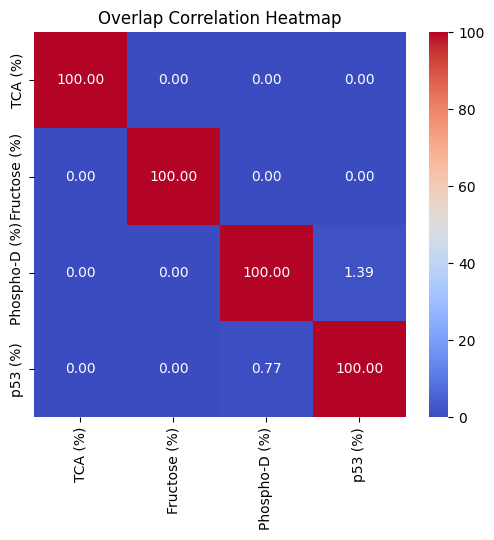

In [33]:
plt.figure(figsize=(6, 5))

# Customize the Y-axis labels
yticklabels = corr_overlaps.columns  # Use column names as Y-axis labels

sns.heatmap(corr_overlaps, annot=True, cmap="coolwarm", fmt=".2f", yticklabels=yticklabels)

# Customize the plot
plt.title("Overlap Correlation Heatmap")
plt.show()

### Transform data using Pearson correlation
#### Correlation matrices for control and HCC classes (Sample-wise)

In [34]:
# 1-p
corr_control = fx.corr_matrix(df_control, corr_type="Dissimilarity", by="Sample")
corr_disease = fx.corr_matrix(df_disease, corr_type="Dissimilarity", by="Sample")

#|1-p|
abs_corr_control = fx.corr_matrix(df_control, corr_type="Absolute Dissimilarity", by="Sample")
abs_corr_disease = fx.corr_matrix(df_disease, corr_type="Absolute Dissimilarity", by="Sample")

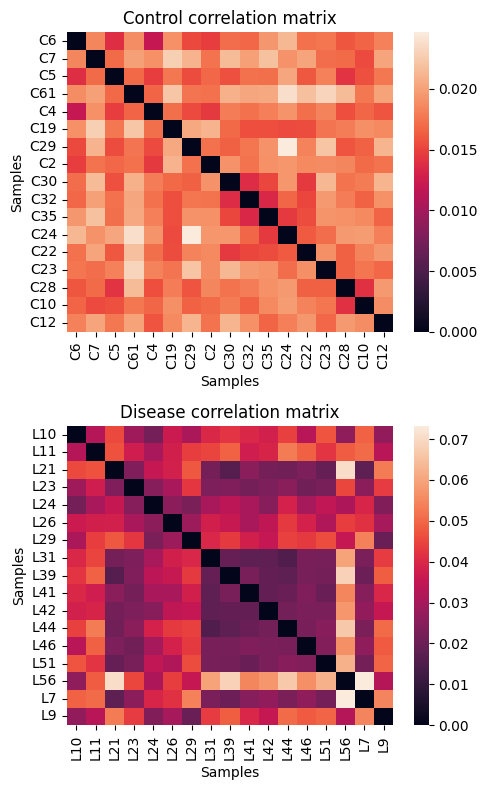

In [35]:
# Plot the correlation matrices 
correlation_matrices = [
    (corr_control, "Control correlation matrix"),
    (corr_disease, "Disease correlation matrix")
]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# Iterate over the correlation matrices and subplot axes
for i, (correlation_matrix, title) in enumerate(correlation_matrices):
    ax = axes[i]
    sns.heatmap(correlation_matrix, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Samples")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Persistence Diagrams
#### PDs for Control and HCC samples classes from Entire (Genome-wide gene expression) dataset

In [36]:
# PD for sample-wise
start_time = time.time()

max_radius = 14
max_dim = 3

cPD_SC = fx.get_persistence_diagram(corr_control, max_dim=max_dim, edge_length=2)
cPD_SH = fx.get_persistence_diagram(corr_disease, max_dim=max_dim, edge_length=2)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.009014368057250977 seconds ---


C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\gudhi\persistence_graphical_tools.py:101: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


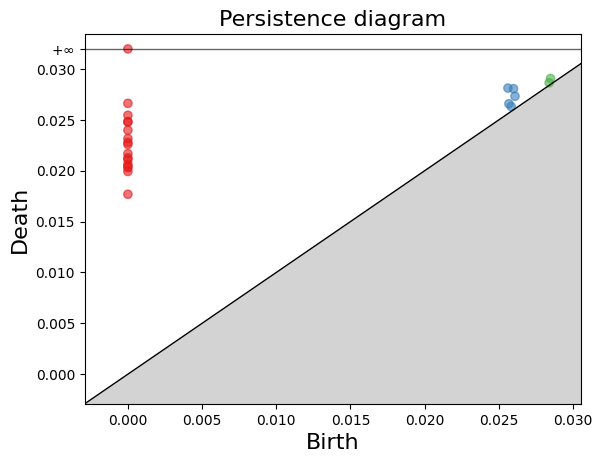

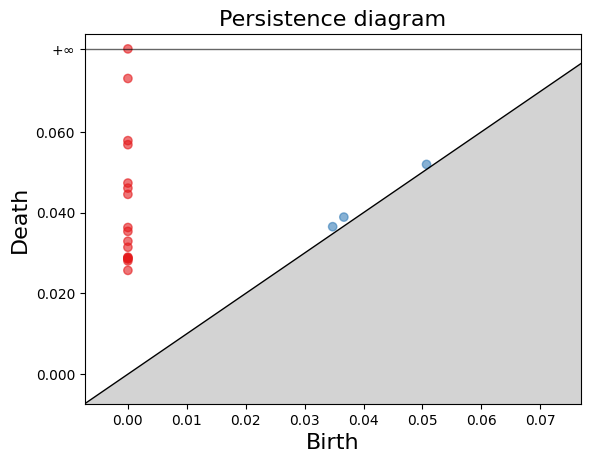

In [37]:
fx.plot_PD(cPD_SC)
fx.plot_PD(cPD_SH)

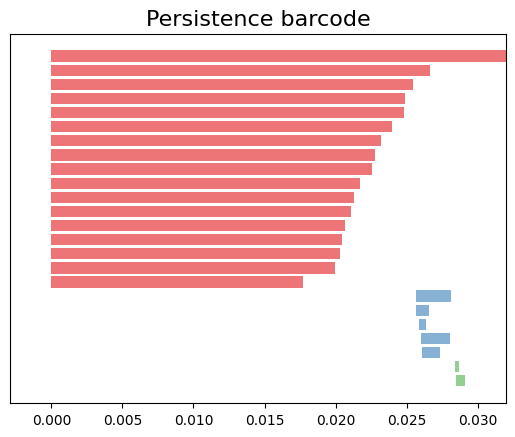

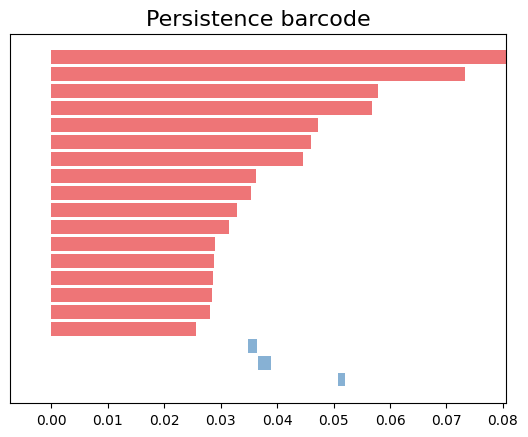

In [38]:
fx.plot_PB(cPD_SC)
fx.plot_PB(cPD_SH)

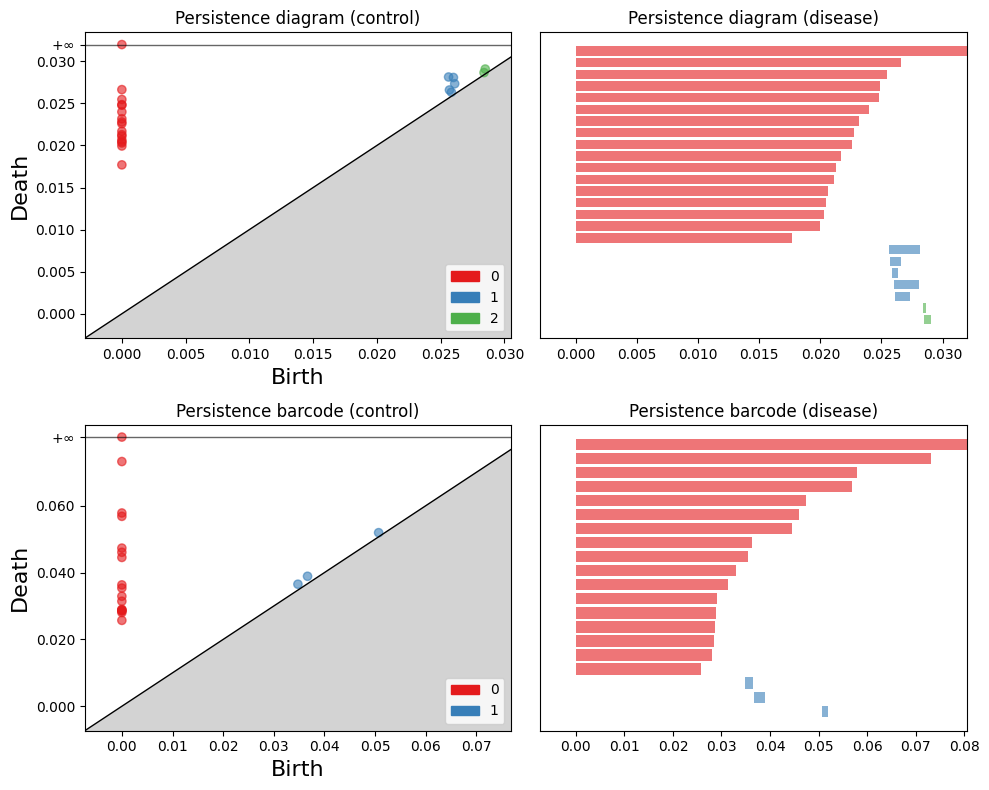

In [39]:
plt.rcParams['axes.grid'] = False

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot persistence diagram, barcode and density plot for cPD_SC
gd.plot_persistence_diagram(persistence=cPD_SC, axes=axes[0, 0], legend=True)
gd.plot_persistence_barcode(persistence=cPD_SC, axes=axes[0, 1], legend=False)

# Plot persistence diagram, barcode and density plot for cPD_SH
gd.plot_persistence_diagram(persistence=cPD_SH, axes=axes[1, 0], legend=True)
gd.plot_persistence_barcode(persistence=cPD_SH, axes=axes[1, 1], legend=False)

# Set titles and labels for the subplots
axes[0, 0].set_title('Persistence diagram (control)')
axes[0, 1].set_title('Persistence diagram (disease)')

axes[1, 0].set_title('Persistence barcode (control)')
axes[1, 1].set_title('Persistence barcode (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

### Correlation matrices for pathway-specific datasets from KEGG pathways (Sample-wise)
#### Control samples class

In [40]:
start_time = time.time()

corr_kegg_data_c = []
corr_kegg_dict_c = {}

for i in range(len(kegg_filtered)):
    corr_kegg = fx.corr_matrix(kegg_data_c[i], corr_type="Dissimilarity", by="Sample")
    corr_kegg_data_c.append(corr_kegg)
    corr_kegg_dict_c[kegg_filtered['Description'][i]] = corr_kegg

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2902541160583496 seconds ---


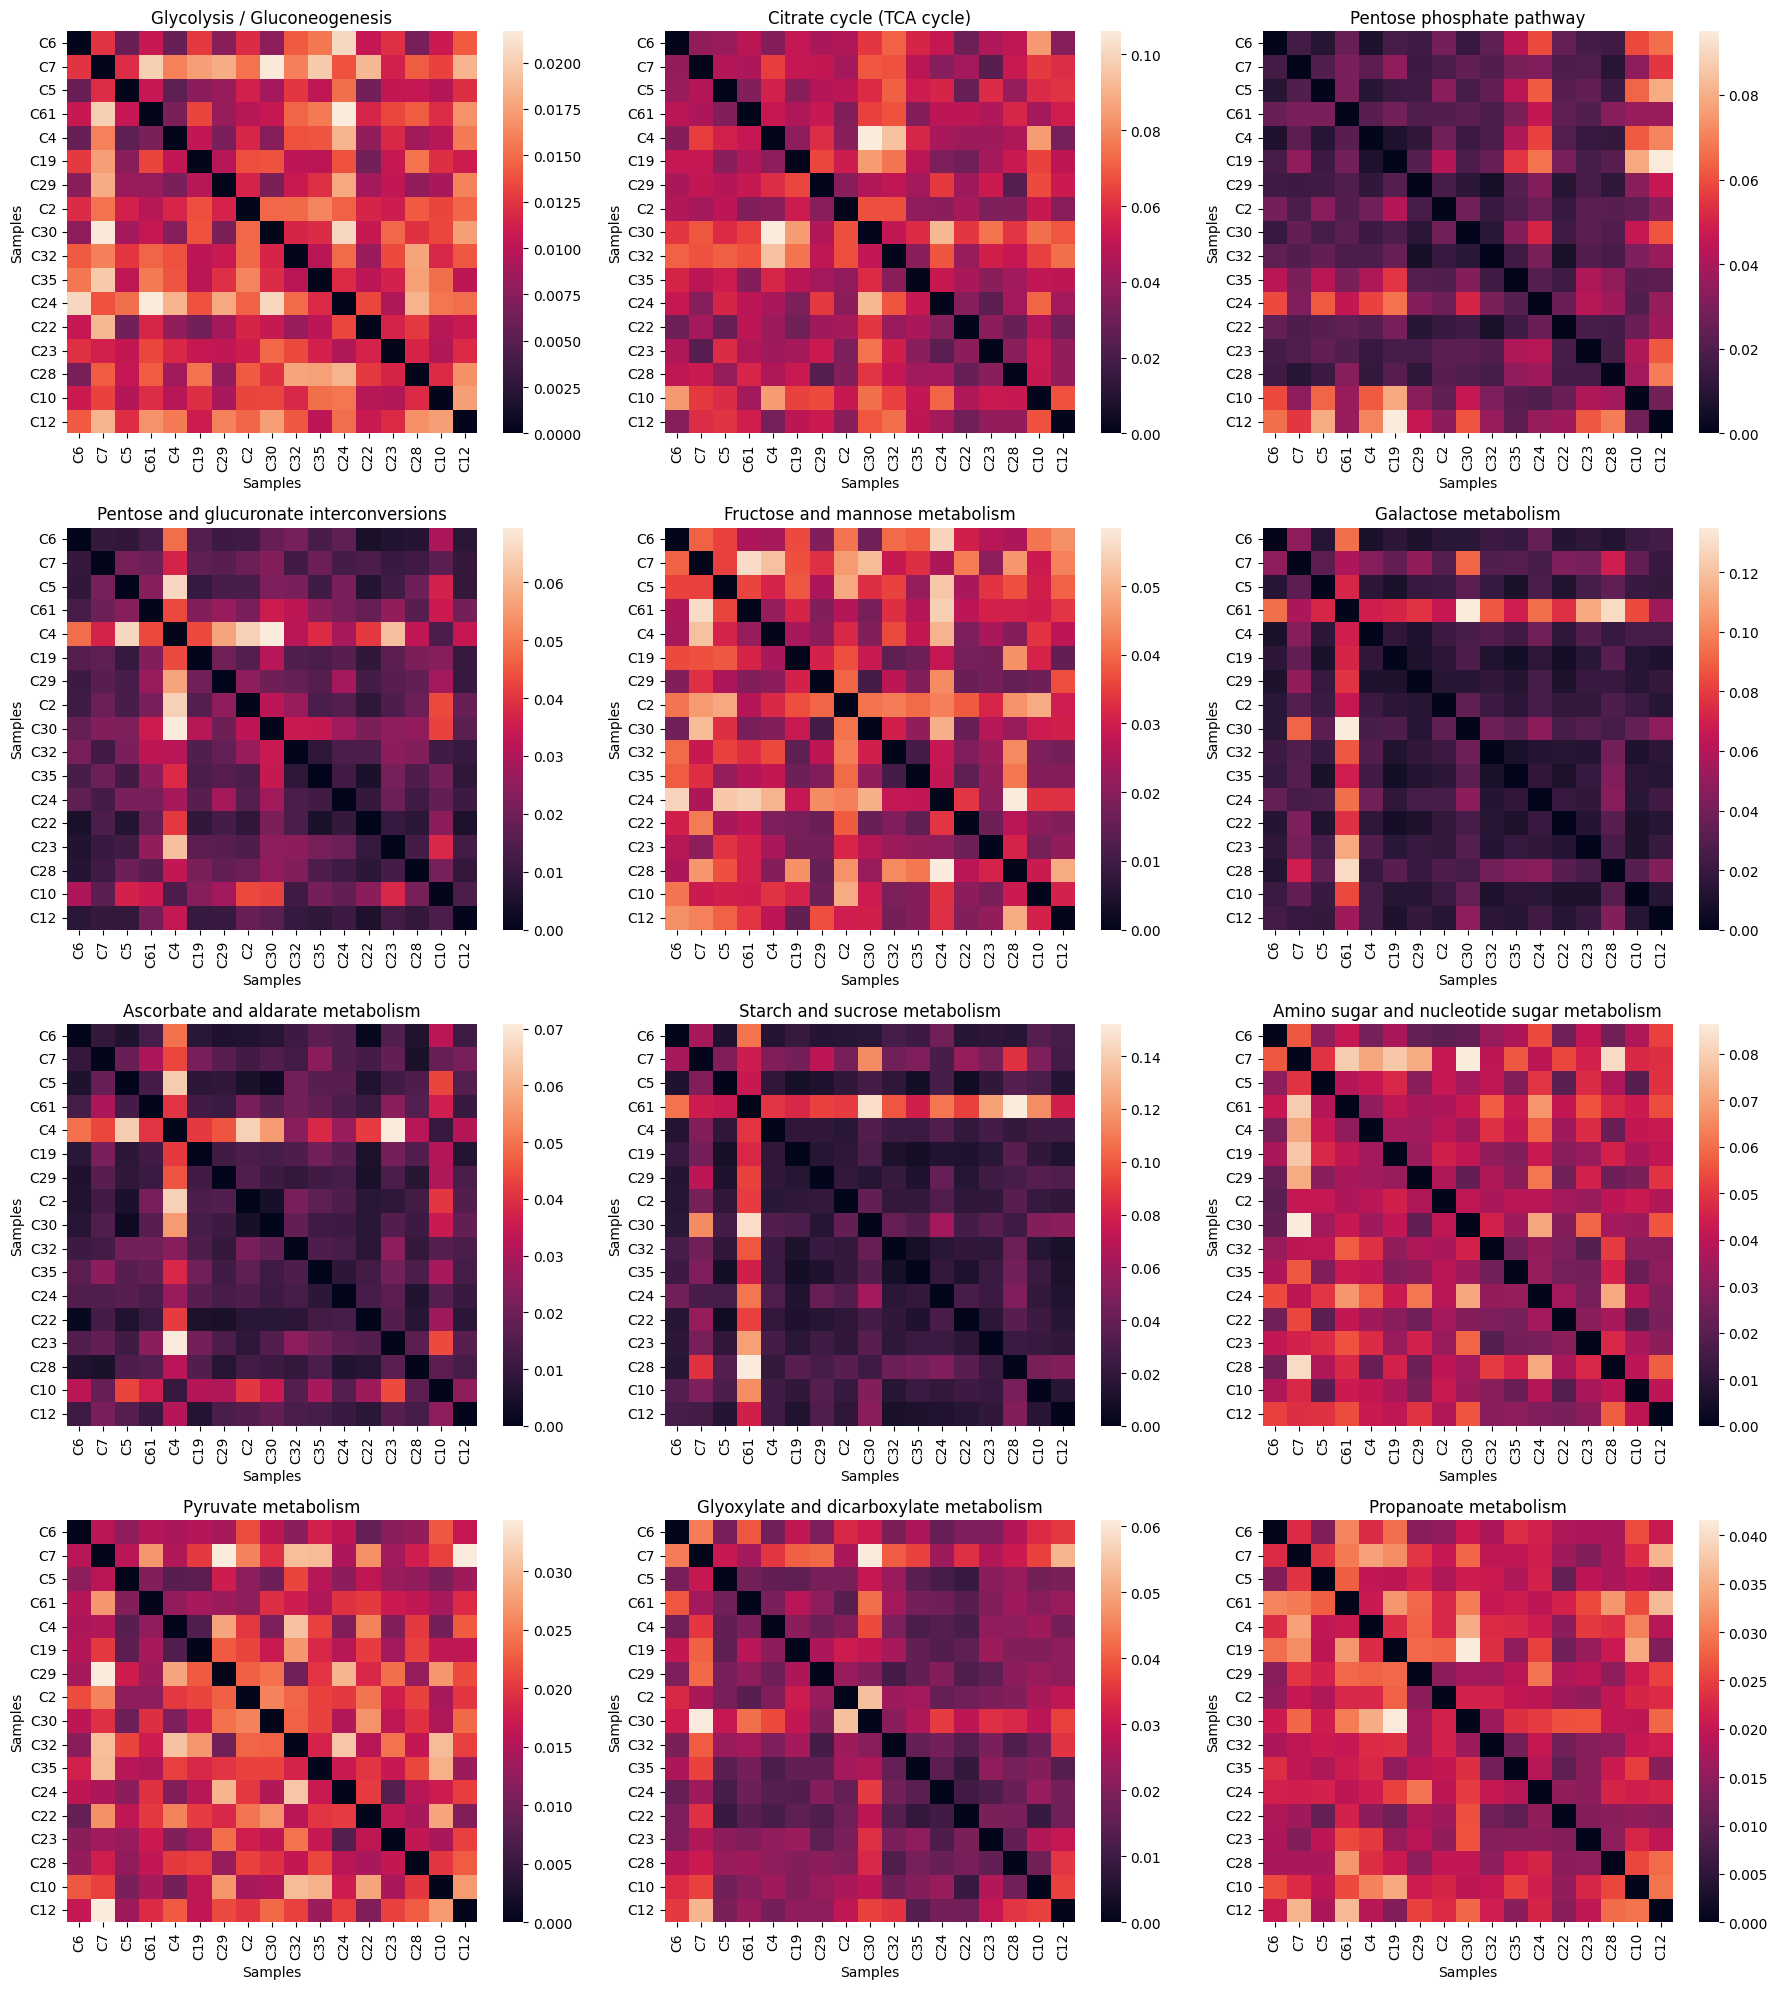

In [41]:
# Define the correlation matrices
corr_matrices = []
for key, value in corr_kegg_dict_c.items():
    corr = (value, key)
    corr_matrices.append(corr)

# Restrict the plotting to only the first 12 elements
corr_matrices = corr_matrices[:12]
    
# Create the subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# Iterate over the correlation matrices and subplot axes
for i, (correlation_matrix, title) in enumerate(corr_matrices):
    ax = axes[i // 3, i % 3]
    sns.heatmap(correlation_matrix, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Samples")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Disease (HCC) samples class

In [42]:
start_time = time.time()

corr_kegg_data_d = []
corr_kegg_dict_d = {}

for i in range(len(kegg_filtered)):
    corr_kegg = fx.corr_matrix(kegg_data_d[i], corr_type="Dissimilarity", by="Sample")
    corr_kegg_data_d.append(corr_kegg)
    corr_kegg_dict_d[kegg_filtered['Description'][i]] = corr_kegg

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.11973047256469727 seconds ---


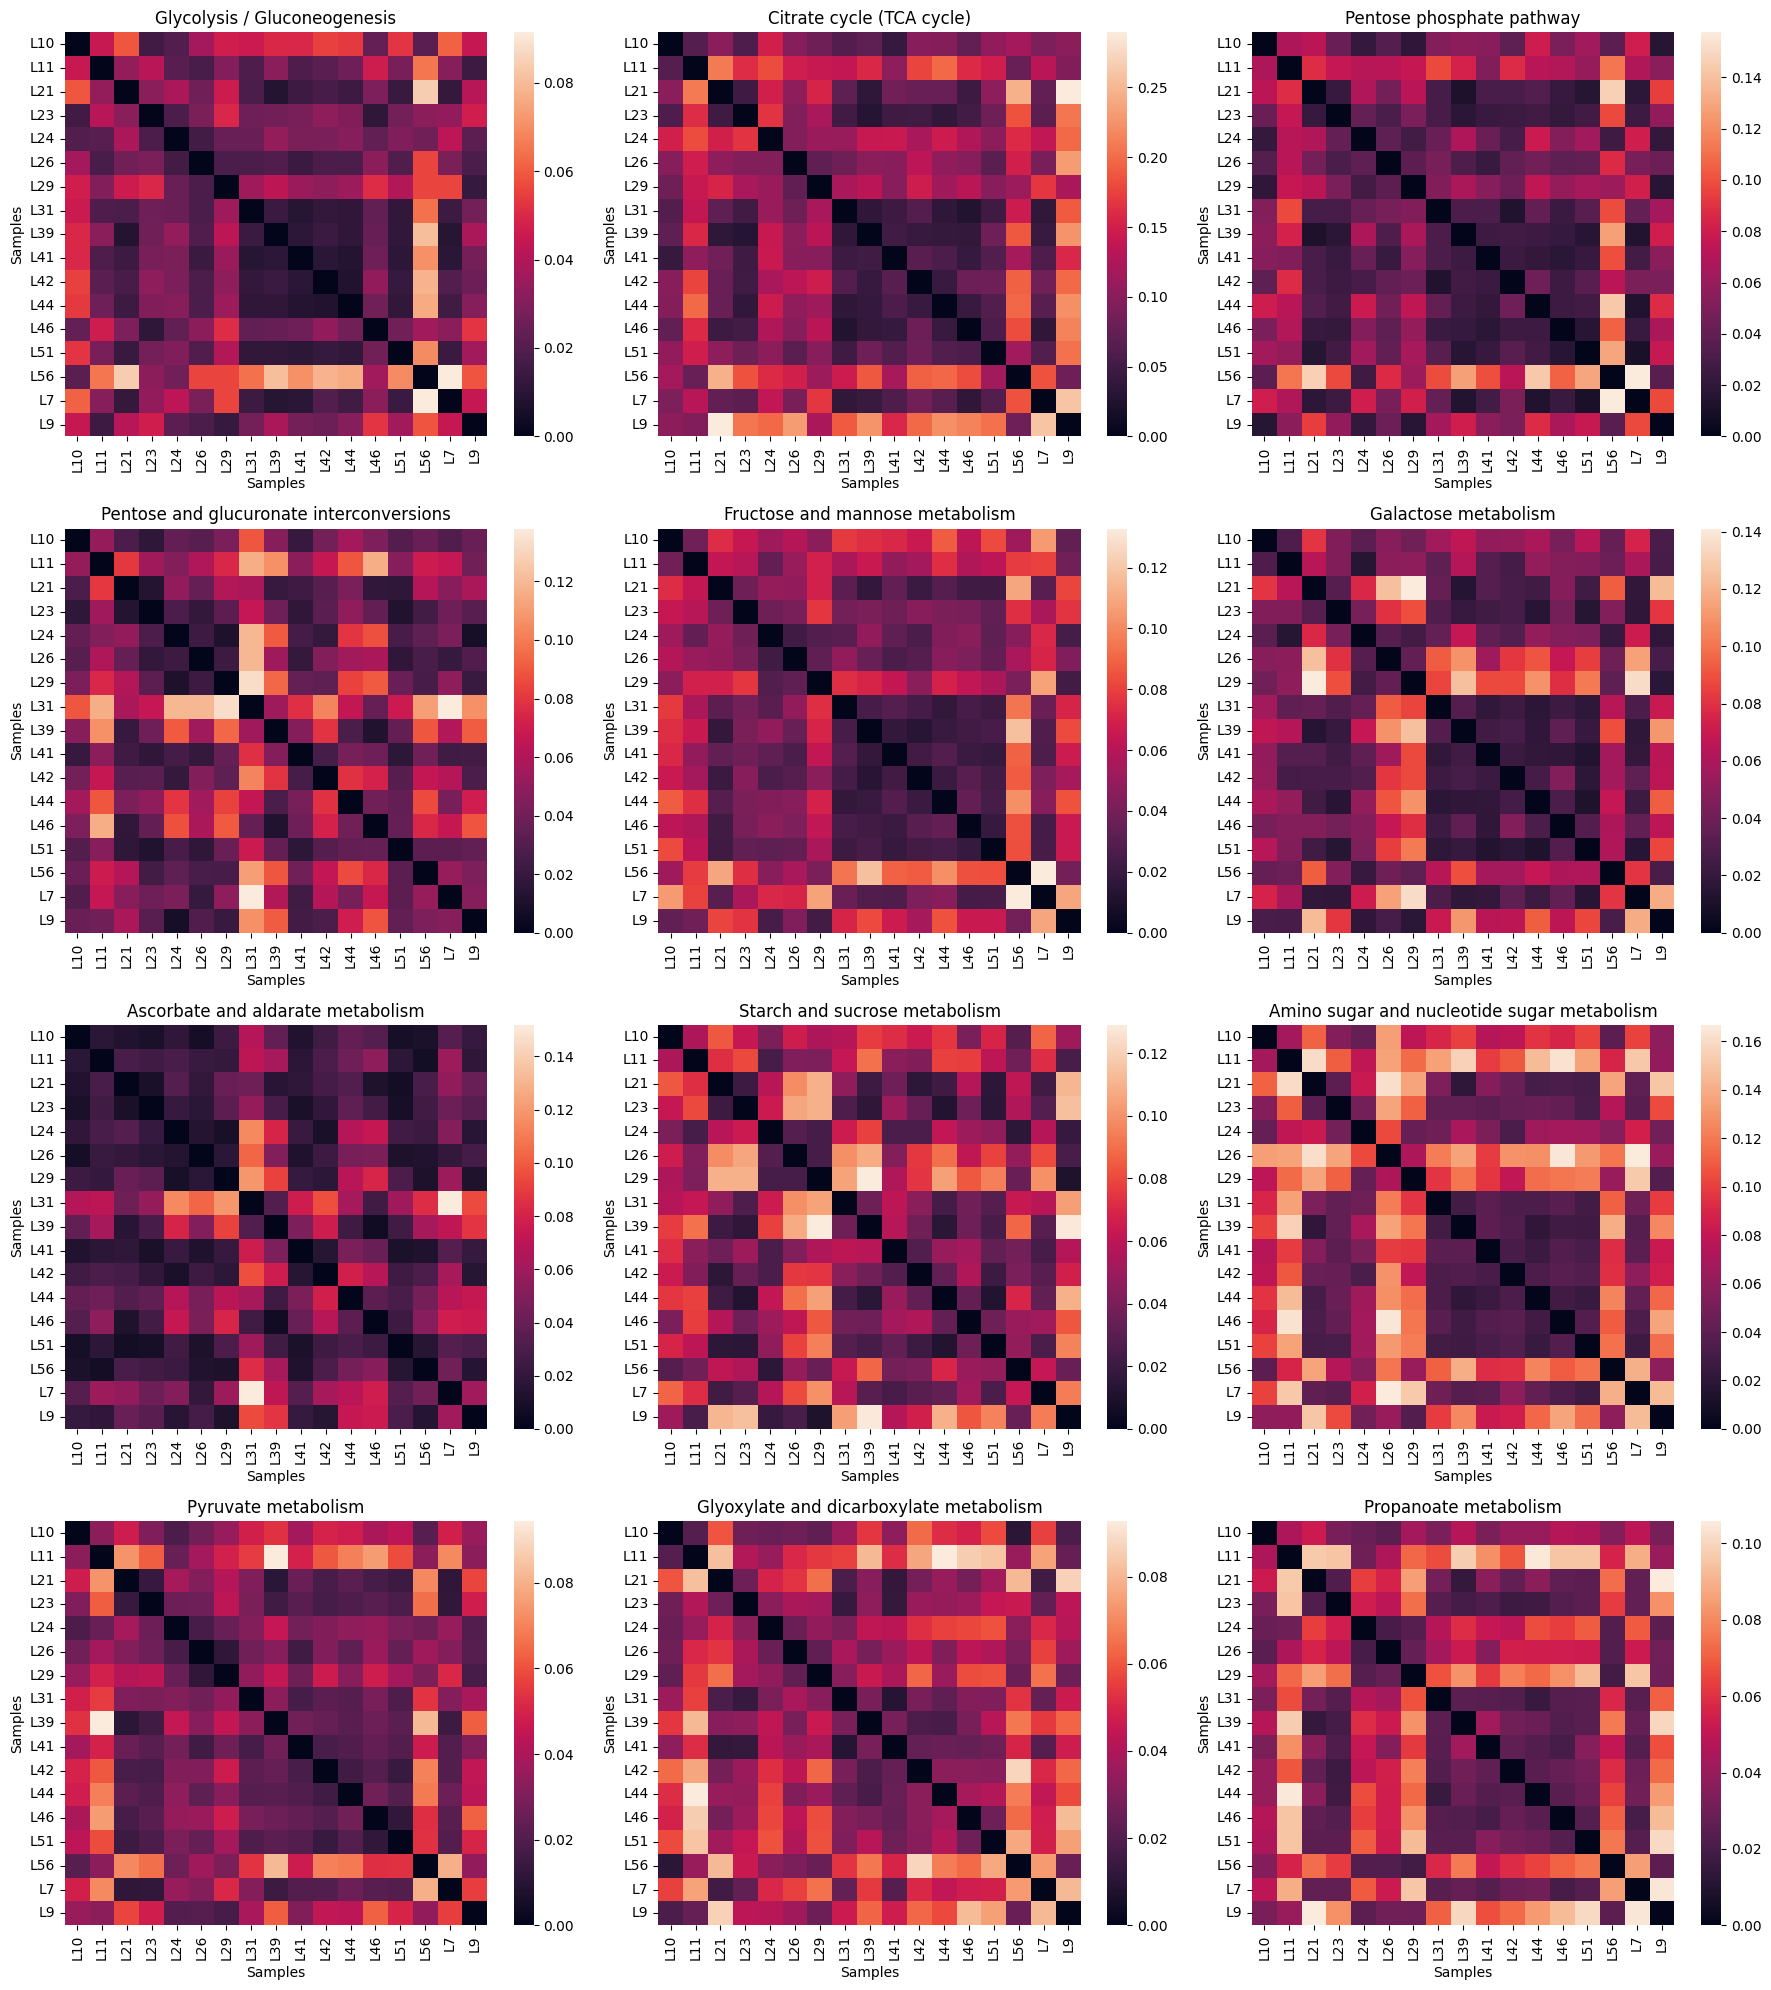

In [43]:
# Define the correlation matrices
corr_matrices = []
for key, value in corr_kegg_dict_d.items():
    corr = (value, key)
    corr_matrices.append(corr)

# Restrict the plotting to only the first 12 elements
corr_matrices = corr_matrices[:12]
    
# Create the subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# Iterate over the correlation matrices and subplot axes
for i, (correlation_matrix, title) in enumerate(corr_matrices):
    ax = axes[i // 3, i % 3]
    sns.heatmap(correlation_matrix, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Samples")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### PDs for the pathway-specific point clouds using distance correlation for KEGG pathways (Sample-wise)
#### Control (healthy) samples class

In [44]:
# Persistence Homology
start_time = time.time()

corr_dgms_c = {}
for name, corr_data in corr_kegg_dict_c.items():
    corr_dgms_c[name] = fx.get_persistence_diagram(corr_data, max_dim=max_dim, edge_length=max_radius)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0075223445892334 seconds ---


#### Disease (HCC) samples class

In [45]:
# Persistence Homology
start_time = time.time()

corr_dgms_d = {}
for name, corr_data in corr_kegg_dict_d.items():
    corr_dgms_d[name] = fx.get_persistence_diagram(corr_data, max_dim=max_dim, edge_length=max_radius)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0741734504699707 seconds ---


### Correlation matrices of pathway-specific data of some selected KEGG pathways (Sample-wise)

In [46]:
corr_tca_c = corr_kegg_data_c[tca_index]
corr_tca_d = corr_kegg_data_d[tca_index]

corr_fructose_c = corr_kegg_data_c[fructose_index]
corr_fructose_d = corr_kegg_data_d[fructose_index]

corr_phospho_c = corr_kegg_data_c[phospho_index]
corr_phospho_d = corr_kegg_data_d[phospho_index]

corr_p53_c = corr_kegg_data_c[p53_index]
corr_p53_d = corr_kegg_data_d[p53_index]

### PDs of some selected KEGG pathways 
#### Citrate cycle (TCA cycle)

In [47]:
PD_tca_c = corr_dgms_c[tca_name]
PD_tca_d = corr_dgms_d[tca_name]

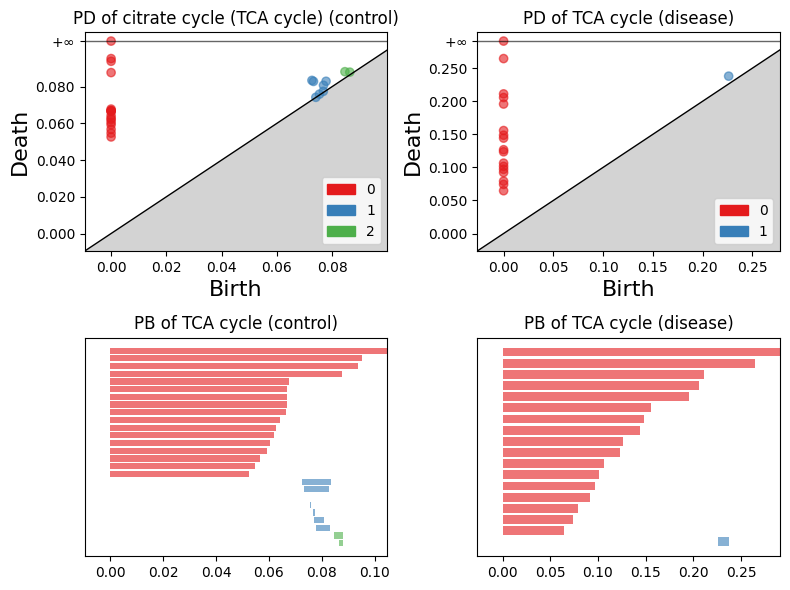

In [48]:
plt.rcParams['axes.grid'] = False

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# 1st row
gd.plot_persistence_diagram(persistence=PD_tca_c, axes=axes[0, 0], legend=True)
gd.plot_persistence_barcode(persistence=PD_tca_c, axes=axes[1, 0], legend=False)

# 2nd row
gd.plot_persistence_diagram(persistence=PD_tca_d, axes=axes[0, 1], legend=True)
gd.plot_persistence_barcode(persistence=PD_tca_d, axes=axes[1, 1], legend=False)

# Set titles and labels for the subplots
axes[0, 0].set_title('PD of citrate cycle (TCA cycle) (control)')
axes[0, 1].set_title('PD of TCA cycle (disease)')

axes[1, 0].set_title('PB of TCA cycle (control)')
axes[1, 1].set_title('PB of TCA cycle (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

#### Fructose and mannose metabolism

In [49]:
PD_fructose_c = corr_dgms_c[fructose_name]
PD_fructose_d = corr_dgms_d[fructose_name]

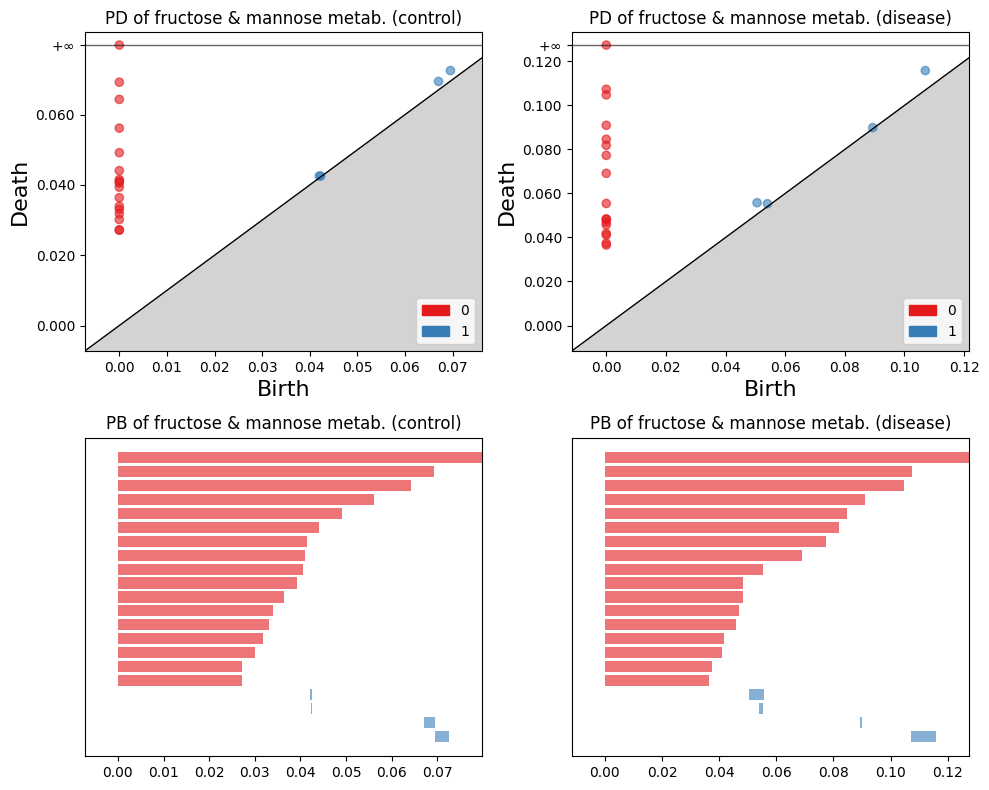

In [50]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 1st row
gd.plot_persistence_diagram(persistence=PD_fructose_c, axes=axes[0, 0], legend=True)
gd.plot_persistence_barcode(persistence=PD_fructose_c, axes=axes[1, 0], legend=False)

# 2nd row
gd.plot_persistence_diagram(persistence=PD_fructose_d, axes=axes[0, 1], legend=True)
gd.plot_persistence_barcode(persistence=PD_fructose_d, axes=axes[1, 1], legend=False)

# Set titles and labels for the subplot
axes[0, 0].set_title('PD of fructose & mannose metab. (control)')
axes[0, 1].set_title('PD of fructose & mannose metab. (disease)')

axes[1, 0].set_title('PB of fructose & mannose metab. (control)')
axes[1, 1].set_title('PB of fructose & mannose metab. (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

##### Phospholipase D signaling pathway

In [51]:
PD_phospho_c = corr_dgms_c[phospho_name]
PD_phospho_d = corr_dgms_d[phospho_name]

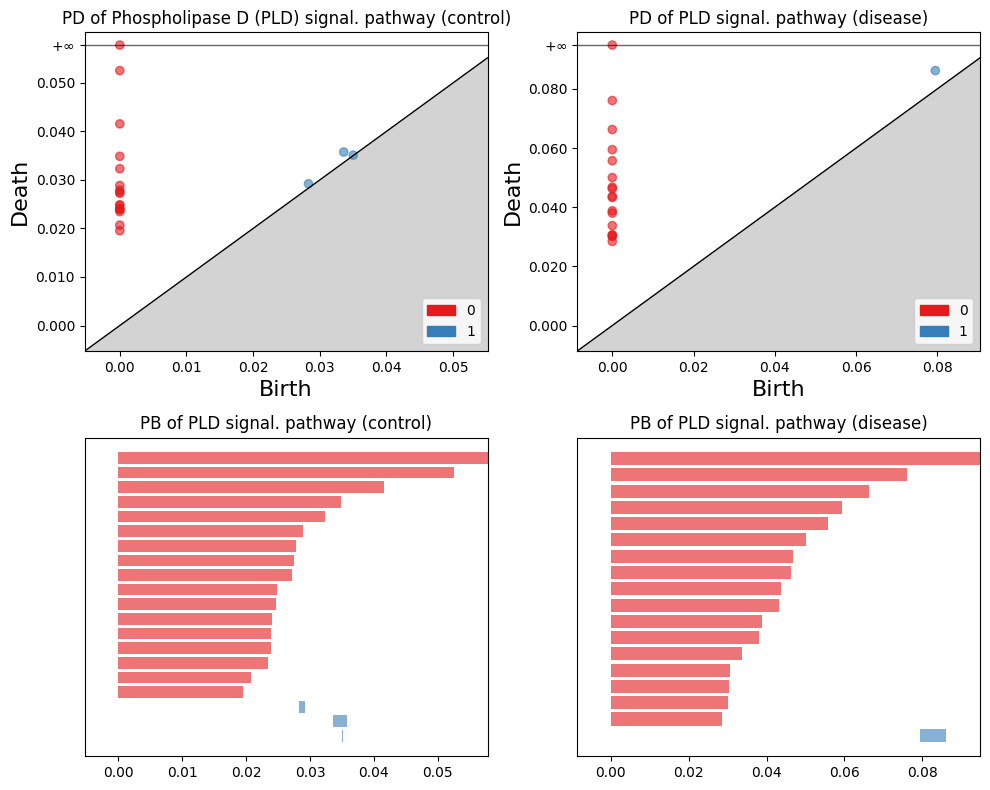

In [52]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 1st row
gd.plot_persistence_diagram(persistence=PD_phospho_c, axes=axes[0, 0], legend=True)
gd.plot_persistence_barcode(persistence=PD_phospho_c, axes=axes[1, 0], legend=False)

# 2nd row
gd.plot_persistence_diagram(persistence=PD_phospho_d, axes=axes[0, 1], legend=True)
gd.plot_persistence_barcode(persistence=PD_phospho_d, axes=axes[1, 1], legend=False)

# Set titles and labels for the subplots
axes[0, 0].set_title('PD of Phospholipase D (PLD) signal. pathway (control)')
axes[0, 1].set_title('PD of PLD signal. pathway (disease)')

axes[1, 0].set_title('PB of PLD signal. pathway (control)')
axes[1, 1].set_title('PB of PLD signal. pathway (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

##### p53 signaling pathway

In [53]:
PD_p53_c = corr_dgms_c[p53_name]
PD_p53_d = corr_dgms_d[p53_name]

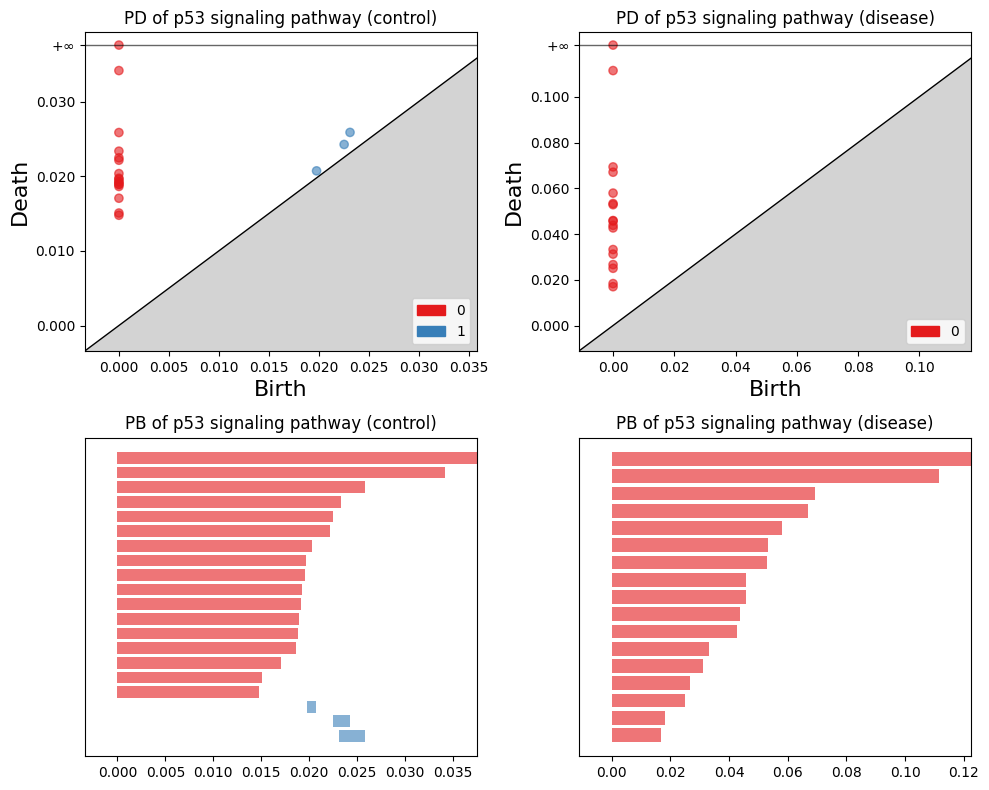

In [54]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 1st row
gd.plot_persistence_diagram(persistence=PD_p53_c, axes=axes[0, 0], legend=True)
gd.plot_persistence_barcode(persistence=PD_p53_c, axes=axes[1, 0], legend=False)

# 2nd row
gd.plot_persistence_diagram(persistence=PD_p53_d, axes=axes[0, 1], legend=True)
gd.plot_persistence_barcode(persistence=PD_p53_d, axes=axes[1, 1], legend=False)

# Set titles and labels for the subplots
axes[0, 0].set_title('PD of p53 signaling pathway (control)')
axes[0, 1].set_title('PD of p53 signaling pathway (disease)')

axes[1, 0].set_title('PB of p53 signaling pathway (control)')
axes[1, 1].set_title('PB of p53 signaling pathway (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

#### Plots for all the PDs (genome-wide and selected pathways)

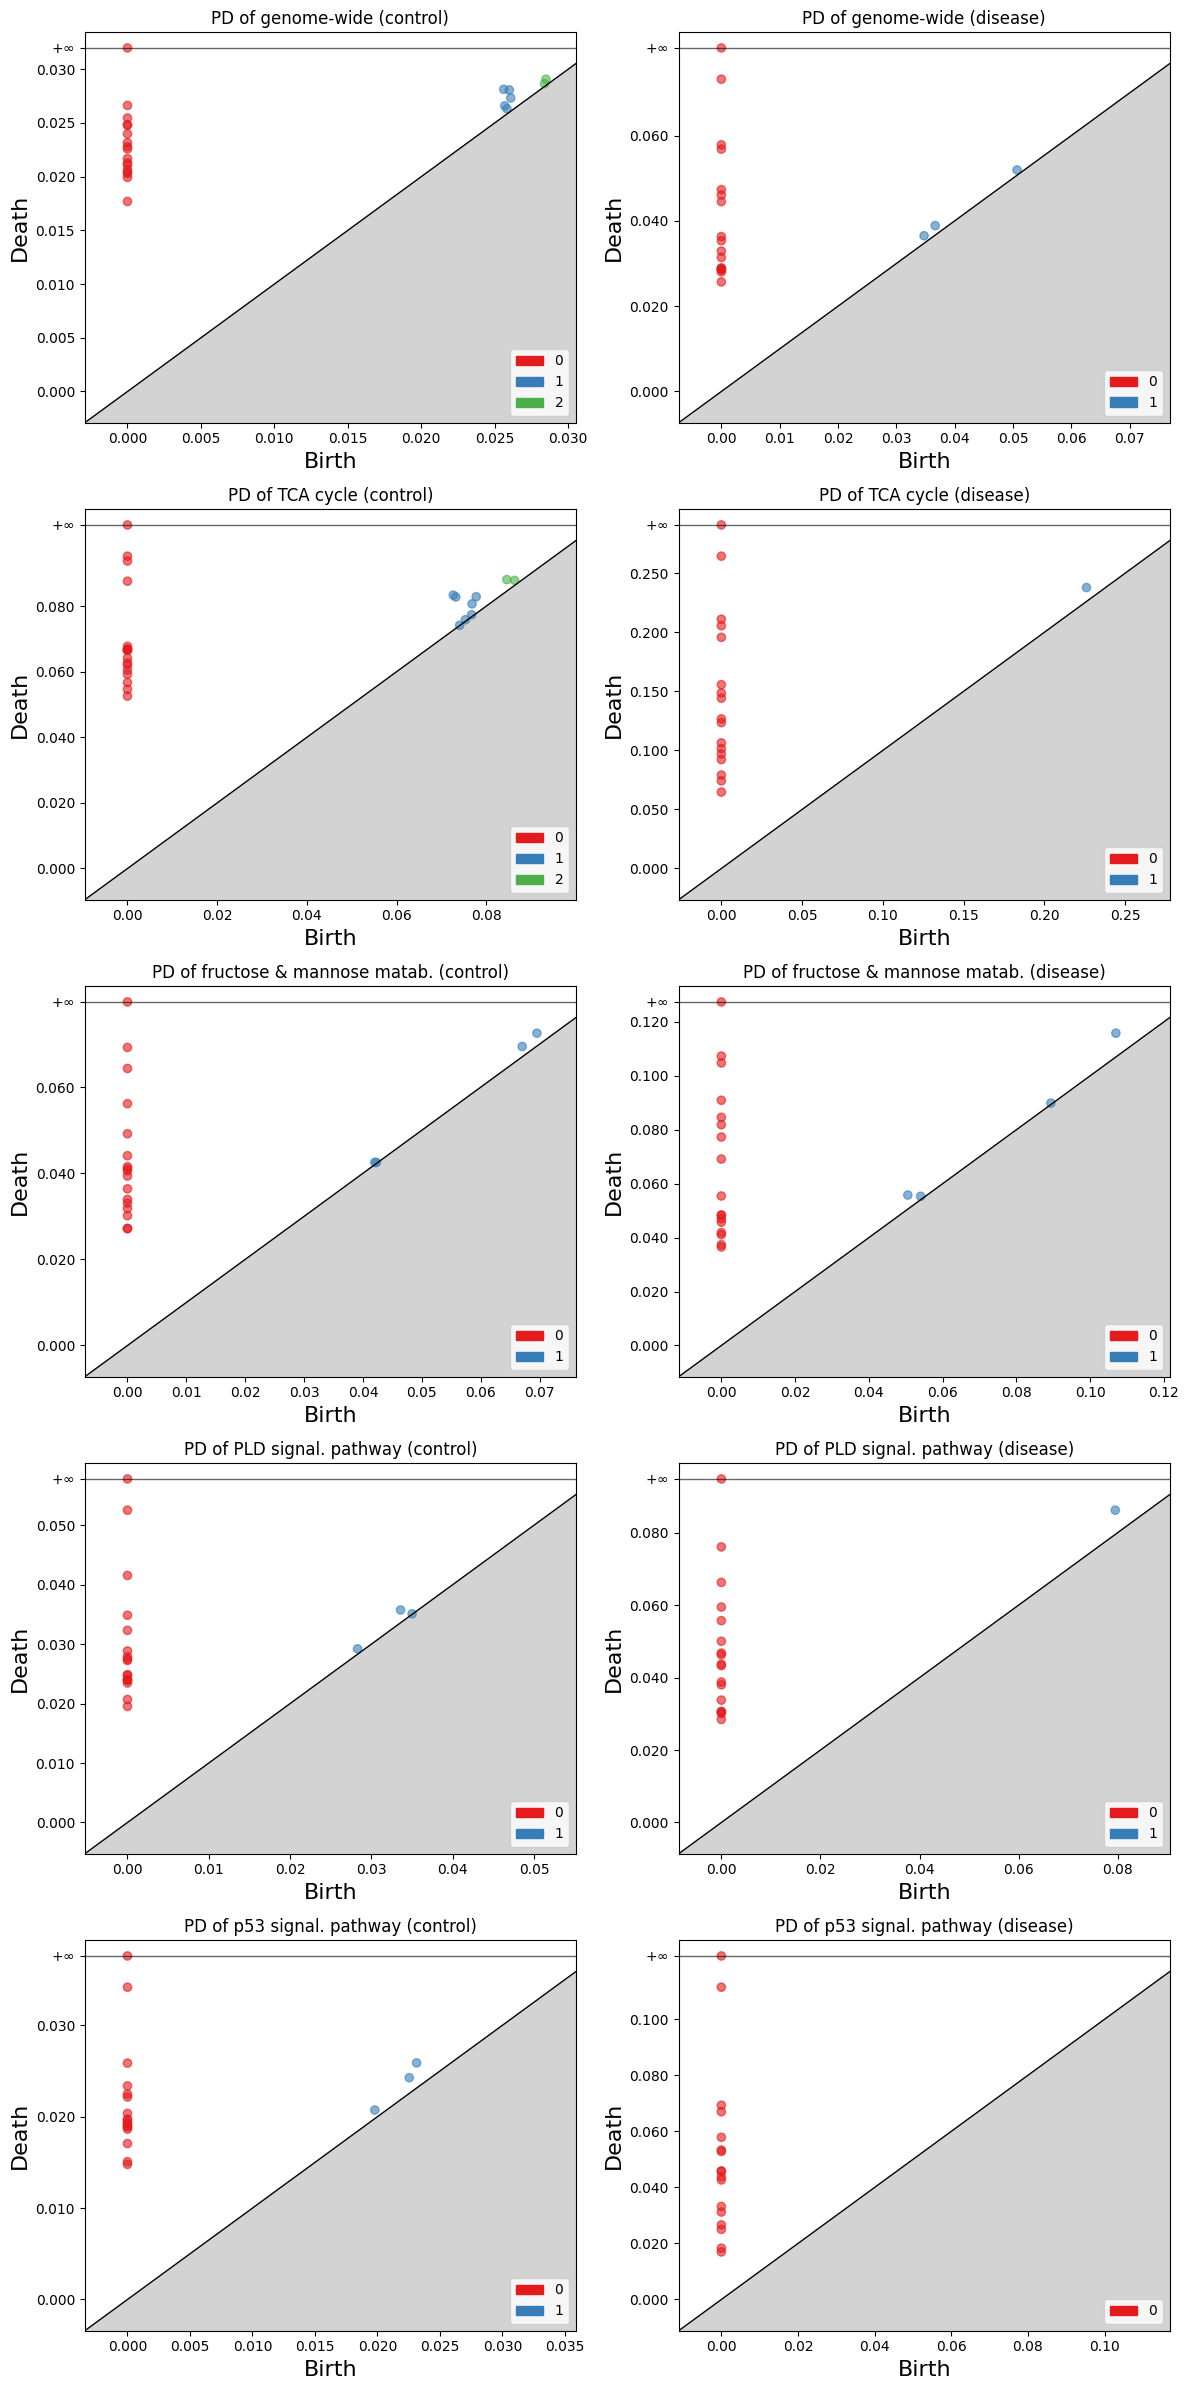

In [55]:
# Create subplots with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

# 1st row
gd.plot_persistence_diagram(persistence=cPD_SC, axes=axes[0, 0], legend=True)
gd.plot_persistence_diagram(persistence=PD_tca_c, axes=axes[1, 0], legend=True)
gd.plot_persistence_diagram(persistence=PD_fructose_c, axes=axes[2, 0], legend=True)
gd.plot_persistence_diagram(persistence=PD_phospho_c, axes=axes[3, 0], legend=True)
gd.plot_persistence_diagram(persistence=PD_p53_c, axes=axes[4, 0], legend=True)

# 2nd row
gd.plot_persistence_diagram(persistence=cPD_SH, axes=axes[0, 1], legend=True)
gd.plot_persistence_diagram(persistence=PD_tca_d, axes=axes[1, 1], legend=True)
gd.plot_persistence_diagram(persistence=PD_fructose_d, axes=axes[2, 1], legend=True)
gd.plot_persistence_diagram(persistence=PD_phospho_d, axes=axes[3, 1], legend=True)
gd.plot_persistence_diagram(persistence=PD_p53_d, axes=axes[4, 1], legend=True)

# Set titles and labels for the subplots
axes[0, 0].set_title('PD of genome-wide (control)')
axes[0, 1].set_title('PD of genome-wide (disease)')

axes[1, 0].set_title('PD of TCA cycle (control)')
axes[1, 1].set_title('PD of TCA cycle (disease)')

axes[2, 0].set_title('PD of fructose & mannose matab. (control)')
axes[2, 1].set_title('PD of fructose & mannose matab. (disease)')

axes[3, 0].set_title('PD of PLD signal. pathway (control)')
axes[3, 1].set_title('PD of PLD signal. pathway (disease)')

axes[4, 0].set_title('PD of p53 signal. pathway (control)')
axes[4, 1].set_title('PD of p53 signal. pathway (disease)')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

### Get a pathway name based on its correponding data

In [56]:
pathways_data_corr = [corr_kegg_data_c[tca_index], corr_kegg_data_c[fructose_index], corr_kegg_data_c[phospho_index], corr_kegg_data_c[p53_index]]
kegg_keys_corr = []

for i in range(len(pathways_data_corr)):
    value = pathways_data_corr[i]
    for key, item in corr_kegg_dict_c.items():
        if item.equals(value):
            kegg_keys_corr.append(key)

print(kegg_keys_corr)

['Citrate cycle (TCA cycle)', 'Fructose and mannose metabolism', 'Phospholipase D signaling pathway', 'p53 signaling pathway']


### Betti numbers for the entire (genome-wide gene expression) dataset

In [57]:
corr_dict_all = {
    'control': corr_control,
    'disease': corr_disease
}

lens = np.append(np.arange(0, 0.1, 0.0001), np.inf)
len(lens)

1001

In [58]:
# Get the betti numbers (~ 1 minutes)
start_time = time.time()

corr_betti = {}
for name, corr_data in corr_dict_all.items():
    corr_betti[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lens)

print("--- %s seconds ---" % (time.time() - start_time))

--- 13.24786376953125 seconds ---


##### Plot the n-dimensional betti numbers curves for a given n

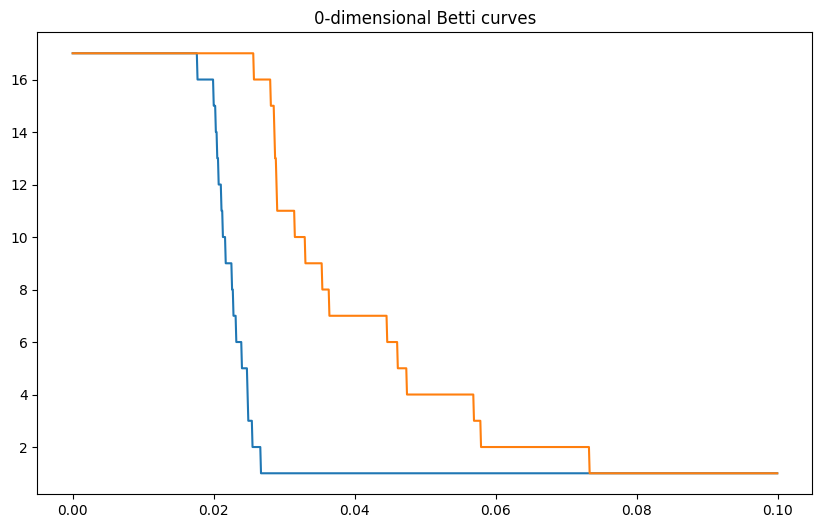

--- 0.3189432621002197 seconds ---


In [59]:
start_time = time.time()

plt.figure(figsize=(10,6))

ndim = 0
for name, corr_data in corr_dict_all.items():
    plt.plot(lens, corr_betti[name][ndim])
    
plt.title("{}-dimensional Betti curves".format(ndim))
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

##### Plot the Betti curves for all n for each sample class

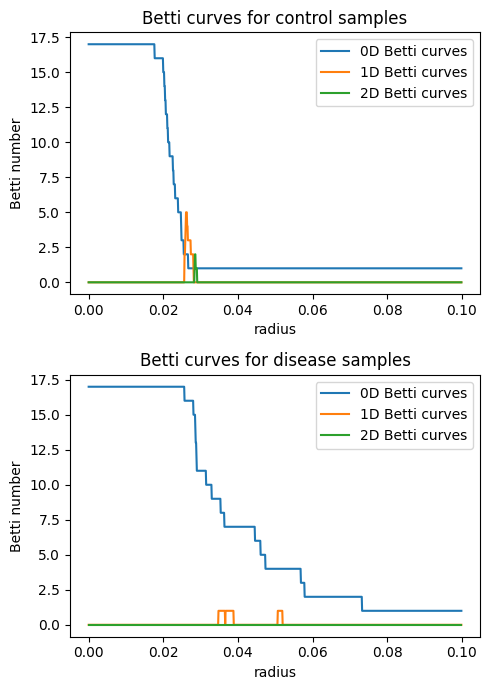

In [60]:
data_keys_all = corr_dict_all.keys()

# Create a figure with 2 rows and 3 columns
plt.figure(figsize=(5, 7))

# Plot data for each name and dimension
for i, name in enumerate(data_keys_all, start=1):
    # Create subplots in a grid
    plt.subplot(len(data_keys_all), 1, i)
    
    for ndim in range(3):
        plt.plot(lens, corr_betti[name][ndim], label="{}D Betti curves".format(ndim))

    plt.title("Betti curves for {} samples".format(name))
    plt.xlabel("radius")
    plt.ylabel("Betti number")
    plt.legend()
    #plt.grid(True)

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()

### Betti numbers of all pathway-specific datasets from KEGG pathways
#### Control samples class

In [61]:
partitioner = np.append(np.arange(0, 1.2, 0.01), np.inf)
milestones = {0, 5, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250}
len(partitioner)

121

In [62]:
# Get the betti numbers (~6 minutes)
start_time = time.time()

corr_betti_nos_c = {}
for i, (name, corr_data) in enumerate(corr_kegg_dict_c.items()):
    corr_betti_nos_c[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=partitioner)
    
    if i in milestones:
        print(i+1)

print("--- %s seconds ---" % (time.time() - start_time))

1
6
21
31
51
76
101
126
151
176
201
226
251
--- 360.66597843170166 seconds ---


##### Plot the n-dimensional betti numbers curves for a given n

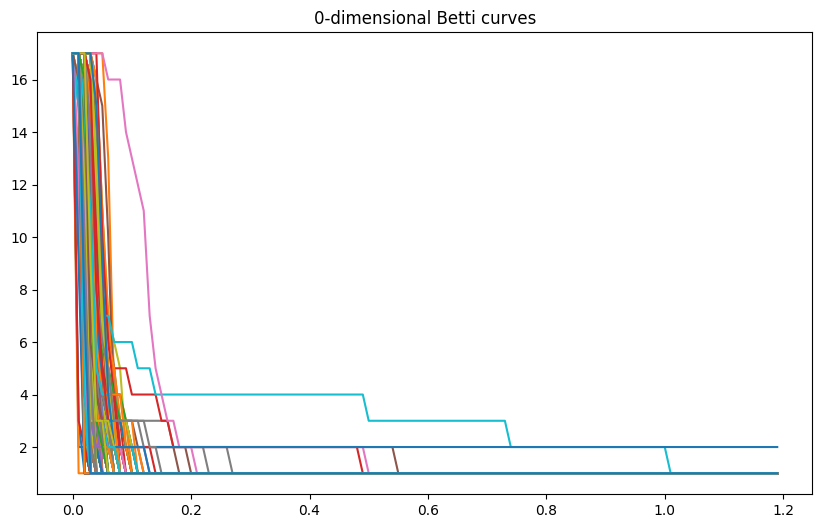

--- 0.6778819561004639 seconds ---


In [63]:
start_time = time.time()

plt.figure(figsize=(10,6))

ndim = 0
for name, corr_data in corr_kegg_dict_c.items():
    plt.plot(partitioner, corr_betti_nos_c[name][ndim])
    
plt.title("{}-dimensional Betti curves".format(ndim))
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

##### Plot for a single pathway

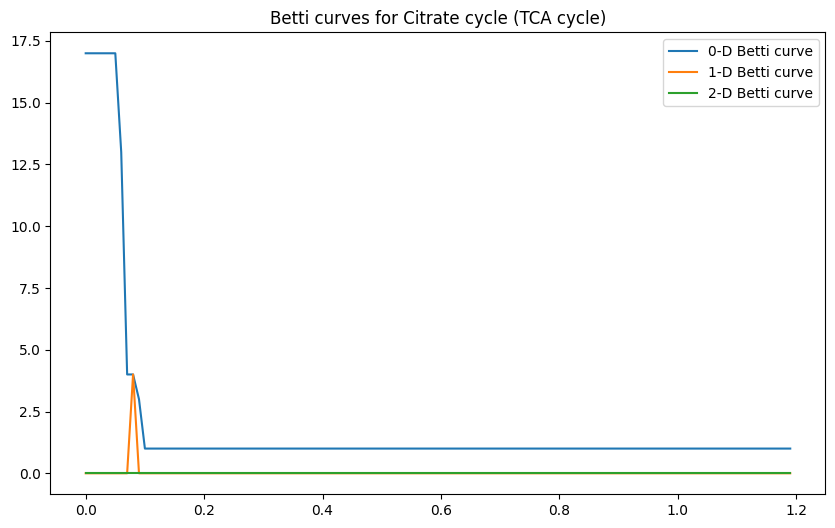

--- 0.4253849983215332 seconds ---


In [64]:
start_time = time.time()

plt.figure(figsize=(10,6))

name = tca_name #predfined pathway name

for ndim in range(0,3):
    plt.plot(partitioner, corr_betti_nos_c[name][ndim], label="{}-D Betti curve".format(ndim))
        
plt.title("Betti curves for {}".format(name))
plt.legend()
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

#### Disease (HCC) samples class

In [65]:
# Get the betti numbers (~6 minutes)
start_time = time.time()

corr_betti_nos_d = {}
for i, (name, corr_data) in enumerate(corr_kegg_dict_d.items()):
    corr_betti_nos_d[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=partitioner)
    
    if i in milestones:
        print(i+1)

print("--- %s seconds ---" % (time.time() - start_time))

1
6
21
31
51
76
101
126
151
176
201
226
251
--- 329.60416889190674 seconds ---


##### Plot the n-dimensional betti numbers curves for a given n.

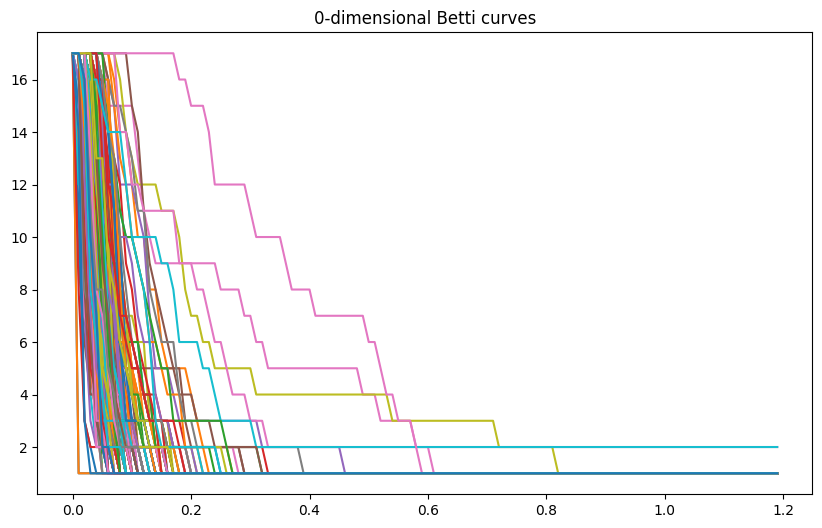

--- 0.675290584564209 seconds ---


In [66]:
start_time = time.time()

plt.figure(figsize=(10,6))

ndim = 0
for name, corr_data in corr_kegg_dict_d.items():
    plt.plot(partitioner, corr_betti_nos_d[name][ndim])
    
plt.title("{}-dimensional Betti curves".format(ndim))
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

##### Plot for a single pathway

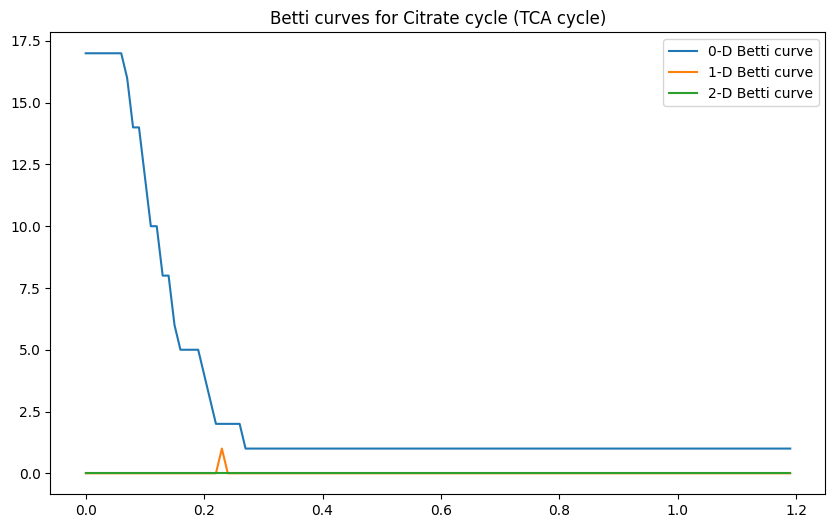

--- 0.6736342906951904 seconds ---


In [67]:
start_time = time.time()

plt.figure(figsize=(10,6))

name = tca_name #predfined pathway name

for ndim in range(0,3):
    plt.plot(partitioner, corr_betti_nos_d[name][ndim], label="{}-D Betti curve".format(ndim))
        
plt.title("Betti curves for {}".format(name))
plt.legend()
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

### Similarity/dissimilarity between pathways identified by PH method

In [69]:
start_time = time.time() # 4 mins approx.

#Betti numbers
corr_dict_all = {'control': corr_control,
                 'disease': corr_disease}

corr_dict_tca = {'control': corr_tca_c,
                 'disease': corr_tca_d}

corr_dict_fructose = {'control': corr_fructose_c,
                     'disease': corr_fructose_d}

corr_dict_phospho = {'control': corr_phospho_c,
                     'disease': corr_phospho_d}

corr_dict_p53 = {'control': corr_p53_c,
                 'disease': corr_p53_d}

#Thresholds
lenses_1 = np.append(np.arange(0, 0.1, 0.00005), np.inf)
lenses_2 = np.append(np.arange(0, 0.15, 0.00005), np.inf)
lenses_3 = np.append(np.arange(0, 0.3, 0.00005), np.inf)

#Get Betti numbers
corr_betti = {}
for name, corr_data in corr_dict_all.items():
    corr_betti[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lenses_1)
    
corr_betti_tca = {}
for name, corr_data in corr_dict_tca.items():
    corr_betti_tca[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lenses_3)
    
corr_betti_fructose = {}
for name, corr_data in corr_dict_fructose.items():
    corr_betti_fructose[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lenses_2)
    
corr_betti_phospho = {}
for name, corr_data in corr_dict_phospho.items():
    corr_betti_phospho[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lenses_1)
    
corr_betti_p53 = {}
for name, corr_data in corr_dict_p53.items():
    corr_betti_p53[name] = fx.get_betti_numbers(corr_data, max_dim=max_dim, edge_length=max_radius, filtration_values=lenses_2)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 194.29200220108032 seconds ---


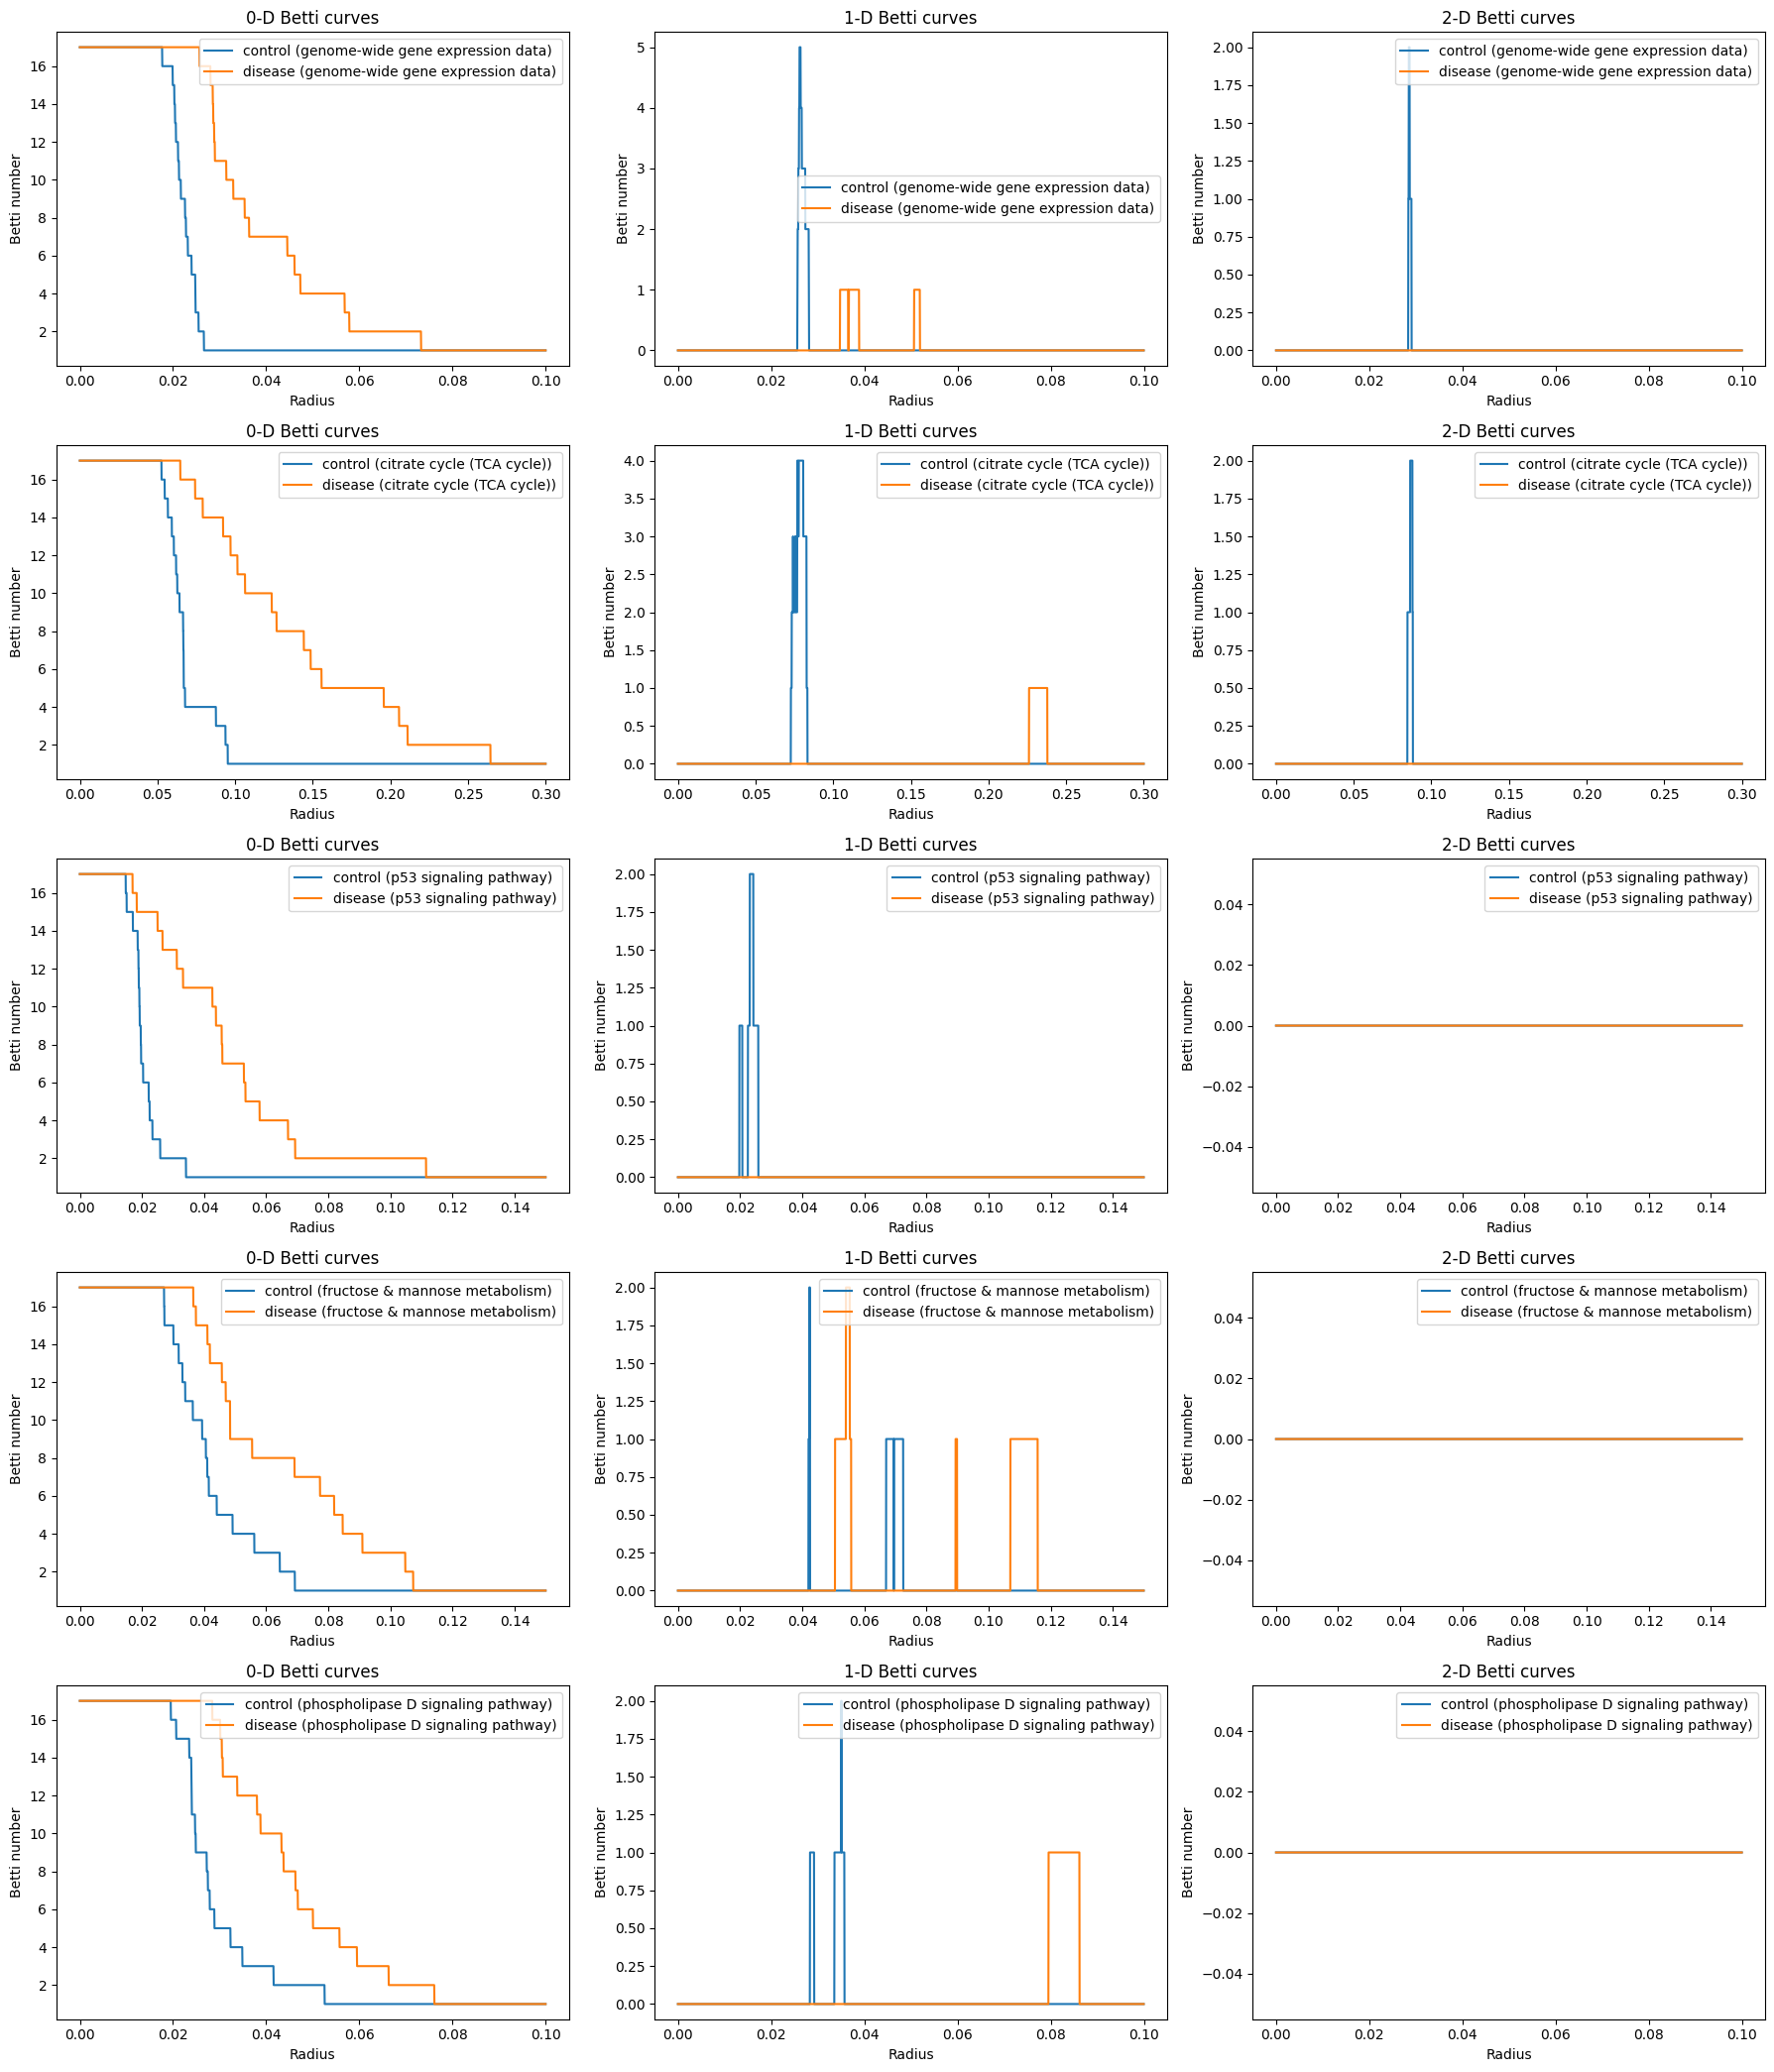

In [70]:
#Plot the Betti curves
dimensions = [0, 1, 2]

# Create a figure with 2 rows and 3 columns
plt.figure(figsize=(18, 21))

# Plot data for each dimension
for i, ndim in enumerate(dimensions):
    # First row
    plt.subplot(5, 3, i + 1)
    for name, corr_data in corr_dict_all.items():
        plt.plot(lenses_1, corr_betti[name][ndim], label="{} (genome-wide gene expression data)".format(name))
    
    plt.title("{}-D Betti curves".format(ndim))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.legend()

    # Second row
    plt.subplot(5, 3, i + 4)
    for name, corr_data in corr_dict_tca.items():
        plt.plot(lenses_3, corr_betti_tca[name][ndim], label="{} (citrate cycle (TCA cycle))".format(name))
    
    plt.title("{}-D Betti curves".format(ndim))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.legend()
    
    # Third row
    plt.subplot(5, 3, i + 7)
    for name, corr_data in corr_dict_p53.items():
        plt.plot(lenses_2, corr_betti_p53[name][ndim], label="{} (p53 signaling pathway)".format(name))
    
    plt.title("{}-D Betti curves".format(ndim))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.legend()
    
    # Fourth row
    plt.subplot(5, 3, i + 10)
    for name, corr_data in corr_dict_fructose.items():
        plt.plot(lenses_2, corr_betti_fructose[name][ndim], label="{} (fructose & mannose metabolism)".format(name))
    
    plt.title("{}-D Betti curves".format(ndim))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.legend()
    
    # Fifth row
    plt.subplot(5, 3, i + 13)
    for name, corr_data in corr_dict_phospho.items():
        plt.plot(lenses_1, corr_betti_phospho[name][ndim], label="{} (phospholipase D signaling pathway)".format(name))
    
    plt.title("{}-D Betti curves".format(ndim))
    plt.xlabel("Radius")
    plt.ylabel("Betti number")
    plt.legend()
    
plt.tight_layout() # Ensure subplots don't overlap
plt.show()

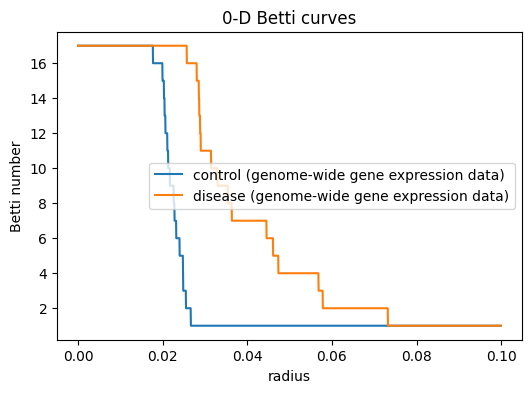

In [71]:
# Genome-wide gene expression data
plt.figure(figsize=(6, 4))
for i, ndim in enumerate(dimensions):
    if i==0:
        for name, corr_data in corr_dict_all.items():
            plt.plot(lenses_1, corr_betti[name][ndim], label="{} (genome-wide gene expression data)".format(name))
    
        plt.title("{}-D Betti curves".format(ndim))
        plt.xlabel("radius")
        plt.ylabel("Betti number")
        plt.legend()

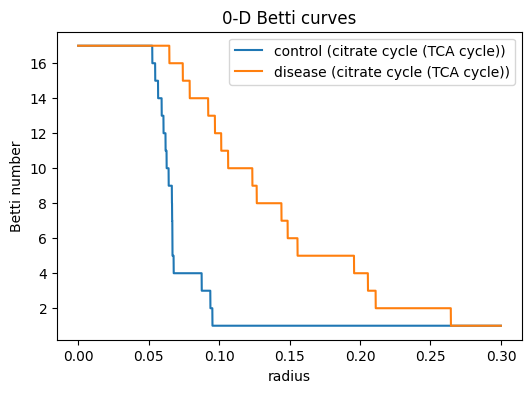

In [72]:
# Citrate cycle (TCA cycle)
plt.figure(figsize=(6, 4))
for i, ndim in enumerate(dimensions):
    if i==0:
        for name, corr_data in corr_dict_tca.items():
            plt.plot(lenses_3, corr_betti_tca[name][ndim], label="{} (citrate cycle (TCA cycle))".format(name))
    
        plt.title("{}-D Betti curves".format(ndim))
        plt.xlabel("radius")
        plt.ylabel("Betti number")
        plt.legend()

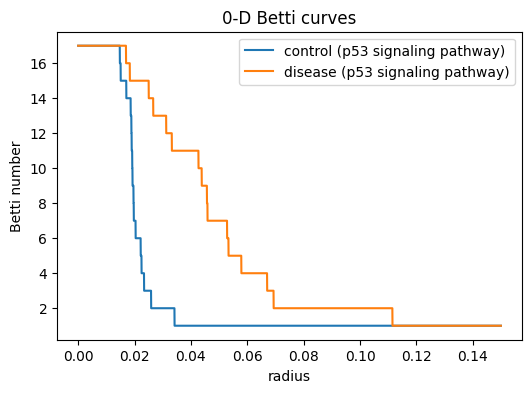

In [73]:
# p53 signaling pathway
plt.figure(figsize=(6, 4))
for i, ndim in enumerate(dimensions):
    if i==0:
        for name, corr_data in corr_dict_p53.items():
            plt.plot(lenses_2, corr_betti_p53[name][ndim], label="{} (p53 signaling pathway)".format(name))
    
        plt.title("{}-D Betti curves".format(ndim))
        plt.xlabel("radius")
        plt.ylabel("Betti number")
        plt.legend()

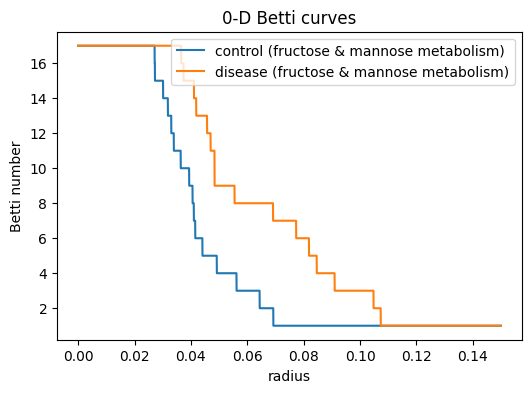

In [74]:
# Fructose & mannose metabolism
plt.figure(figsize=(6, 4))
for i, ndim in enumerate(dimensions):
    if i==0:
       # plt.subplot(5, 3, i+1)
        for name, corr_data in corr_dict_fructose.items():
            plt.plot(lenses_2, corr_betti_fructose[name][ndim], label="{} (fructose & mannose metabolism)".format(name))
    
        plt.title("{}-D Betti curves".format(ndim))
        plt.xlabel("radius")
        plt.ylabel("Betti number")
        plt.legend()

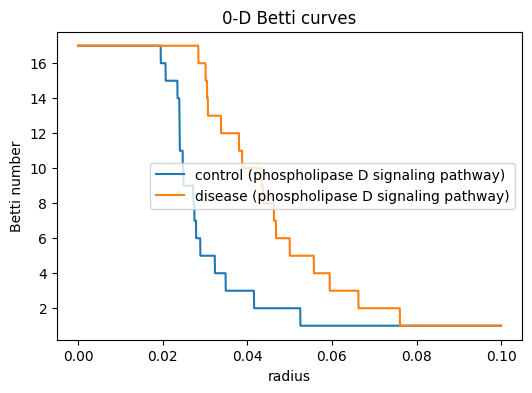

In [344]:
# Phospholipase D signaling pathway
plt.figure(figsize=(6, 4))
for i, ndim in enumerate(dimensions):
    if i==0:
        for name, corr_data in corr_dict_phospho.items():
            plt.plot(lenses_1, corr_betti_phospho[name][ndim], label="{} (phospholipase D signaling pathway)".format(name))
    
        plt.title("{}-D Betti curves".format(ndim))
        plt.xlabel("radius")
        plt.ylabel("Betti number")
        plt.legend()

### Topological Descriptors
#### Euler Characteristics, Sum of deaths, births, and persistence. Max. persistence, range persistence, and averages
##### (Control and HCC classes for whole (genome-wide gene expression) and some selected pathway-specific datasets)

In [76]:
d = {
    'Data': ['whole_control', 'whole_disease', 'TCA_control', 'TCA_disease', 'fructose_control', 'fructose_disease', 
             'PLD_control', 'PLD_disease', 'p53_control', 'p53_disease'], 
    'Classical EC': [],
    'Persistence EC': [],
    'Sum P-0': [],
    'Average P-0': [],
    'Max P-0': [],
    'Range P-0': [],
    'Sum P-1': [],
    'Average P-1': [],
    'Max P-1': [],
    'Range P-1': [],
    'Sum BT-1': [],
    'Average BT-1': [],
    'Sum DT-1': [],
    'Average DT-1': [],
    'Sum P-2': [],
    'Average P-2': [],
    'Max P-2': [],
    'Range P-2': [],
    'Sum BT-2': [],
    'Average BT-2': [],
    'Sum DT-2': [],
    'Average DT-2': []
}

diagrams = [cPD_SC, cPD_SH, PD_tca_c, PD_tca_d, PD_fructose_c, PD_fructose_d, PD_phospho_c, PD_phospho_d, PD_p53_c, PD_p53_d] 

for item in diagrams:
    d['Classical EC'].append(fx.euler_characteristic(item))
    p_euler = fx.sum_persistence(item, 0) - fx.sum_persistence(item, 1) + fx.sum_persistence(item, 2)
    d['Persistence EC'].append(p_euler)
    d['Sum P-0'].append(fx.sum_persistence(item, 0))
    s0p = fx.sum_persistence(item, 0)
    d['Average P-0'].append(s0p / (fx.number_features(item, 0)) if fx.number_features(item, 0) != 0 else 0)
    d['Max P-0'].append(fx.max_persistence(item, 0))
    d['Range P-0'].append(fx.max_persistence(item, 0) - fx.min_persistence(item, 0))
    d['Sum P-1'].append(fx.sum_persistence(item,1))
    s1p = fx.sum_persistence(item, 1)
    d['Average P-1'].append(s1p / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Max P-1'].append(fx.max_persistence(item, 1))
    d['Range P-1'].append(fx.max_persistence(item, 1) - fx.min_persistence(item, 1))
    d['Sum BT-1'].append(fx.sum_birth(item, 1))
    s1b = fx.sum_birth(item, 1)
    d['Average BT-1'].append(s1b / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum DT-1'].append(fx.sum_death(item, 1))
    s1d = fx.sum_death(item, 1)
    d['Average DT-1'].append(s1d / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum P-2'].append(fx.sum_persistence(item, 2))
    s2p = fx.sum_persistence(item, 2)
    d['Average P-2'].append(s2p / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Max P-2'].append(fx.max_persistence(item, 2))
    d['Range P-2'].append(fx.max_persistence(item, 2) - fx.min_persistence(item, 2))
    d['Sum BT-2'].append(fx.sum_birth(item,2))
    s2b = fx.sum_birth(item, 2)
    d['Average BT-2'].append(s2b / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Sum DT-2'].append(fx.sum_death(item,2))
    s2d = fx.sum_death(item, 2)
    d['Average DT-2'].append(s2d / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    
d = pd.DataFrame(d).round(4)
d

Data  Classical EC  Persistence EC  Sum P-0  Average P-0  \
0     whole_control            14          0.3509   0.3573       0.0210   
1     whole_disease            14          0.6252   0.6305       0.0371   
2       TCA_control            12          1.0582   1.0836       0.0637   
3       TCA_disease            16          2.1789   2.1906       0.1289   
4  fructose_control            13          0.6590   0.6652       0.0391   
5  fructose_disease            13          1.0020   1.0178       0.0599   
6       PLD_control            14          0.4548   0.4579       0.0269   
7       PLD_disease            16          0.7112   0.7178       0.0422   
8       p53_control            14          0.3242   0.3296       0.0194   
9       p53_disease            17          0.7413   0.7413       0.0436   

   Max P-0  Range P-0  Sum P-1  Average P-1  Max P-1  ...  Sum DT-1  \
0   0.0266     0.0089   0.0072       0.0014   0.0025  ...    0.1364   
1   0.0732     0.0475   0.0052       0.0017   0.0022  ...    0.1274   
2   0.0952     0.0427   0.0304       0.0043   0.0107  ...    0.5571   
3   0.2644     0.1998   0.0118       0.0118   0.0118  ...    0.2379   
4   0.0692     0.0421   0.0062       0.0015   0.0030  ...    0.2271   
5   0.1073     0.0708   0.0159       0.0040   0.0088  ...    0.3169   
6   0.0525     0.0330   0.0031       0.0010   0.0022  ...    0.1001   
7   0.0761     0.0476   0.0067       0.0067   0.0067  ...    0.0862   
8   0.0342     0.0194   0.0054       0.0018   0.0027  ...    0.0709   
9   0.1115     0.0945   0.0000       0.0000   0.0000  ...    0.0000   

   Average DT-1  Sum P-2  Average P-2  Max P-2  Range P-2  Sum BT-2  \
0        0.0273   0.0008       0.0004   0.0006     0.0003    0.0569   
1        0.0425   0.0000       0.0000   0.0000     0.0000    0.0000   
2        0.0796   0.0050       0.0025   0.0035     0.0020    0.1709   
3        0.2379   0.0000       0.0000   0.0000     0.0000    0.0000   
4        0.0568   0.0000       0.0000   0.0000     0.0000    0.0000   
5        0.0792   0.0000       0.0000   0.0000     0.0000    0.0000   
6        0.0334   0.0000       0.0000   0.0000     0.0000    0.0000   
7        0.0862   0.0000       0.0000   0.0000     0.0000    0.0000   
8        0.0236   0.0000       0.0000   0.0000     0.0000    0.0000   
9        0.0000   0.0000       0.0000   0.0000     0.0000    0.0000   

   Average BT-2  Sum DT-2  Average DT-2  
0        0.0284    0.0577        0.0289  
1        0.0000    0.0000        0.0000  
2        0.0855    0.1759        0.0880  
3        0.0000    0.0000        0.0000  
4        0.0000    0.0000        0.0000  
5        0.0000    0.0000        0.0000  
6        0.0000    0.0000        0.0000  
7        0.0000    0.0000        0.0000  
8        0.0000    0.0000        0.0000  
9        0.0000    0.0000        0.0000  

[10 rows x 23 columns]

In [77]:
# Descriptors with contribution by all dimensional features and those based on 0-dimensional features
d0 = d.iloc[:,:7]
d0

Data  Classical EC  Persistence EC  Sum P-0  Average P-0  \
0     whole_control            14          0.3509   0.3573       0.0210   
1     whole_disease            14          0.6252   0.6305       0.0371   
2       TCA_control            12          1.0582   1.0836       0.0637   
3       TCA_disease            16          2.1789   2.1906       0.1289   
4  fructose_control            13          0.6590   0.6652       0.0391   
5  fructose_disease            13          1.0020   1.0178       0.0599   
6       PLD_control            14          0.4548   0.4579       0.0269   
7       PLD_disease            16          0.7112   0.7178       0.0422   
8       p53_control            14          0.3242   0.3296       0.0194   
9       p53_disease            17          0.7413   0.7413       0.0436   

   Max P-0  Range P-0  
0   0.0266     0.0089  
1   0.0732     0.0475  
2   0.0952     0.0427  
3   0.2644     0.1998  
4   0.0692     0.0421  
5   0.1073     0.0708  
6   0.0525     0.0330  
7   0.0761     0.0476  
8   0.0342     0.0194  
9   0.1115     0.0945

In [78]:
# Descriptors with contribution by 1-dimensional features
d1 = d.iloc[:, [0] + list(range(7, 15))] 
d1

Data  Sum P-1  Average P-1  Max P-1  Range P-1  Sum BT-1  \
0     whole_control   0.0072       0.0014   0.0025     0.0020    0.1292   
1     whole_disease   0.0052       0.0017   0.0022     0.0010    0.1221   
2       TCA_control   0.0304       0.0043   0.0107     0.0106    0.5267   
3       TCA_disease   0.0118       0.0118   0.0118     0.0000    0.2261   
4  fructose_control   0.0062       0.0015   0.0030     0.0028    0.2209   
5  fructose_disease   0.0159       0.0040   0.0088     0.0083    0.3010   
6       PLD_control   0.0031       0.0010   0.0022     0.0021    0.0969   
7       PLD_disease   0.0067       0.0067   0.0067     0.0000    0.0795   
8       p53_control   0.0054       0.0018   0.0027     0.0018    0.0655   
9       p53_disease   0.0000       0.0000   0.0000     0.0000    0.0000   

   Average BT-1  Sum DT-1  Average DT-1  
0        0.0258    0.1364        0.0273  
1        0.0407    0.1274        0.0425  
2        0.0752    0.5571        0.0796  
3        0.2261    0.2379        0.2379  
4        0.0552    0.2271        0.0568  
5        0.0752    0.3169        0.0792  
6        0.0323    0.1001        0.0334  
7        0.0795    0.0862        0.0862  
8        0.0218    0.0709        0.0236  
9        0.0000    0.0000        0.0000

In [79]:
# Descriptors with contribution by 2-dimensional features
d2 = d.iloc[:, [0] + list(range(15, d.shape[1]))]
d2

Data  Sum P-2  Average P-2  Max P-2  Range P-2  Sum BT-2  \
0     whole_control   0.0008       0.0004   0.0006     0.0003    0.0569   
1     whole_disease   0.0000       0.0000   0.0000     0.0000    0.0000   
2       TCA_control   0.0050       0.0025   0.0035     0.0020    0.1709   
3       TCA_disease   0.0000       0.0000   0.0000     0.0000    0.0000   
4  fructose_control   0.0000       0.0000   0.0000     0.0000    0.0000   
5  fructose_disease   0.0000       0.0000   0.0000     0.0000    0.0000   
6       PLD_control   0.0000       0.0000   0.0000     0.0000    0.0000   
7       PLD_disease   0.0000       0.0000   0.0000     0.0000    0.0000   
8       p53_control   0.0000       0.0000   0.0000     0.0000    0.0000   
9       p53_disease   0.0000       0.0000   0.0000     0.0000    0.0000   

   Average BT-2  Sum DT-2  Average DT-2  
0        0.0284    0.0577        0.0289  
1        0.0000    0.0000        0.0000  
2        0.0855    0.1759        0.0880  
3        0.0000    0.0000        0.0000  
4        0.0000    0.0000        0.0000  
5        0.0000    0.0000        0.0000  
6        0.0000    0.0000        0.0000  
7        0.0000    0.0000        0.0000  
8        0.0000    0.0000        0.0000  
9        0.0000    0.0000        0.0000

In [80]:
# Separate the Difference for All 'da' and Difference for HCC pathway 'dh' from the Difference 'd' dataframe above
d_all = d.iloc[:2]
d_tca = d.iloc[2:4]
d_fruc = d.iloc[4:6]
d_phos = d.iloc[6:8]
d_p53 = d.iloc[8:]

In [91]:
diff_all = d_all.T
diff_all.columns = diff_all.iloc[0]
diff_all = diff_all[1:]

diff_all['Diff (H-C)'] = diff_all.iloc[:,1] - diff_all.iloc[:,0]
    
diff_all

Data           whole_control whole_disease Diff (H-C)
Classical EC              14            14          0
Persistence EC        0.3509        0.6252     0.2743
Sum P-0               0.3573        0.6305     0.2732
Average P-0            0.021        0.0371     0.0161
Max P-0               0.0266        0.0732     0.0466
Range P-0             0.0089        0.0475     0.0386
Sum P-1               0.0072        0.0052     -0.002
Average P-1           0.0014        0.0017     0.0003
Max P-1               0.0025        0.0022    -0.0003
Range P-1              0.002         0.001     -0.001
Sum BT-1              0.1292        0.1221    -0.0071
Average BT-1          0.0258        0.0407     0.0149
Sum DT-1              0.1364        0.1274     -0.009
Average DT-1          0.0273        0.0425     0.0152
Sum P-2               0.0008           0.0    -0.0008
Average P-2           0.0004           0.0    -0.0004
Max P-2               0.0006           0.0    -0.0006
Range P-2             0.0003           0.0    -0.0003
Sum BT-2              0.0569           0.0    -0.0569
Average BT-2          0.0284           0.0    -0.0284
Sum DT-2              0.0577           0.0    -0.0577
Average DT-2          0.0289           0.0    -0.0289

In [94]:
pos = [ind for ind in diff_all.index if diff_all.loc[ind, 'Diff (H-C)'] > 0]
neg = [ind for ind in diff_all.index if diff_all.loc[ind, 'Diff (H-C)'] < 0]
eq = [ind for ind in diff_all.index if diff_all.loc[ind, 'Diff (H-C)'] == 0]
print("Descriptors with positive difference:", pos)
print("\nDescriptors with negative difference:", neg)
print("\nDescriptor with zero difference:", eq)

Descriptors with positive difference: ['Persistence EC', 'Sum P-0', 'Average P-0', 'Max P-0', 'Range P-0', 'Average P-1', 'Average BT-1', 'Average DT-1']

Descriptors with negative difference: ['Sum P-1', 'Max P-1', 'Range P-1', 'Sum BT-1', 'Sum DT-1', 'Sum P-2', 'Average P-2', 'Max P-2', 'Range P-2', 'Sum BT-2', 'Average BT-2', 'Sum DT-2', 'Average DT-2']

Descriptor with zero difference: ['Classical EC']


In [95]:
diff_tca = d_tca.T
diff_tca.columns = diff_tca.iloc[0]
diff_tca = diff_tca[1:]

diff_tca['Diff (H-C)'] = diff_tca.iloc[:,1] - diff_tca.iloc[:,0]
    
diff_tca

Data           TCA_control TCA_disease Diff (H-C)
Classical EC            12          16          4
Persistence EC      1.0582      2.1789     1.1207
Sum P-0             1.0836      2.1906      1.107
Average P-0         0.0637      0.1289     0.0652
Max P-0             0.0952      0.2644     0.1692
Range P-0           0.0427      0.1998     0.1571
Sum P-1             0.0304      0.0118    -0.0186
Average P-1         0.0043      0.0118     0.0075
Max P-1             0.0107      0.0118     0.0011
Range P-1           0.0106         0.0    -0.0106
Sum BT-1            0.5267      0.2261    -0.3006
Average BT-1        0.0752      0.2261     0.1509
Sum DT-1            0.5571      0.2379    -0.3192
Average DT-1        0.0796      0.2379     0.1583
Sum P-2              0.005         0.0     -0.005
Average P-2         0.0025         0.0    -0.0025
Max P-2             0.0035         0.0    -0.0035
Range P-2            0.002         0.0     -0.002
Sum BT-2            0.1709         0.0    -0.1709
Average BT-2        0.0855         0.0    -0.0855
Sum DT-2            0.1759         0.0    -0.1759
Average DT-2         0.088         0.0     -0.088

In [97]:
diff_fruc = d_fruc.T
diff_fruc.columns = diff_fruc.iloc[0]
diff_fruc = diff_fruc[1:]

diff_fruc['Diff (H-C)'] = diff_fruc.iloc[:,1] - diff_fruc.iloc[:,0]
    
diff_fruc

Data           fructose_control fructose_disease Diff (H-C)
Classical EC                 13               13          0
Persistence EC            0.659            1.002      0.343
Sum P-0                  0.6652           1.0178     0.3526
Average P-0              0.0391           0.0599     0.0208
Max P-0                  0.0692           0.1073     0.0381
Range P-0                0.0421           0.0708     0.0287
Sum P-1                  0.0062           0.0159     0.0097
Average P-1              0.0015            0.004     0.0025
Max P-1                   0.003           0.0088     0.0058
Range P-1                0.0028           0.0083     0.0055
Sum BT-1                 0.2209            0.301     0.0801
Average BT-1             0.0552           0.0752       0.02
Sum DT-1                 0.2271           0.3169     0.0898
Average DT-1             0.0568           0.0792     0.0224
Sum P-2                     0.0              0.0        0.0
Average P-2                 0.0              0.0        0.0
Max P-2                     0.0              0.0        0.0
Range P-2                   0.0              0.0        0.0
Sum BT-2                    0.0              0.0        0.0
Average BT-2                0.0              0.0        0.0
Sum DT-2                    0.0              0.0        0.0
Average DT-2                0.0              0.0        0.0

In [98]:
diff_phos = d_phos.T
diff_phos.columns = diff_phos.iloc[0]
diff_phos = diff_phos[1:]

diff_phos['Diff (H-C)'] = diff_phos.iloc[:,1] - diff_phos.iloc[:,0]
    
diff_phos

Data           PLD_control PLD_disease Diff (H-C)
Classical EC            14          16          2
Persistence EC      0.4548      0.7112     0.2564
Sum P-0             0.4579      0.7178     0.2599
Average P-0         0.0269      0.0422     0.0153
Max P-0             0.0525      0.0761     0.0236
Range P-0            0.033      0.0476     0.0146
Sum P-1             0.0031      0.0067     0.0036
Average P-1          0.001      0.0067     0.0057
Max P-1             0.0022      0.0067     0.0045
Range P-1           0.0021         0.0    -0.0021
Sum BT-1            0.0969      0.0795    -0.0174
Average BT-1        0.0323      0.0795     0.0472
Sum DT-1            0.1001      0.0862    -0.0139
Average DT-1        0.0334      0.0862     0.0528
Sum P-2                0.0         0.0        0.0
Average P-2            0.0         0.0        0.0
Max P-2                0.0         0.0        0.0
Range P-2              0.0         0.0        0.0
Sum BT-2               0.0         0.0        0.0
Average BT-2           0.0         0.0        0.0
Sum DT-2               0.0         0.0        0.0
Average DT-2           0.0         0.0        0.0

In [99]:
diff_p53 = d_p53.T
diff_p53.columns = diff_p53.iloc[0]
diff_p53 = diff_p53[1:]

diff_p53['Diff (H-C)'] = diff_p53.iloc[:,1] - diff_p53.iloc[:,0]
    
diff_p53

Data           p53_control p53_disease Diff (H-C)
Classical EC            14          17          3
Persistence EC      0.3242      0.7413     0.4171
Sum P-0             0.3296      0.7413     0.4117
Average P-0         0.0194      0.0436     0.0242
Max P-0             0.0342      0.1115     0.0773
Range P-0           0.0194      0.0945     0.0751
Sum P-1             0.0054         0.0    -0.0054
Average P-1         0.0018         0.0    -0.0018
Max P-1             0.0027         0.0    -0.0027
Range P-1           0.0018         0.0    -0.0018
Sum BT-1            0.0655         0.0    -0.0655
Average BT-1        0.0218         0.0    -0.0218
Sum DT-1            0.0709         0.0    -0.0709
Average DT-1        0.0236         0.0    -0.0236
Sum P-2                0.0         0.0        0.0
Average P-2            0.0         0.0        0.0
Max P-2                0.0         0.0        0.0
Range P-2              0.0         0.0        0.0
Sum BT-2               0.0         0.0        0.0
Average BT-2           0.0         0.0        0.0
Sum DT-2               0.0         0.0        0.0
Average DT-2           0.0         0.0        0.0

#### Summary for the differences beween disease and control classes for the whole data and some selected pathway-specific datasets

In [101]:
diff = {
    'Diff(H-C) - whole': diff_all.iloc[:, 2],
    'Diff(H-C) - TCA': diff_tca.iloc[:, 2],
    'Diff(H-C) - fructose': diff_fruc.iloc[:, 2],
    'Diff(H-C) - phospholipase-D': diff_phos.iloc[:, 2],
    'Diff(H-C) - p53': diff_p53.iloc[:, 2]
}

diff = pd.DataFrame(diff)
diff

Diff(H-C) - whole Diff(H-C) - TCA Diff(H-C) - fructose  \
Classical EC                   0               4                    0   
Persistence EC            0.2743          1.1207                0.343   
Sum P-0                   0.2732           1.107               0.3526   
Average P-0               0.0161          0.0652               0.0208   
Max P-0                   0.0466          0.1692               0.0381   
Range P-0                 0.0386          0.1571               0.0287   
Sum P-1                   -0.002         -0.0186               0.0097   
Average P-1               0.0003          0.0075               0.0025   
Max P-1                  -0.0003          0.0011               0.0058   
Range P-1                 -0.001         -0.0106               0.0055   
Sum BT-1                 -0.0071         -0.3006               0.0801   
Average BT-1              0.0149          0.1509                 0.02   
Sum DT-1                  -0.009         -0.3192               0.0898   
Average DT-1              0.0152          0.1583               0.0224   
Sum P-2                  -0.0008          -0.005                  0.0   
Average P-2              -0.0004         -0.0025                  0.0   
Max P-2                  -0.0006         -0.0035                  0.0   
Range P-2                -0.0003          -0.002                  0.0   
Sum BT-2                 -0.0569         -0.1709                  0.0   
Average BT-2             -0.0284         -0.0855                  0.0   
Sum DT-2                 -0.0577         -0.1759                  0.0   
Average DT-2             -0.0289          -0.088                  0.0   

               Diff(H-C) - phospholipase-D Diff(H-C) - p53  
Classical EC                             2               3  
Persistence EC                      0.2564          0.4171  
Sum P-0                             0.2599          0.4117  
Average P-0                         0.0153          0.0242  
Max P-0                             0.0236          0.0773  
Range P-0                           0.0146          0.0751  
Sum P-1                             0.0036         -0.0054  
Average P-1                         0.0057         -0.0018  
Max P-1                             0.0045         -0.0027  
Range P-1                          -0.0021         -0.0018  
Sum BT-1                           -0.0174         -0.0655  
Average BT-1                        0.0472         -0.0218  
Sum DT-1                           -0.0139         -0.0709  
Average DT-1                        0.0528         -0.0236  
Sum P-2                                0.0             0.0  
Average P-2                            0.0             0.0  
Max P-2                                0.0             0.0  
Range P-2                              0.0             0.0  
Sum BT-2                               0.0             0.0  
Average BT-2                           0.0             0.0  
Sum DT-2                               0.0             0.0  
Average DT-2                           0.0             0.0

#### Difference beween the difference of ALL genes and that of only those genes in HCC pathways

In [102]:
diff_diff = {
    'Diff(H-C) - TCA': diff_tca.iloc[:, 2] - diff_all.iloc[:, 2],
    'Diff(H-C) - fructose': diff_fruc.iloc[:, 2] - diff_all.iloc[:, 2],
    'Diff(H-C) - phospolipase-D': diff_phos.iloc[:, 2] - diff_all.iloc[:, 2],
    'Diff(H-C) - p53': diff_p53.iloc[:, 2] - diff_all.iloc[:, 2]
}

diff_diff = pd.DataFrame(diff_diff)
diff_diff

Diff(H-C) - TCA Diff(H-C) - fructose  \
Classical EC                 4                    0   
Persistence EC          0.8464               0.0687   
Sum P-0                 0.8338               0.0794   
Average P-0             0.0491               0.0047   
Max P-0                 0.1226              -0.0085   
Range P-0               0.1185              -0.0099   
Sum P-1                -0.0166               0.0117   
Average P-1             0.0072               0.0022   
Max P-1                 0.0014               0.0061   
Range P-1              -0.0096               0.0065   
Sum BT-1               -0.2935               0.0872   
Average BT-1             0.136               0.0051   
Sum DT-1               -0.3102               0.0988   
Average DT-1            0.1431               0.0072   
Sum P-2                -0.0042               0.0008   
Average P-2            -0.0021               0.0004   
Max P-2                -0.0029               0.0006   
Range P-2              -0.0017               0.0003   
Sum BT-2                -0.114               0.0569   
Average BT-2           -0.0571               0.0284   
Sum DT-2               -0.1182               0.0577   
Average DT-2           -0.0591               0.0289   

               Diff(H-C) - phospolipase-D Diff(H-C) - p53  
Classical EC                            2               3  
Persistence EC                    -0.0179          0.1428  
Sum P-0                           -0.0133          0.1385  
Average P-0                       -0.0008          0.0081  
Max P-0                            -0.023          0.0307  
Range P-0                          -0.024          0.0365  
Sum P-1                            0.0056         -0.0034  
Average P-1                        0.0054         -0.0021  
Max P-1                            0.0048         -0.0024  
Range P-1                         -0.0011         -0.0008  
Sum BT-1                          -0.0103         -0.0584  
Average BT-1                       0.0323         -0.0367  
Sum DT-1                          -0.0049         -0.0619  
Average DT-1                       0.0376         -0.0388  
Sum P-2                            0.0008          0.0008  
Average P-2                        0.0004          0.0004  
Max P-2                            0.0006          0.0006  
Range P-2                          0.0003          0.0003  
Sum BT-2                           0.0569          0.0569  
Average BT-2                       0.0284          0.0284  
Sum DT-2                           0.0577          0.0577  
Average DT-2                       0.0289          0.0289

###### Plots of some topological descriptors

<Figure size 2000x1200 with 0 Axes>

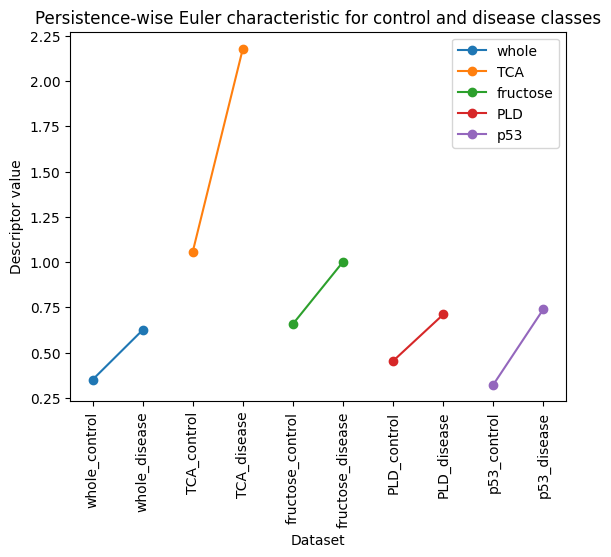

In [118]:
# Assuming 'x_axis' and 'd' are already defined with your data
x_axis = d['Data']
y_values = d['Persistence EC']

segments = []  # Initialize an empty list for segments

# Create segments based on your criteria (e.g., skipping every 3 points)
start = 0
segment_length = 2  #You can adjust this as needed

while start < len(x_axis):
    end = start + segment_length
    if end > len(x_axis):
        end = len(x_axis)
    
    segments.append((start, end))
    start = end

labels = ["whole", "TCA", 'fructose', 'PLD', 'p53']

plt.figure(figsize=(20, 12))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the segments
for (label, (start, end)) in zip(labels, segments):
    ax.plot(x_axis[start:end], y_values[start:end], marker='o', label=label)

# Set labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Descriptor value')
ax.set_title("Persistence-wise Euler characteristic for control and disease classes")
ax.set_xticks(x_axis)
ax.legend()

plt.xticks(rotation=90)
plt.show()


<Figure size 2000x1200 with 0 Axes>

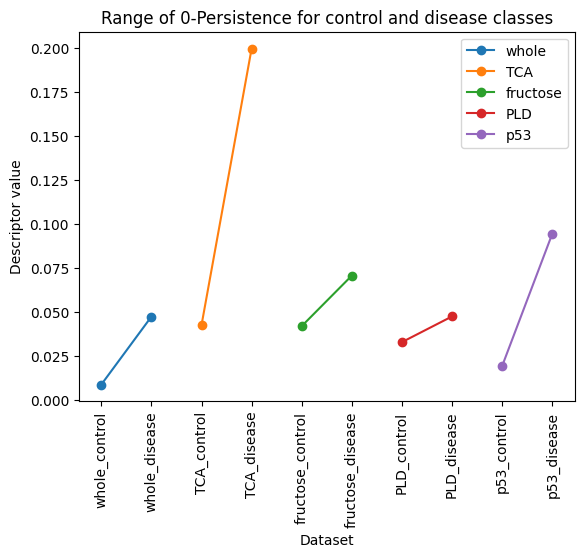

In [119]:
# Assuming 'x_axis' and 'd' are already defined with your data
x_axis = d['Data']
y_values = d['Range P-0']

segments = []  # Initialize an empty list for segments

# Create segments based on your criteria (e.g., skipping every 3 points)
start = 0
segment_length = 2  #You can adjust this as needed

while start < len(x_axis):
    end = start + segment_length
    if end > len(x_axis):
        end = len(x_axis)
    
    segments.append((start, end))
    start = end

labels = ["whole", "TCA", 'fructose', 'PLD', 'p53']

plt.figure(figsize=(20, 12))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the segments
for (label, (start, end)) in zip(labels, segments):
    ax.plot(x_axis[start:end], y_values[start:end], marker='o', label=label)

# Set labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Descriptor value')
ax.set_title("Range of 0-Persistence for control and disease classes")
ax.set_xticks(x_axis)
ax.legend()

plt.xticks(rotation=90)
plt.show()

<Figure size 2000x1200 with 0 Axes>

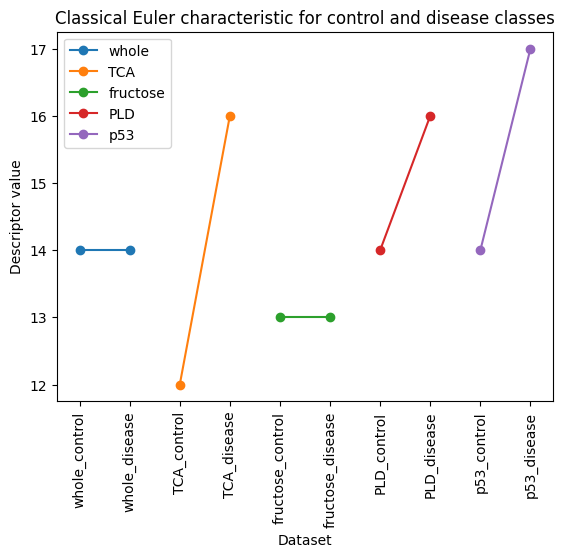

In [120]:
# Assuming 'x_axis' and 'd' are already defined with your data
x_axis = d['Data']
y_values = d['Classical EC']

segments = []  # Initialize an empty list for segments

# Create segments based on your criteria (e.g., skipping every 3 points)
start = 0
segment_length = 2  #You can adjust this as needed

while start < len(x_axis):
    end = start + segment_length
    if end > len(x_axis):
        end = len(x_axis)
    
    segments.append((start, end))
    start = end

labels = ["whole", "TCA", 'fructose', 'PLD', 'p53']

plt.figure(figsize=(20, 12))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the segments
for (label, (start, end)) in zip(labels, segments):
    ax.plot(x_axis[start:end], y_values[start:end], marker='o', label=label)

# Set labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Descriptor value')
ax.set_title("Classical Euler characteristic for control and disease classes")
ax.set_xticks(x_axis)
ax.legend()

plt.xticks(rotation=90)
plt.show()


##### Control and HCC classes for all KEGG pathway-specific datasets

In [121]:
# 251 KEGG keys (pathway names)
filtered_kegg_keys = kegg_dict.keys()

##### For control samples category

In [122]:
d = {
    'Pathway': filtered_kegg_keys,
    'Classical EC': [],
    'Persistence EC': [],
    'Sum P-0': [],
    'Average P-0': [],
    'Max P-0': [],
    'Range P-0': [],
    'Sum P-1': [],
    'Average P-1': [],
    'Max P-1': [],
    'Range P-1': [],
    'Sum BT-1': [],
    'Average BT-1': [],
    'Sum DT-1': [],
    'Average DT-1': [],
    'Sum P-2': [],
    'Average P-2': [],
    'Max P-2': [],
    'Range P-2': [],
    'Sum BT-2': [],
    'Average BT-2': [],
    'Sum DT-2': [],
    'Average DT-2': []
} 
 
for item in corr_dgms_c.values():
    d['Classical EC'].append(fx.euler_characteristic(item))
    p_euler = fx.sum_persistence(item, 0) - fx.sum_persistence(item, 1) + fx.sum_persistence(item, 2)
    d['Persistence EC'].append(p_euler)
    d['Sum P-0'].append(fx.sum_persistence(item, 0))
    s0p = fx.sum_persistence(item, 0)
    d['Average P-0'].append(s0p / (fx.number_features(item, 0)) if fx.number_features(item, 0) != 0 else 0)
    d['Max P-0'].append(fx.max_persistence(item, 0))
    d['Range P-0'].append(fx.max_persistence(item, 0) - fx.min_persistence(item, 0))
    d['Sum P-1'].append(fx.sum_persistence(item,1))
    s1p = fx.sum_persistence(item, 1)
    d['Average P-1'].append(s1p / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Max P-1'].append(fx.max_persistence(item, 1))
    d['Range P-1'].append(fx.max_persistence(item, 1) - fx.min_persistence(item, 1))
    d['Sum BT-1'].append(fx.sum_birth(item, 1))
    s1b = fx.sum_birth(item, 1)
    d['Average BT-1'].append(s1b / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum DT-1'].append(fx.sum_death(item, 1))
    s1d = fx.sum_death(item, 1)
    d['Average DT-1'].append(s1d / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum P-2'].append(fx.sum_persistence(item, 2))
    s2p = fx.sum_persistence(item, 2)
    d['Average P-2'].append(s2p / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Max P-2'].append(fx.max_persistence(item, 2))
    d['Range P-2'].append(fx.max_persistence(item, 2) - fx.min_persistence(item, 2))
    d['Sum BT-2'].append(fx.sum_birth(item,2))
    s2b = fx.sum_birth(item, 2)
    d['Average BT-2'].append(s2b / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Sum DT-2'].append(fx.sum_death(item,2))
    s2d = fx.sum_death(item, 2)
    d['Average DT-2'].append(s2d / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    
# Make the list a dataframe
td_c = pd.DataFrame(d).round(4)
td_c

Pathway  Classical EC  \
0                       Glycolysis / Gluconeogenesis            15   
1                          Citrate cycle (TCA cycle)            12   
2                          Pentose phosphate pathway            16   
3           Pentose and glucuronate interconversions            13   
4                    Fructose and mannose metabolism            13   
..                                               ...           ...   
246                     Longevity regulating pathway            13   
247  Longevity regulating pathway - multiple species            13   
248                                 Circadian rhythm            14   
249                            Circadian entrainment            13   
250                                    Thermogenesis            15   

     Persistence EC  Sum P-0  Average P-0  Max P-0  Range P-0  Sum P-1  \
0            0.2533   0.2567       0.0151   0.0248     0.0138   0.0034   
1            1.0582   1.0836       0.0637   0.0952     0.0427   0.0304   
2            0.5775   0.5811       0.0342   0.0700     0.0552   0.0036   
3            0.5127   0.5236       0.0308   0.0816     0.0610   0.0109   
4            0.6590   0.6652       0.0391   0.0692     0.0421   0.0062   
..              ...      ...          ...      ...        ...      ...   
246          0.2965   0.3005       0.0177   0.0272     0.0132   0.0040   
247          0.3347   0.3390       0.0199   0.0373     0.0227   0.0046   
248          0.5248   0.5289       0.0311   0.0586     0.0363   0.0041   
249          0.2917   0.2938       0.0173   0.0257     0.0113   0.0030   
250          0.3124   0.3154       0.0186   0.0239     0.0080   0.0030   

     Average P-1  Max P-1  ...  Sum DT-1  Average DT-1  Sum P-2  Average P-2  \
0         0.0017   0.0019  ...    0.0414        0.0207   0.0000       0.0000   
1         0.0043   0.0107  ...    0.5571        0.0796   0.0050       0.0025   
2         0.0036   0.0036  ...    0.0510        0.0510   0.0000       0.0000   
3         0.0027   0.0046  ...    0.1474        0.0368   0.0000       0.0000   
4         0.0015   0.0030  ...    0.2271        0.0568   0.0000       0.0000   
..           ...      ...  ...       ...           ...      ...          ...   
246       0.0010   0.0029  ...    0.0872        0.0218   0.0000       0.0000   
247       0.0009   0.0035  ...    0.1273        0.0255   0.0002       0.0002   
248       0.0014   0.0017  ...    0.1286        0.0429   0.0000       0.0000   
249       0.0006   0.0016  ...    0.1087        0.0217   0.0010       0.0010   
250       0.0015   0.0027  ...    0.0482        0.0241   0.0000       0.0000   

     Max P-2  Range P-2  Sum BT-2  Average BT-2  Sum DT-2  Average DT-2  
0     0.0000      0.000    0.0000        0.0000    0.0000         0.000  
1     0.0035      0.002    0.1709        0.0855    0.1759         0.088  
2     0.0000      0.000    0.0000        0.0000    0.0000         0.000  
3     0.0000      0.000    0.0000        0.0000    0.0000         0.000  
4     0.0000      0.000    0.0000        0.0000    0.0000         0.000  
..       ...        ...       ...           ...       ...           ...  
246   0.0000      0.000    0.0000        0.0000    0.0000         0.000  
247   0.0002      0.000    0.0278        0.0278    0.0280         0.028  
248   0.0000      0.000    0.0000        0.0000    0.0000         0.000  
249   0.0010      0.000    0.0231        0.0231    0.0240         0.024  
250   0.0000      0.000    0.0000        0.0000    0.0000         0.000  

[251 rows x 23 columns]

##### For disease samples category

In [123]:
d = {
    'Pathway': filtered_kegg_keys,
    'Classical EC': [],
    'Persistence EC': [],
    'Sum P-0': [],
    'Average P-0': [],
    'Max P-0': [],
    'Range P-0': [],
    'Sum P-1': [],
    'Average P-1': [],
    'Max P-1': [],
    'Range P-1': [],
    'Sum BT-1': [],
    'Average BT-1': [],
    'Sum DT-1': [],
    'Average DT-1': [],
    'Sum P-2': [],
    'Average P-2': [],
    'Max P-2': [],
    'Range P-2': [],
    'Sum BT-2': [],
    'Average BT-2': [],
    'Sum DT-2': [],
    'Average DT-2': []
} 

for item in corr_dgms_d.values():
    d['Classical EC'].append(fx.euler_characteristic(item))
    p_euler = fx.sum_persistence(item, 0) - fx.sum_persistence(item, 1) + fx.sum_persistence(item, 2)
    d['Persistence EC'].append(p_euler)
    d['Sum P-0'].append(fx.sum_persistence(item, 0))
    s0p = fx.sum_persistence(item, 0)
    d['Average P-0'].append(s0p / (fx.number_features(item, 0)) if fx.number_features(item, 0) != 0 else 0)
    d['Max P-0'].append(fx.max_persistence(item, 0))
    d['Range P-0'].append(fx.max_persistence(item, 0) - fx.min_persistence(item, 0))
    d['Sum P-1'].append(fx.sum_persistence(item,1))
    s1p = fx.sum_persistence(item, 1)
    d['Average P-1'].append(s1p / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Max P-1'].append(fx.max_persistence(item, 1))
    d['Range P-1'].append(fx.max_persistence(item, 1) - fx.min_persistence(item, 1))
    d['Sum BT-1'].append(fx.sum_birth(item, 1))
    s1b = fx.sum_birth(item, 1)
    d['Average BT-1'].append(s1b / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum DT-1'].append(fx.sum_death(item, 1))
    s1d = fx.sum_death(item, 1)
    d['Average DT-1'].append(s1d / (fx.number_features(item, 1)) if fx.number_features(item, 1) != 0 else 0)
    d['Sum P-2'].append(fx.sum_persistence(item, 2))
    s2p = fx.sum_persistence(item, 2)
    d['Average P-2'].append(s2p / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Max P-2'].append(fx.max_persistence(item, 2))
    d['Range P-2'].append(fx.max_persistence(item, 2) - fx.min_persistence(item, 2))
    d['Sum BT-2'].append(fx.sum_birth(item,2))
    s2b = fx.sum_birth(item, 2)
    d['Average BT-2'].append(s2b / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
    d['Sum DT-2'].append(fx.sum_death(item,2))
    s2d = fx.sum_death(item, 2)
    d['Average DT-2'].append(s2d / (fx.number_features(item, 2)) if fx.number_features(item, 2) != 0 else 0)
        
# Make the list a dataframe
td_d = pd.DataFrame(d).round(4)
td_d

Pathway  Classical EC  \
0                       Glycolysis / Gluconeogenesis            16   
1                          Citrate cycle (TCA cycle)            16   
2                          Pentose phosphate pathway            17   
3           Pentose and glucuronate interconversions            15   
4                    Fructose and mannose metabolism            13   
..                                               ...           ...   
246                     Longevity regulating pathway            17   
247  Longevity regulating pathway - multiple species            15   
248                                 Circadian rhythm            15   
249                            Circadian entrainment            15   
250                                    Thermogenesis            14   

     Persistence EC  Sum P-0  Average P-0  Max P-0  Range P-0  Sum P-1  \
0            0.5817   0.5848       0.0344   0.0838     0.0668   0.0030   
1            2.1789   2.1906       0.1289   0.2644     0.1998   0.0118   
2            1.0531   1.0531       0.0619   0.1779     0.1394   0.0000   
3            1.0895   1.0943       0.0644   0.1629     0.1326   0.0048   
4            1.0020   1.0178       0.0599   0.1073     0.0708   0.0159   
..              ...      ...          ...      ...        ...      ...   
246          0.7434   0.7434       0.0437   0.0927     0.0677   0.0000   
247          0.7340   0.7445       0.0438   0.1134     0.0961   0.0104   
248          1.1474   1.1651       0.0685   0.1659     0.1342   0.0178   
249          0.5374   0.5387       0.0317   0.0830     0.0674   0.0013   
250          0.5718   0.5735       0.0337   0.0697     0.0511   0.0017   

     Average P-1  Max P-1  ...  Sum DT-1  Average DT-1  Sum P-2  Average P-2  \
0         0.0030   0.0030  ...    0.0804        0.0804      0.0          0.0   
1         0.0118   0.0118  ...    0.2379        0.2379      0.0          0.0   
2         0.0000   0.0000  ...    0.0000        0.0000      0.0          0.0   
3         0.0024   0.0044  ...    0.1849        0.0924      0.0          0.0   
4         0.0040   0.0088  ...    0.3169        0.0792      0.0          0.0   
..           ...      ...  ...       ...           ...      ...          ...   
246       0.0000   0.0000  ...    0.0000        0.0000      0.0          0.0   
247       0.0052   0.0089  ...    0.1192        0.0596      0.0          0.0   
248       0.0089   0.0124  ...    0.2143        0.1071      0.0          0.0   
249       0.0007   0.0010  ...    0.0854        0.0427      0.0          0.0   
250       0.0006   0.0008  ...    0.1000        0.0333      0.0          0.0   

     Max P-2  Range P-2  Sum BT-2  Average BT-2  Sum DT-2  Average DT-2  
0        0.0        0.0       0.0           0.0       0.0           0.0  
1        0.0        0.0       0.0           0.0       0.0           0.0  
2        0.0        0.0       0.0           0.0       0.0           0.0  
3        0.0        0.0       0.0           0.0       0.0           0.0  
4        0.0        0.0       0.0           0.0       0.0           0.0  
..       ...        ...       ...           ...       ...           ...  
246      0.0        0.0       0.0           0.0       0.0           0.0  
247      0.0        0.0       0.0           0.0       0.0           0.0  
248      0.0        0.0       0.0           0.0       0.0           0.0  
249      0.0        0.0       0.0           0.0       0.0           0.0  
250      0.0        0.0       0.0           0.0       0.0           0.0  

[251 rows x 23 columns]

##### Difference between topological features in control samples and disease samples categories

In [126]:
diff_td = {
    'Pathway': filtered_kegg_keys,
}

ntd_c = td_c.drop('Pathway', axis=1)
ntd_d = td_d.drop('Pathway', axis=1)

column_names = ntd_c.columns
for column_name in column_names:
    diff_td[column_name + ' (H-C)'] = []

for i in range(len(filtered_kegg_keys)):
    for column_name in column_names:
        diff_td[column_name + ' (H-C)'].append(ntd_d[column_name].loc[i] - ntd_c[column_name].loc[i])

diff_td = pd.DataFrame(diff_td)
diff_td

Pathway  Classical EC (H-C)  \
0                       Glycolysis / Gluconeogenesis                   1   
1                          Citrate cycle (TCA cycle)                   4   
2                          Pentose phosphate pathway                   1   
3           Pentose and glucuronate interconversions                   2   
4                    Fructose and mannose metabolism                   0   
..                                               ...                 ...   
246                     Longevity regulating pathway                   4   
247  Longevity regulating pathway - multiple species                   2   
248                                 Circadian rhythm                   1   
249                            Circadian entrainment                   2   
250                                    Thermogenesis                  -1   

     Persistence EC (H-C)  Sum P-0 (H-C)  Average P-0 (H-C)  Max P-0 (H-C)  \
0                  0.3284         0.3281             0.0193         0.0590   
1                  1.1207         1.1070             0.0652         0.1692   
2                  0.4756         0.4720             0.0277         0.1079   
3                  0.5768         0.5707             0.0336         0.0813   
4                  0.3430         0.3526             0.0208         0.0381   
..                    ...            ...                ...            ...   
246                0.4469         0.4429             0.0260         0.0655   
247                0.3993         0.4055             0.0239         0.0761   
248                0.6226         0.6362             0.0374         0.1073   
249                0.2457         0.2449             0.0144         0.0573   
250                0.2594         0.2581             0.0151         0.0458   

     Range P-0 (H-C)  Sum P-1 (H-C)  Average P-1 (H-C)  Max P-1 (H-C)  ...  \
0             0.0530        -0.0004             0.0013         0.0011  ...   
1             0.1571        -0.0186             0.0075         0.0011  ...   
2             0.0842        -0.0036            -0.0036        -0.0036  ...   
3             0.0716        -0.0061            -0.0003        -0.0002  ...   
4             0.0287         0.0097             0.0025         0.0058  ...   
..               ...            ...                ...            ...  ...   
246           0.0545        -0.0040            -0.0010        -0.0029  ...   
247           0.0734         0.0058             0.0043         0.0054  ...   
248           0.0979         0.0137             0.0075         0.0107  ...   
249           0.0561        -0.0017             0.0001        -0.0006  ...   
250           0.0431        -0.0013            -0.0009        -0.0019  ...   

     Sum DT-1 (H-C)  Average DT-1 (H-C)  Sum P-2 (H-C)  Average P-2 (H-C)  \
0            0.0390              0.0597         0.0000             0.0000   
1           -0.3192              0.1583        -0.0050            -0.0025   
2           -0.0510             -0.0510         0.0000             0.0000   
3            0.0375              0.0556         0.0000             0.0000   
4            0.0898              0.0224         0.0000             0.0000   
..              ...                 ...            ...                ...   
246         -0.0872             -0.0218         0.0000             0.0000   
247         -0.0081              0.0341        -0.0002            -0.0002   
248          0.0857              0.0642         0.0000             0.0000   
249         -0.0233              0.0210        -0.0010            -0.0010   
250          0.0518              0.0092         0.0000             0.0000   

     Max P-2 (H-C)  Range P-2 (H-C)  Sum BT-2 (H-C)  Average BT-2 (H-C)  \
0           0.0000            0.000          0.0000              0.0000   
1          -0.0035           -0.002         -0.1709             -0.0855   
2           0.0000            0.000          0.0000              0.0000   
3           0.0000            0.0

In [127]:
selected_pathways_diff = diff_td[diff_td['Pathway'].isin(selected_pathways)]
selected_pathways_diff

Pathway  Classical EC (H-C)  \
1            Citrate cycle (TCA cycle)                   4   
4      Fructose and mannose metabolism                   0   
134  Phospholipase D signaling pathway                   2   
159              p53 signaling pathway                   3   

     Persistence EC (H-C)  Sum P-0 (H-C)  Average P-0 (H-C)  Max P-0 (H-C)  \
1                  1.1207         1.1070             0.0652         0.1692   
4                  0.3430         0.3526             0.0208         0.0381   
134                0.2564         0.2599             0.0153         0.0236   
159                0.4171         0.4117             0.0242         0.0773   

     Range P-0 (H-C)  Sum P-1 (H-C)  Average P-1 (H-C)  Max P-1 (H-C)  ...  \
1             0.1571        -0.0186             0.0075         0.0011  ...   
4             0.0287         0.0097             0.0025         0.0058  ...   
134           0.0146         0.0036             0.0057         0.0045  ...   
159           0.0751        -0.0054            -0.0018        -0.0027  ...   

     Sum DT-1 (H-C)  Average DT-1 (H-C)  Sum P-2 (H-C)  Average P-2 (H-C)  \
1           -0.3192              0.1583         -0.005            -0.0025   
4            0.0898              0.0224          0.000             0.0000   
134         -0.0139              0.0528          0.000             0.0000   
159         -0.0709             -0.0236          0.000             0.0000   

     Max P-2 (H-C)  Range P-2 (H-C)  Sum BT-2 (H-C)  Average BT-2 (H-C)  \
1          -0.0035           -0.002         -0.1709             -0.0855   
4           0.0000            0.000          0.0000              0.0000   
134         0.0000            0.000          0.0000              0.0000   
159         0.0000            0.000          0.0000              0.0000   

     Sum DT-2 (H-C)  Average DT-2 (H-C)  
1           -0.1759              -0.088  
4            0.0000               0.000  
134          0.0000               0.000  
159          0.0000               0.000  

[4 rows x 23 columns]

In [128]:
selected_pathways_diff['Persistence EC (H-C)']

1      1.1207
4      0.3430
134    0.2564
159    0.4171
Name: Persistence EC (H-C), dtype: float64

In [130]:
diff_td.loc[tca_index]['Persistence EC (H-C)']

1.1207

In [143]:
# All topological descriptors names, e.g., Sum P-0
topo_descriptors = td_c.iloc[:, 1:].columns.to_list()

# Difference for all topological descriptors, e.g., Sum P-0 (H-C) 
diff_top_desc_all = diff_td.iloc[:, 1:].columns.to_list()

In [145]:
# Pathways with more or less or equal topological descriptors' values
# compared to the values for genome-wide gene expression dataset

paths_vs_all = {
    'Difference': diff_top_desc_all,
    'count_greater': [],
    'count_less': [],
    'count_equal': []
}

dff = diff_all['Diff (H-C)']
for i, descriptor in enumerate(diff_top_desc_all):
    greater = len(diff_td[diff_td[descriptor] > dff.iloc[i]])
    less = len(diff_td[diff_td[descriptor] < dff.iloc[i]])
    equal = len(diff_td[diff_td[descriptor] == dff.iloc[i]])
    paths_vs_all['count_greater'].append(greater)
    paths_vs_all['count_less'].append(less)
    paths_vs_all['count_equal'].append(equal)
    
paths_vs_all = pd.DataFrame(paths_vs_all)
paths_vs_all

Difference  count_greater  count_less  count_equal
0     Classical EC (H-C)            189          23           39
1   Persistence EC (H-C)            155          96            0
2          Sum P-0 (H-C)            155          96            0
3      Average P-0 (H-C)            155          96            0
4          Max P-0 (H-C)            144         107            0
5        Range P-0 (H-C)            153          98            0
6          Sum P-1 (H-C)            135         115            1
7      Average P-1 (H-C)            113         135            3
8          Max P-1 (H-C)            121         128            2
9        Range P-1 (H-C)            127         117            7
10        Sum BT-1 (H-C)            104         147            0
11    Average BT-1 (H-C)            127         124            0
12        Sum DT-1 (H-C)            103         148            0
13    Average DT-1 (H-C)            128         123            0
14         Sum P-2 (H-C)            229          21            1
15     Average P-2 (H-C)            218          29            4
16         Max P-2 (H-C)            221          24            6
17       Range P-2 (H-C)            241           9            1
18        Sum BT-2 (H-C)            242           9            0
19    Average BT-2 (H-C)            220          31            0
20        Sum DT-2 (H-C)            241           9            1
21    Average DT-2 (H-C)            220          31            0

### Permutation test for statistical significance
#### 1. Difference (HCC-Control) against random permutations (genome-wide gene expression) datasets

In [148]:
# Permutations (~ 3 minutes)
import random

start_time = time.time()

random.seed(42) # For reproducivity
num_trials = 2000  # Number of random permutations

trials_diff_EC = np.zeros(num_trials)
trials_diff_PEC = np.zeros(num_trials)
trials_diff_S0P = np.zeros(num_trials)
trials_diff_AS0P = np.zeros(num_trials)
trials_diff_M0P = np.zeros(num_trials)
trials_diff_R0P = np.zeros(num_trials)
trials_diff_S1P = np.zeros(num_trials)
trials_diff_AS1P = np.zeros(num_trials)
trials_diff_M1P = np.zeros(num_trials)
trials_diff_R1P = np.zeros(num_trials)
trials_diff_S1B = np.zeros(num_trials)
trials_diff_AS1B = np.zeros(num_trials)
trials_diff_S1D = np.zeros(num_trials)
trials_diff_AS1D = np.zeros(num_trials)
trials_diff_S2P = np.zeros(num_trials)
trials_diff_AS2P = np.zeros(num_trials)
trials_diff_M2P = np.zeros(num_trials)
trials_diff_R2P = np.zeros(num_trials)
trials_diff_S2B = np.zeros(num_trials)
trials_diff_AS2B = np.zeros(num_trials)
trials_diff_S2D = np.zeros(num_trials)
trials_diff_AS2D = np.zeros(num_trials)

exp_data = df_all # ALL data
num_columns_HCC = df_disease.shape[1]

for i in range(num_trials):
    indices = list(range(exp_data.shape[1]))
    random.shuffle(indices)
    
    disease_trial = exp_data.iloc[:, indices[:num_columns_HCC]]
    control_trial = exp_data.iloc[:, indices[num_columns_HCC:]]
    
    cd_disease_trial = fx.corr_matrix(disease_trial, corr_type="Dissimilarity", by="Sample")
    cd_control_trial = fx.corr_matrix(control_trial, corr_type="Dissimilarity", by="Sample")
    
    disease_persistence_trial = fx.get_persistence_diagram(cd_disease_trial, max_dim=max_dim, edge_length=max_radius)
    control_persistence_trial = fx.get_persistence_diagram(cd_control_trial, max_dim=max_dim, edge_length=max_radius)
    
    p_euler_d = fx.sum_persistence(disease_persistence_trial,0) - fx.sum_persistence(disease_persistence_trial,1) + fx.sum_persistence(disease_persistence_trial,2)
    p_euler_c = fx.sum_persistence(control_persistence_trial,0) - fx.sum_persistence(control_persistence_trial,1) + fx.sum_persistence(control_persistence_trial,2)
    
    maxmin0_d = fx.max_persistence(disease_persistence_trial,0) - fx.min_persistence(disease_persistence_trial,0)
    maxmin0_c = fx.max_persistence(control_persistence_trial,0) - fx.min_persistence(control_persistence_trial,0)
    maxmin1_d = fx.max_persistence(disease_persistence_trial,1) - fx.min_persistence(disease_persistence_trial,1)
    maxmin1_c = fx.max_persistence(control_persistence_trial,1) - fx.min_persistence(control_persistence_trial,1)
    maxmin2_d = fx.max_persistence(disease_persistence_trial,2) - fx.min_persistence(disease_persistence_trial,2)
    maxmin2_c = fx.max_persistence(control_persistence_trial,2) - fx.min_persistence(control_persistence_trial,2)
    
    no_features0_d = fx.number_features(disease_persistence_trial, 0)
    no_features0_c = fx.number_features(control_persistence_trial, 0)
    no_features1_d = fx.number_features(disease_persistence_trial, 1)
    no_features1_c = fx.number_features(control_persistence_trial, 1)
    no_features2_d = fx.number_features(disease_persistence_trial, 2)
    no_features2_c = fx.number_features(control_persistence_trial, 2)
       
    trials_diff_EC[i] = fx.euler_characteristic(disease_persistence_trial) - fx.euler_characteristic(control_persistence_trial)
    trials_diff_PEC[i] = p_euler_d - p_euler_c
    trials_diff_S0P[i] = fx.sum_persistence(disease_persistence_trial, 0) - fx.sum_persistence(control_persistence_trial, 0)
    trials_diff_AS0P[i] = (fx.sum_persistence(disease_persistence_trial, 0) / no_features0_d if no_features0_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 0) / no_features0_c if no_features0_c != 0 else 0)
    trials_diff_M0P[i] = fx.max_persistence(disease_persistence_trial, 0) - fx.max_persistence(control_persistence_trial, 0)
    trials_diff_R0P[i] = maxmin0_d - maxmin0_c    
    trials_diff_S1P[i] = fx.sum_persistence(disease_persistence_trial, 1) - fx.sum_persistence(control_persistence_trial, 1)
    trials_diff_AS1P[i] = (fx.sum_persistence(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
    trials_diff_M1P[i] = fx.max_persistence(disease_persistence_trial, 1) - fx.max_persistence(control_persistence_trial, 1)
    trials_diff_R1P[i] = maxmin1_d - maxmin1_c
    trials_diff_S1B[i] = fx.sum_birth(disease_persistence_trial, 1) - fx.sum_birth(control_persistence_trial, 1)
    trials_diff_AS1B[i] = (fx.sum_birth(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_birth(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
    trials_diff_S1D[i] = fx.sum_death(disease_persistence_trial, 1) - fx.sum_death(control_persistence_trial, 1)
    trials_diff_AS1D[i] = (fx.sum_death(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_death(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
    trials_diff_S2P[i] = fx.sum_persistence(disease_persistence_trial, 2) - fx.sum_persistence(control_persistence_trial, 2)
    trials_diff_AS2P[i] = (fx.sum_persistence(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)
    trials_diff_M2P[i] = fx.max_persistence(disease_persistence_trial, 2) - fx.max_persistence(control_persistence_trial, 2)
    trials_diff_R2P[i] = maxmin2_d - maxmin2_c
    trials_diff_S2B[i] = fx.sum_birth(disease_persistence_trial, 2) - fx.sum_birth(control_persistence_trial, 2)
    trials_diff_AS2B[i] = (fx.sum_birth(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_birth(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)
    trials_diff_S2D[i] = fx.sum_death(disease_persistence_trial, 2) - fx.sum_death(control_persistence_trial, 2)
    trials_diff_AS2D[i] = (fx.sum_death(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_death(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)   
    
    if i in [199, 399, 599, 799, 999, 1199, 1399, 1599, 1799, 1999]:
        print(i+1)

print(" --- %s seconds ---" % (time.time() - start_time))

200
400
600
800
1000
1200
1400
1600
1800
2000
 --- 135.61908626556396 seconds ---


In [149]:
trials_differences_all = [trials_diff_EC, trials_diff_PEC, trials_diff_S0P, trials_diff_AS0P, trials_diff_M0P,
                        trials_diff_R0P, trials_diff_S1P, trials_diff_AS1P, trials_diff_M1P, trials_diff_R1P,
                        trials_diff_S1B, trials_diff_AS1B, trials_diff_S1D, trials_diff_AS1D, trials_diff_S2P,
                        trials_diff_AS2P, trials_diff_M2P, trials_diff_R2P, trials_diff_S2B, trials_diff_AS2B,
                        trials_diff_S2D, trials_diff_AS2D]

diff_comparison_data = diff_all['Diff (H-C)'] # Whole dataset (HCC-Control)

results_permutation = {
    'Difference': diff_top_desc_all,
    'count_greater': [],
    'count_less': [],
    'count_greater_equal': [],
    'count_less_equal': [],
    'count_equal': []
}

for i, difference in enumerate(trials_differences_all):
    count_g = np.sum(difference > diff_comparison_data.iloc[i])
    count_l = np.sum(difference < diff_comparison_data.iloc[i])
    count_ge = np.sum(difference >= diff_comparison_data.iloc[i])
    count_le = np.sum(difference <= diff_comparison_data.iloc[i])
    count_e = np.sum(difference == diff_comparison_data.iloc[i])
    
    results_permutation['count_greater'].append(count_g)
    results_permutation['count_less'].append(count_l)
    results_permutation['count_greater_equal'].append(count_ge)
    results_permutation['count_less_equal'].append(count_le)
    results_permutation['count_equal'].append(count_e)
    
results_permutation_all = pd.DataFrame(results_permutation)
results_permutation_all

Difference  count_greater  count_less  count_greater_equal  \
0     Classical EC (H-C)            828         787                 1213   
1   Persistence EC (H-C)              0        2000                    0   
2          Sum P-0 (H-C)              0        2000                    0   
3      Average P-0 (H-C)              0        2000                    0   
4          Max P-0 (H-C)             74        1926                   74   
5        Range P-0 (H-C)            150        1850                  150   
6          Sum P-1 (H-C)           1400         600                 1400   
7      Average P-1 (H-C)            824        1176                  824   
8          Max P-1 (H-C)           1103         897                 1103   
9        Range P-1 (H-C)           1375         625                 1375   
10        Sum BT-1 (H-C)           1094         906                 1094   
11    Average BT-1 (H-C)            185        1815                  185   
12        Sum DT-1 (H-C)           1109         891                 1109   
13    Average DT-1 (H-C)            185        1815                  185   
14         Sum P-2 (H-C)           1954          46                 1954   
15     Average P-2 (H-C)           1902          98                 1902   
16         Max P-2 (H-C)           1934          66                 1934   
17       Range P-2 (H-C)           1992           8                 1992   
18        Sum BT-2 (H-C)           1990          10                 1990   
19    Average BT-2 (H-C)           1826         174                 1826   
20        Sum DT-2 (H-C)           1990          10                 1990   
21    Average DT-2 (H-C)           1826         174                 1826   

    count_less_equal  count_equal  
0               1172          385  
1               2000            0  
2               2000            0  
3               2000            0  
4               1926            0  
5               1850            0  
6                600            0  
7               1176            0  
8                897            0  
9                625            0  
10               906            0  
11              1815            0  
12               891            0  
13              1815            0  
14                46            0  
15                98            0  
16                66            0  
17                 8            0  
18                10            0  
19               174            0  
20                10            0  
21               174            0

In [151]:
start_time = time.time() #(~ 1 minute)

diff_comparison_data = diff_all['Diff (H-C)'] # Whole dataset (HCC-Control)
num_trials = 2000  # Number of random permutations
real_differences_all = []
pos_p_values_all = []
neg_p_values_all = []
both_p_values_all = []
diff_labels = diff_top_desc_all
for index, label in enumerate(diff_labels):
    real_diff = diff_comparison_data.iloc[index]
    pos_p_value = (results_permutation_all.loc[results_permutation_all['Difference'] == label, 'count_greater'].values[0]) / num_trials
    neg_p_value = (results_permutation_all.loc[results_permutation_all['Difference'] == label, 'count_less'].values[0]) / num_trials
    both_p_value = 2 * (min(pos_p_value, neg_p_value))
    real_differences_all.append(real_diff)
    pos_p_values_all.append(pos_p_value)
    neg_p_values_all.append(neg_p_value)
    both_p_values_all.append(both_p_value)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.02556467056274414 seconds ---


In [152]:
pos_adj_p_values_all = multi.multipletests(pos_p_values_all, method='fdr_bh')[1].round(6)
neg_adj_p_values_all = multi.multipletests(neg_p_values_all, method='fdr_bh')[1].round(6)
both_adj_p_values_all = multi.multipletests(both_p_values_all, method='fdr_bh')[1].round(6)

In [153]:
print(both_p_values_all)

[0.787, 0.0, 0.0, 0.0, 0.074, 0.15, 0.6, 0.824, 0.897, 0.625, 0.906, 0.185, 0.891, 0.185, 0.046, 0.098, 0.066, 0.008, 0.01, 0.174, 0.01, 0.174]


In [154]:
# PEC, S0P, AS0P, R2P, S2B, S2D (adj.p < 0.05) 
print(both_adj_p_values_all)

[0.906    0.       0.       0.       0.180889 0.271333 0.808824 0.906
 0.906    0.808824 0.906    0.271333 0.906    0.271333 0.144571 0.2156
 0.180889 0.036667 0.036667 0.271333 0.036667 0.271333]


In [157]:
# Get statistically significant descriptors
significants_invariants = fx.significants(diff_all, both_adj_p_values_all)
significants_invariants

['Persistence EC', 'Sum P-0', 'Average P-0', 'Range P-2', 'Sum BT-2', 'Sum DT-2']


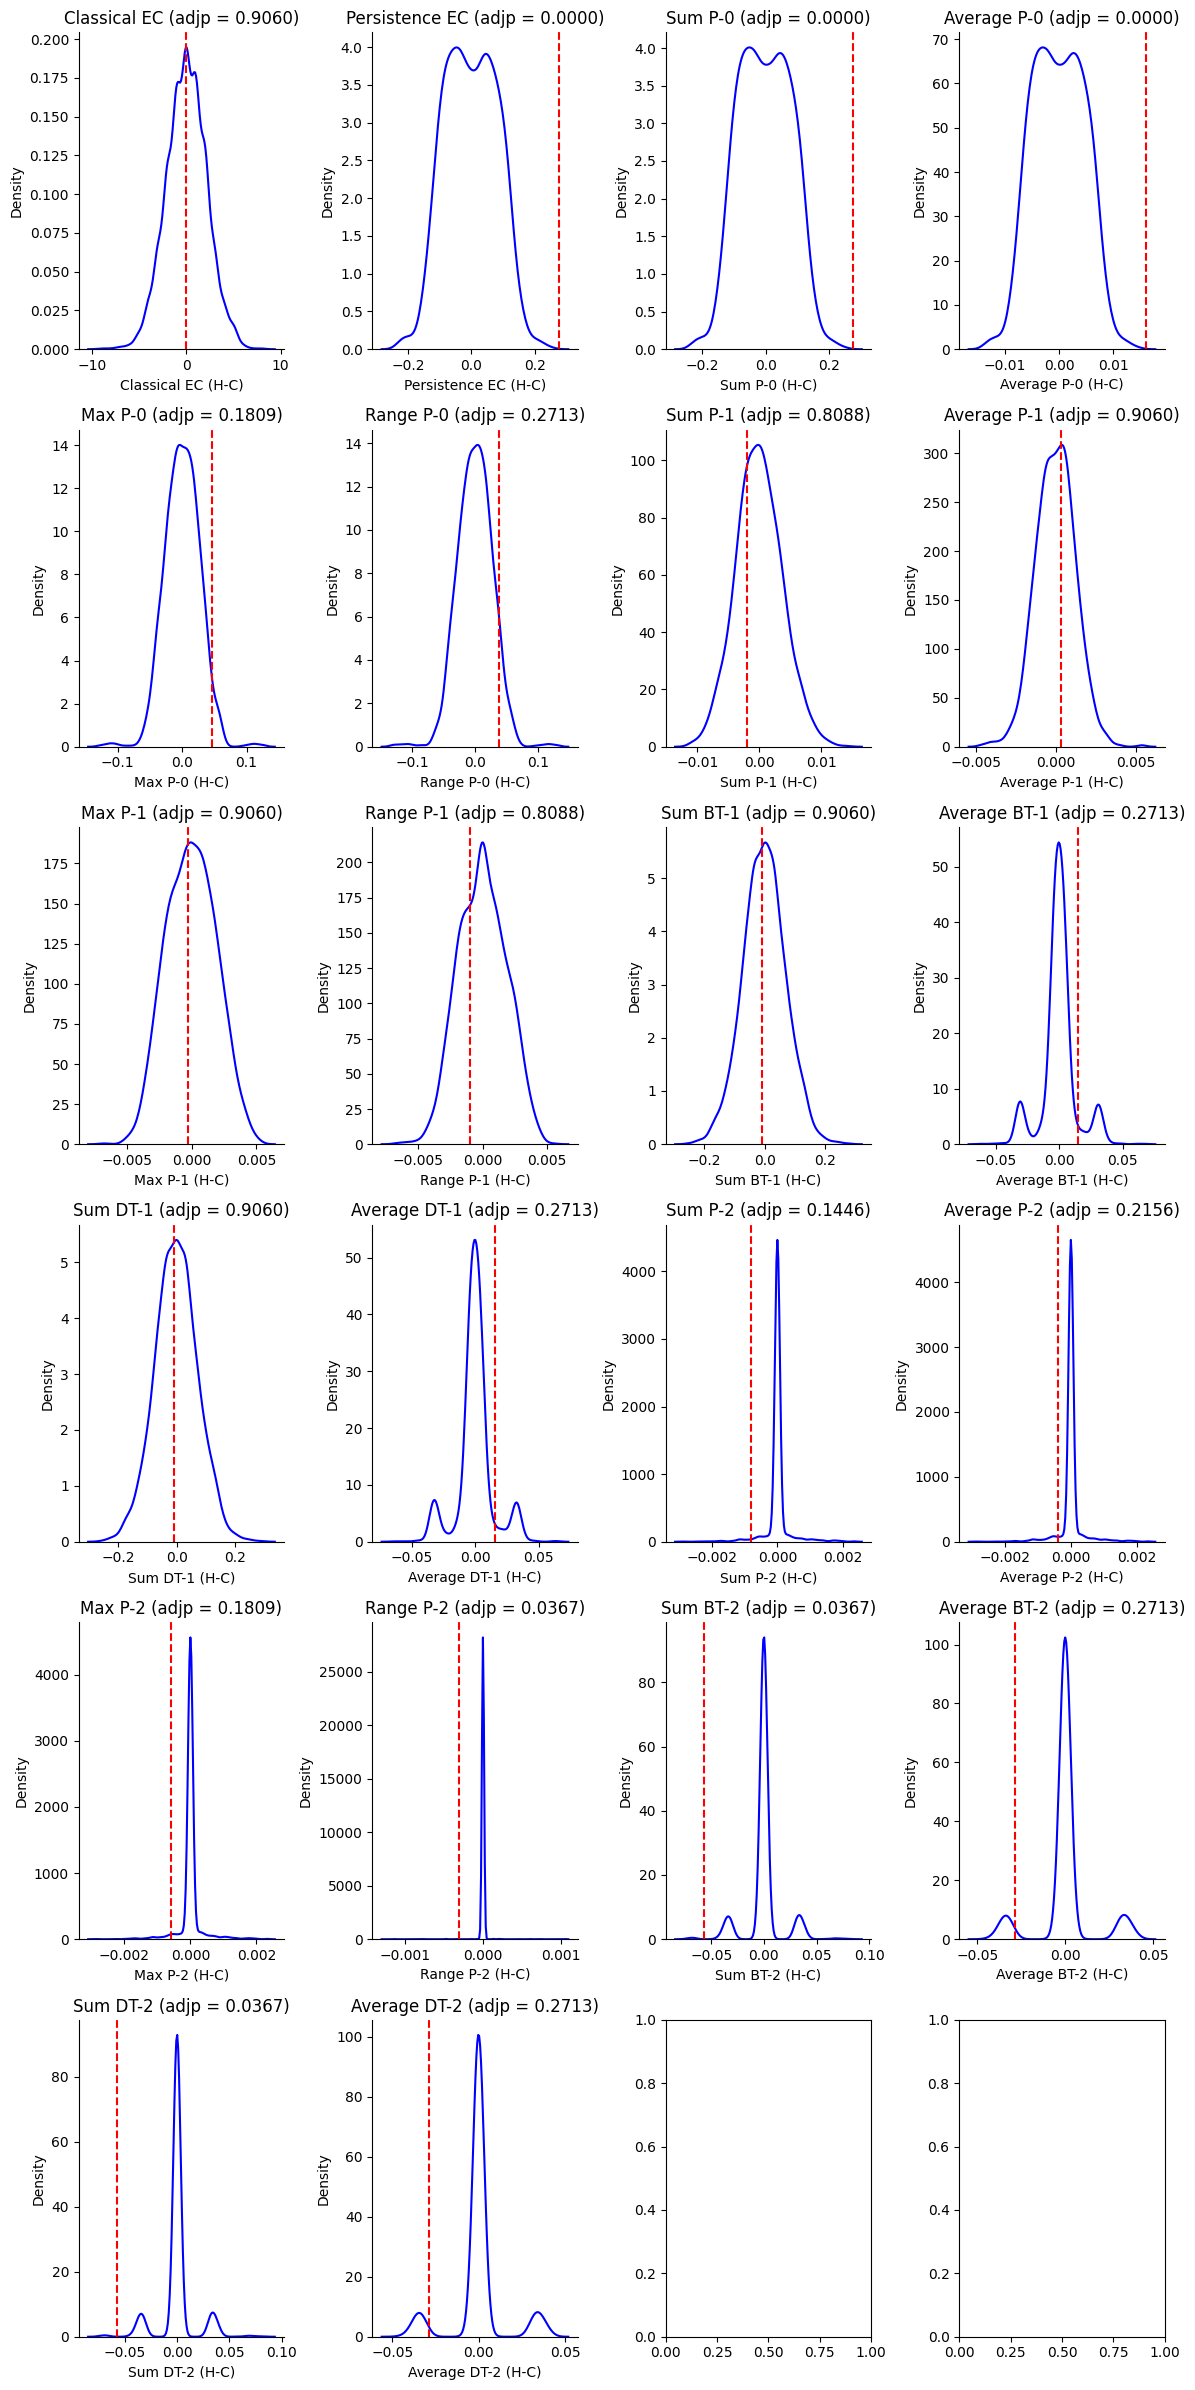

In [158]:
# Assuming you have defined diff_labels, trials_differences_all, and real_differences_all
num_plots = len(diff_labels)
num_rows = 6
num_cols = 4

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 24))

# Iterate over the descriptors and create the plots
for i, (label, ax) in enumerate(zip(diff_labels, axes.flatten())):  
    sns.kdeplot(trials_differences_all[i], color='blue', fill=False,  alpha=1.0, ax=ax)
    ax.axvline(x=real_differences_all[i], color='red', linestyle='dashed', linewidth=1.5)

    diff_no_hc = label.replace(" (H-C)", "")
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.set_title('{} (adjp = {:.4f})'.format(diff_no_hc, both_adj_p_values_all[i]))
    
    # Remove gridlines
    sns.despine(ax=ax)
    
# Adjust the layout spacing
plt.tight_layout()

# Show the plot
plt.show()

#### Plots for the significant descriptors only

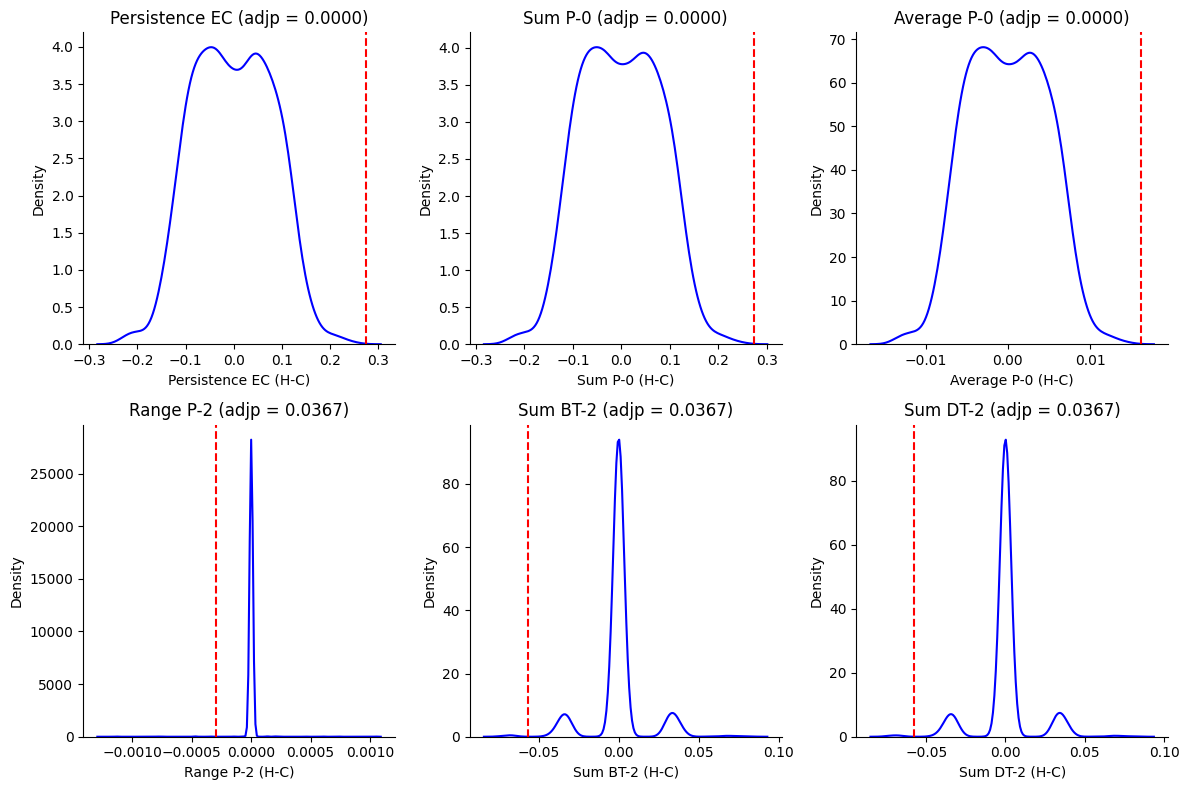

In [159]:
num_plots = len(diff_labels)
num_rows = 2
num_cols = 3

indexes_sig = [1, 2, 3, 17, 18, 20]
sig_diff_labels = [diff_labels[i] for i in indexes_sig]
sig_trials_differences_all = [trials_differences_all[i] for i in indexes_sig]
sig_real_differences_all = [real_differences_all[i]for i in indexes_sig]
sig_both_adj_p_values_all = [both_adj_p_values_all[i] for i in indexes_sig]

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate over the descriptors and create the plots
for i, (label, ax) in enumerate(zip(sig_diff_labels, axes.flatten())):  
    sns.kdeplot(sig_trials_differences_all[i], color='blue', fill=False,  alpha=1.0, ax=ax)
    ax.axvline(x=sig_real_differences_all[i], color='red', linestyle='dashed', linewidth=1.5)

    diff_no_hc = label.replace(" (H-C)", "")
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.set_title('{} (adjp = {:.4f})'.format(diff_no_hc, sig_both_adj_p_values_all[i]))
    #ax.legend()  # Show legend on each subplot
    
    # Remove gridlines
    sns.despine(ax=ax)
    
# Adjust the layout spacing
plt.tight_layout()

# Show the plot
plt.show()

### Differences (H - C) in the significant topological descriptors for all 251 KEGG pathways

In [166]:
# Use iloc to select the specific columns
diff_top_desc_significant = diff_td.iloc[:, [0, 2, 3, 4, 18, 19, 21]]
diff_top_desc_significant

Pathway  Persistence EC (H-C)  \
0                       Glycolysis / Gluconeogenesis                0.3284   
1                          Citrate cycle (TCA cycle)                1.1207   
2                          Pentose phosphate pathway                0.4756   
3           Pentose and glucuronate interconversions                0.5768   
4                    Fructose and mannose metabolism                0.3430   
..                                               ...                   ...   
246                     Longevity regulating pathway                0.4469   
247  Longevity regulating pathway - multiple species                0.3993   
248                                 Circadian rhythm                0.6226   
249                            Circadian entrainment                0.2457   
250                                    Thermogenesis                0.2594   

     Sum P-0 (H-C)  Average P-0 (H-C)  Range P-2 (H-C)  Sum BT-2 (H-C)  \
0           0.3281             0.0193            0.000          0.0000   
1           1.1070             0.0652           -0.002         -0.1709   
2           0.4720             0.0277            0.000          0.0000   
3           0.5707             0.0336            0.000          0.0000   
4           0.3526             0.0208            0.000          0.0000   
..             ...                ...              ...             ...   
246         0.4429             0.0260            0.000          0.0000   
247         0.4055             0.0239            0.000         -0.0278   
248         0.6362             0.0374            0.000          0.0000   
249         0.2449             0.0144            0.000         -0.0231   
250         0.2581             0.0151            0.000          0.0000   

     Sum DT-2 (H-C)  
0            0.0000  
1           -0.1759  
2            0.0000  
3            0.0000  
4            0.0000  
..              ...  
246          0.0000  
247         -0.0280  
248          0.0000  
249         -0.0240  
250          0.0000  

[251 rows x 7 columns]

#### 1. For HCC-Control dataset against the datasets of all KEGG pathways 

In [168]:
significant_topo_descriptors = diff_top_desc_significant.iloc[:,1:].columns.to_list()
significant_topo_descriptors = [label.replace(' (H-C)', '') for label in significant_topo_descriptors]
print(significant_topo_descriptors)

['Persistence EC', 'Sum P-0', 'Average P-0', 'Range P-2', 'Sum BT-2', 'Sum DT-2']


In [169]:
significant_topo_descriptors_df = diff_all[diff_all.index.isin(significant_topo_descriptors)]
significant_topo_descriptors_df

Data           whole_control whole_disease Diff (H-C)  Both_Adj_P_Values
Persistence EC        0.3509        0.6252     0.2743           0.000000
Sum P-0               0.3573        0.6305     0.2732           0.000000
Average P-0            0.021        0.0371     0.0161           0.000000
Range P-2             0.0003           0.0    -0.0003           0.036667
Sum BT-2              0.0569           0.0    -0.0569           0.036667
Sum DT-2              0.0577           0.0    -0.0577           0.036667

In [170]:
significant_topo_descriptors_tca = diff_tca[diff_tca.index.isin(significant_topo_descriptors)]
significant_topo_descriptors_tca

Data           TCA_control TCA_disease Diff (H-C)
Persistence EC      1.0582      2.1789     1.1207
Sum P-0             1.0836      2.1906      1.107
Average P-0         0.0637      0.1289     0.0652
Range P-2            0.002         0.0     -0.002
Sum BT-2            0.1709         0.0    -0.1709
Sum DT-2            0.1759         0.0    -0.1759

### Permutation test for all the pathway-specific datasets from 251 KEGG pathways

In [33]:
# Permutations (~ 135 minutes)
import random

start_time = time.time()
      
# Number of random permutations
num_trials = 2000

# Dictionaries
results_permutation_dict = {}
real_differences_dict = {}
trials_differences_dict = {}
pos_p_values_dict = {}
neg_p_values_dict = {}
p_values_dict = {}

# List of lists
results_permutation_list = []
real_differences_list = []
trials_differences_list = []
pos_p_values_list = []
neg_p_values_list = []
p_values_list = []

diff_labels = diff_top_desc_all
for j, (key, data) in enumerate(kegg_dict.items()):
    
    random.seed(42) # For reproducivity 
    
    trials_diff_EC = np.zeros(num_trials)
    trials_diff_PEC = np.zeros(num_trials)
    trials_diff_S0P = np.zeros(num_trials)
    trials_diff_AS0P = np.zeros(num_trials)
    trials_diff_M0P = np.zeros(num_trials)
    trials_diff_R0P = np.zeros(num_trials)
    trials_diff_S1P = np.zeros(num_trials)
    trials_diff_AS1P = np.zeros(num_trials)
    trials_diff_M1P = np.zeros(num_trials)
    trials_diff_R1P = np.zeros(num_trials)
    trials_diff_S1B = np.zeros(num_trials)
    trials_diff_AS1B = np.zeros(num_trials)
    trials_diff_S1D = np.zeros(num_trials)
    trials_diff_AS1D = np.zeros(num_trials)
    trials_diff_S2P = np.zeros(num_trials)
    trials_diff_AS2P = np.zeros(num_trials)
    trials_diff_M2P = np.zeros(num_trials)
    trials_diff_R2P = np.zeros(num_trials)
    trials_diff_S2B = np.zeros(num_trials)
    trials_diff_AS2B = np.zeros(num_trials)
    trials_diff_S2D = np.zeros(num_trials)
    trials_diff_AS2D = np.zeros(num_trials)

    exp_data = data
    num_columns_HCC = df_disease.shape[1]
    for i in range(num_trials):
        indices = list(range(exp_data.shape[1]))
        random.shuffle(indices)
    
        disease_trial = exp_data.iloc[:, indices[:num_columns_HCC]]
        control_trial = exp_data.iloc[:, indices[num_columns_HCC:]]
    
        cd_disease_trial = fx.corr_matrix(disease_trial, corr_type="Dissimilarity", by="Sample")
        cd_control_trial = fx.corr_matrix(control_trial, corr_type="Dissimilarity", by="Sample")
          
        disease_persistence_trial = fx.get_persistence_diagram(cd_disease_trial, max_dim=max_dim, edge_length=max_radius)
        control_persistence_trial = fx.get_persistence_diagram(cd_control_trial, max_dim=max_dim, edge_length=max_radius)
            
        p_euler_d = fx.sum_persistence(disease_persistence_trial,0) - fx.sum_persistence(disease_persistence_trial,1) + fx.sum_persistence(disease_persistence_trial,2)
        p_euler_c = fx.sum_persistence(control_persistence_trial,0) - fx.sum_persistence(control_persistence_trial,1) + fx.sum_persistence(control_persistence_trial,2)
    
        maxmin0_d = fx.max_persistence(disease_persistence_trial,0) - fx.min_persistence(disease_persistence_trial,0)
        maxmin0_c = fx.max_persistence(control_persistence_trial,0) - fx.min_persistence(control_persistence_trial,0)
        maxmin1_d = fx.max_persistence(disease_persistence_trial,1) - fx.min_persistence(disease_persistence_trial,1)
        maxmin1_c = fx.max_persistence(control_persistence_trial,1) - fx.min_persistence(control_persistence_trial,1)
        maxmin2_d = fx.max_persistence(disease_persistence_trial,2) - fx.min_persistence(disease_persistence_trial,2)
        maxmin2_c = fx.max_persistence(control_persistence_trial,2) - fx.min_persistence(control_persistence_trial,2)
    
        no_features0_d = fx.number_features(disease_persistence_trial, 0)
        no_features0_c = fx.number_features(control_persistence_trial, 0)
        no_features1_d = fx.number_features(disease_persistence_trial, 1)
        no_features1_c = fx.number_features(control_persistence_trial, 1)
        no_features2_d = fx.number_features(disease_persistence_trial, 2)
        no_features2_c = fx.number_features(control_persistence_trial, 2)
    
        trials_diff_EC[i] = fx.euler_characteristic(disease_persistence_trial) - fx.euler_characteristic(control_persistence_trial)
        trials_diff_PEC[i] = p_euler_d - p_euler_c
        trials_diff_S0P[i] = fx.sum_persistence(disease_persistence_trial, 0) - fx.sum_persistence(control_persistence_trial, 0)
        trials_diff_AS0P[i] = (fx.sum_persistence(disease_persistence_trial, 0) / no_features0_d if no_features0_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 0) / no_features0_c if no_features0_c != 0 else 0)
        trials_diff_M0P[i] = fx.max_persistence(disease_persistence_trial, 0) - fx.max_persistence(control_persistence_trial, 0)
        trials_diff_R0P[i] = maxmin0_d - maxmin0_c    
        trials_diff_S1P[i] = fx.sum_persistence(disease_persistence_trial, 1) - fx.sum_persistence(control_persistence_trial, 1)
        trials_diff_AS1P[i] = (fx.sum_persistence(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
        trials_diff_M1P[i] = fx.max_persistence(disease_persistence_trial, 1) - fx.max_persistence(control_persistence_trial, 1)
        trials_diff_R1P[i] = maxmin1_d - maxmin1_c
        trials_diff_S1B[i] = fx.sum_birth(disease_persistence_trial, 1) - fx.sum_birth(control_persistence_trial, 1)
        trials_diff_AS1B[i] = (fx.sum_birth(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_birth(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
        trials_diff_S1D[i] = fx.sum_death(disease_persistence_trial, 1) - fx.sum_death(control_persistence_trial, 1)
        trials_diff_AS1D[i] = (fx.sum_death(disease_persistence_trial, 1) / no_features1_d if no_features1_d != 0 else 0) - (fx.sum_death(control_persistence_trial, 1) / no_features1_c if no_features1_c != 0 else 0)
        trials_diff_S2P[i] = fx.sum_persistence(disease_persistence_trial, 2) - fx.sum_persistence(control_persistence_trial, 2)
        trials_diff_AS2P[i] = (fx.sum_persistence(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_persistence(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)
        trials_diff_M2P[i] = fx.max_persistence(disease_persistence_trial, 2) - fx.max_persistence(control_persistence_trial, 2)
        trials_diff_R2P[i] = maxmin2_d - maxmin2_c
        trials_diff_S2B[i] = fx.sum_birth(disease_persistence_trial, 2) - fx.sum_birth(control_persistence_trial, 2)
        trials_diff_AS2B[i] = (fx.sum_birth(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_birth(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)
        trials_diff_S2D[i] = fx.sum_death(disease_persistence_trial, 2) - fx.sum_death(control_persistence_trial, 2)
        trials_diff_AS2D[i] = (fx.sum_death(disease_persistence_trial, 2) / no_features2_d if no_features2_d != 0 else 0) - (fx.sum_death(control_persistence_trial, 2) / no_features2_c if no_features2_c != 0 else 0)
        
    # Differences generated from the permutation trials  
    trials_differences = [trials_diff_EC, trials_diff_PEC, trials_diff_S0P, trials_diff_AS0P, trials_diff_M0P,
                          trials_diff_R0P, trials_diff_S1P, trials_diff_AS1P, trials_diff_M1P, trials_diff_R1P,
                          trials_diff_S1B, trials_diff_AS1B, trials_diff_S1D, trials_diff_AS1D, trials_diff_S2P,
                          trials_diff_AS2P, trials_diff_M2P, trials_diff_R2P, trials_diff_S2B, trials_diff_AS2B,
                          trials_diff_S2D, trials_diff_AS2D]
    
    # List containing all the trial differences
    trials_differences_list.append(trials_differences)
      
    results_permutation = {
        'Difference': diff_labels,
        'count_greater': [],
        'count_less': [],
        'count_greater_equal': [],
        'count_less_equal': [],
        'count_equal': []
    }
    for label, difference in zip(diff_labels, trials_differences):
        count_g = np.sum(difference > diff_td.loc[j][label])
        count_l = np.sum(difference < diff_td.loc[j][label])
        count_ge = np.sum(difference >= diff_td.loc[j][label])
        count_le = np.sum(difference <= diff_td.loc[j][label])
        count_e = np.sum(difference == diff_td.loc[j][label])
        
        results_permutation['count_greater'].append(count_g)
        results_permutation['count_less'].append(count_l)
        results_permutation['count_greater_equal'].append(count_ge)
        results_permutation['count_less_equal'].append(count_le)
        results_permutation['count_equal'].append(count_e)
        
    results_permutation_df = pd.DataFrame(results_permutation)
    results_permutation_list.append(results_permutation_df)   
    
    real_differences = []
    pos_p_values = []
    neg_p_values = []
    both_p_values = []

    for label in diff_labels:
        real_diff = diff_td.loc[j][label]
        pos_p_value = (results_permutation_df.loc[results_permutation_df['Difference'] == label, 'count_greater'].values[0]) / num_trials
        neg_p_value = (results_permutation_df.loc[results_permutation_df['Difference'] == label, 'count_less'].values[0]) / num_trials
        both_p_value = 2 * (min(pos_p_value, neg_p_value))
        real_differences.append(real_diff)
        pos_p_values.append(pos_p_value)
        neg_p_values.append(neg_p_value)
        both_p_values.append(both_p_value)
    
    real_differences_list.append(real_differences)
    pos_p_values_list.append(pos_p_values)
    neg_p_values_list.append(neg_p_values)
    p_values_list.append(both_p_values)
    
    if j in [0, 24, 49, 74, 99, 124, 149, 174, 199, 224, 249]:
        print(j+1)
    
    results_permutation_dict[key] = results_permutation_df
    real_differences_dict[key] = real_differences
    trials_differences_dict[key] = trials_differences
    pos_p_values_dict[key] = pos_p_values
    neg_p_values_dict[key] = neg_p_values
    p_values_dict[key] = both_p_values
    
print(" --- %s seconds ---" % (time.time() - start_time))

NameError: name 'diff_top_desc_hc' is not defined

In [178]:
#results_permutation_list[100]

In [177]:
#results_permutation_dict['Base excision repair']

#### Benjamini-Hochberg (FDR) adjusted p_values

In [389]:
adj_p_values_list = []
for pvalue in p_values_list:
    adj_p_value = multi.multipletests(pvalue, method='fdr_bh')[1]
    adj_p_values_list.append(adj_p_value)

In [390]:
print(p_values_list[p53_index])

[0.014, 0.002, 0.003, 0.003, 0.374, 0.387, 0.031, 0.202, 0.129, 0.117, 0.185, 0.559, 0.167, 0.55, 0.021, 0.021, 0.021, 0.0, 0.021, 0.021, 0.021, 0.021]


In [391]:
print(adj_p_values_list[p53_index])

[0.0385     0.0165     0.0165     0.0165     0.4257     0.4257
 0.05246154 0.24688889 0.1892     0.18385714 0.23941176 0.559
 0.229625   0.559      0.0385     0.0385     0.0385     0.
 0.0385     0.0385     0.0385     0.0385    ]


In [183]:
#print(adj_p_values_list[100]) # Base excision repair

##### Filter for the pathways with adjusted p_values (<0.05)

In [184]:
threshold = 0.05

data_tuples_adjp = [(i, j) for i, sublist in enumerate(adj_p_values_list) for j, val in enumerate(sublist) if val < threshold]

filtered_indices_dict_adjp = {}
for i, j in data_tuples_adjp:
    if i in filtered_indices_dict_adjp:
        filtered_indices_dict_adjp[i].append(j)
    else:
        filtered_indices_dict_adjp[i] = [j]

len(filtered_indices_dict_adjp)

199

In [185]:
filt_path_pec_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value}# and 1 in value}
print(len(filt_path_pec_adjp))
#filt_path_pec_adjp

138


In [186]:
filt_path_s0p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 2 in value}# and 1 in value}
print(len(filt_path_s0p_adjp))
#filt_path_s0p_adjp

137


In [187]:
filt_path_a0p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 3 in value}# and 1 in value}
print(len(filt_path_a0p_adjp))
#filt_path_as0p_adjp

138


In [188]:
filt_path_r2p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 17 in value}# and 1 in value}
print(len(filt_path_r2p_adjp))
#filt_path_r2p_adjp

181


In [189]:
filt_path_s2b_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 18 in value}# and 1 in value}
print(len(filt_path_s2b_adjp))
#filt_path_s2b_adjp

36


In [190]:
filt_path_s2d_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 20 in value}# and 1 in value}
print(len(filt_path_s2d_adjp))
#filt_path_s2d_adjp

36


In [191]:
filt_path_allfeatures_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value and 2 in value and 3 in value and 17 in value and 18 in value and 20 in value}
print(len(filt_path_allfeatures_adjp))
#filt_path_allfeatures_adjp

23


In [192]:
filt_path_pec_a0p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value and 3 in value}
print(len(filt_path_pec_a0p_adjp))
#filt_path_pec_s0p_as0p_adjp

138


In [193]:
filt_path_s2b_s2d_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 18 in value and 20 in value}
print(len(filt_path_s2b_s2d_adjp))
#filt_path_pec_s0p_adjp

36


In [194]:
filt_path_pec_a0p_s0p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value and 2 in value}
print(len(filt_path_pec_a0p_s0p_adjp))
#filt_path_pec_r2p_adjp

137


In [195]:
filt_path_pec_a0p_r2p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value and 17 in value}
print(len(filt_path_pec_a0p_r2p_adjp))
#filt_path_pec_r2p_adjp

122


In [196]:
filt_path_pec_a0p_s2b_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 1 in value and 18 in value}
print(len(filt_path_pec_a0p_s2b_adjp))
#filt_path_pec_s2b_adjp

23


In [197]:
filt_path_s0p_r2p_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 2 in value and 17 in value}
print(len(filt_path_s0p_r2p_adjp))
#filt_path_r2p_s2b_adjp

121


In [198]:
filt_path_s0p_s2b_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 2 in value and 18 in value}
print(len(filt_path_s0p_s2b_adjp))
#filt_path_r2p_s2b_adjp

23


In [199]:
filt_path_r2p_s2b_adjp = {key: value for key, value in filtered_indices_dict_adjp.items() if 17 in value and 18 in value}
print(len(filt_path_r2p_s2b_adjp))
#filt_path_r2p_s2b_adjp

36


In [201]:
def get_identified_pathways(data):
    keys = []
    for i in data.keys():
        keys.append(i)
    
    keys_values = []
    for i in keys:
        desired_values = kegg_data[i]
        keys_values.append(desired_values)

    filtered_keys = []
    for i in range(len(keys_values)):
        value = keys_values[i]
        for key, item in kegg_dict.items():
            if item.equals(value):
                filtered_keys.append(key)
                
    return filtered_keys

In [206]:
filtered_pathways_PA_adjp_005 = get_identified_pathways(filt_path_pec_a0p_adjp)
print(len(filtered_pathways_PA_adjp_005))
#print(filtered_pathways_PA_adjp_005)

138


In [207]:
filtered_pathways_S_adjp_005 = get_identified_pathways(filt_path_s0p_adjp)
print(len(filtered_pathways_S_adjp_005))
#print(filtered_pathways_S_adjp_005)

137


In [209]:
filtered_pathways_BD_adjp_005 = get_identified_pathways(filt_path_s2b_s2d_adjp)
print(len(filtered_pathways_BD_adjp_005))
#print(filtered_pathways_BD_adjp_005)

36


In [210]:
filtered_pathways_R_adjp_005 = get_identified_pathways(filt_path_r2p_adjp)
print(len(filtered_pathways_R_adjp_005))
#print(filtered_pathways_R_adjp_005)

181


In [211]:
filtered_pathways_PAR_adjp_005 = get_identified_pathways(filt_path_pec_a0p_r2p_adjp)
print(len(filtered_pathways_PAR_adjp_005))
#print(filtered_pathways_PAR_adjp_005)

122


In [216]:
filtered_pathways_PABD_adjp_005 = get_identified_pathways(filt_path_pec_a0p_s2b_adjp)
print(len(filtered_pathways_PABD_adjp_005))
#print(filtered_pathways_PABD_adjp_005)

23


In [213]:
filtered_pathways_SBD_adjp_005 = get_identified_pathways(filt_path_s0p_s2b_adjp)
print(len(filtered_pathways_SBD_adjp_005))
#print(filtered_pathways_SBD_adjp_005)

23


In [215]:
filtered_pathways_RBD_adjp_005 = get_identified_pathways(filt_path_r2p_s2b_adjp)
print(len(filtered_pathways_RBD_adjp_005))
#print(filtered_pathways_RBD_adjp_005)

36


In [214]:
filtered_pathways_adjp_005 = get_identified_pathways(filt_path_allfeatures_adjp)
print(len(filtered_pathways_adjp_005))
print(filtered_pathways_adjp_005)

23
['Citrate cycle (TCA cycle)', 'Ascorbate and aldarate metabolism', 'Sulfur metabolism', 'Primary bile acid biosynthesis', 'Glycine, serine and threonine metabolism', 'Histidine metabolism', 'Tryptophan metabolism', 'beta-Alanine metabolism', 'Phosphonate and phosphinate metabolism', 'Riboflavin metabolism', 'Pantothenate and CoA biosynthesis', 'Porphyrin metabolism', 'Drug metabolism - cytochrome P450', 'RNA polymerase', 'Protein processing in endoplasmic reticulum', 'Base excision repair', 'Virion - Herpesvirus', 'ABC transporters', 'Apelin signaling pathway', 'p53 signaling pathway', 'IL-17 signaling pathway', 'Collecting duct acid secretion', 'Synaptic vesicle cycle']


### Differential Gene Expression Analysis

In [217]:
deseq_df = pd.read_csv('Datasets/DEGenes_Edited_RNASeqHCC.csv', header=0)
print(deseq_df.shape)
deseq_df

(26575, 8)


IDs     baseMean  log2FoldChange     lfcSE      stat  \
0      ENSG00000121410    14.117520       -0.079299  0.226984 -0.349362   
1      ENSG00000268895    35.509752       -0.083904  0.154198 -0.544132   
2      ENSG00000148584     3.019975       -0.635019  0.422087 -1.504476   
3      ENSG00000175899  4126.735156       -0.724464  0.250971 -2.886642   
4      ENSG00000245105   793.673986       -0.653176  0.250330 -2.609261   
...                ...          ...             ...       ...       ...   
26570  ENSG00000203995     8.260679        0.241050  0.319057  0.755507   
26571  ENSG00000162378   958.937601        0.079209  0.068463  1.156964   
26572  ENSG00000159840  2927.502956        0.723771  0.200080  3.617405   
26573  ENSG00000074755  3821.998568        0.054175  0.053310  1.016224   
26574  ENSG00000036549  1086.415733       -0.193790  0.067328 -2.878321   

         pvalue      padj    Symbol  
0      0.726818  0.836357      A1BG  
1      0.586351  0.735238  A1BG-AS1  
2      0.132459  0.274689      A1CF  
3      0.003894  0.019179       A2M  
4      0.009074  0.037307   A2M-AS1  
...         ...       ...       ...  
26570  0.449945  0.622947    ZYG11A  
26571  0.247287  0.424426    ZYG11B  
26572  0.000298  0.002569       ZYX  
26573  0.309523  0.492511     ZZEF1  
26574  0.003998  0.019532      ZZZ3  

[26575 rows x 8 columns]

In [218]:
columns_to_keep = ['log2FoldChange', 'padj', 'Symbol']
sel_deseq_df = deseq_df[columns_to_keep]
sel_deseq_df

log2FoldChange      padj    Symbol
0           -0.079299  0.836357      A1BG
1           -0.083904  0.735238  A1BG-AS1
2           -0.635019  0.274689      A1CF
3           -0.724464  0.019179       A2M
4           -0.653176  0.037307   A2M-AS1
...               ...       ...       ...
26570        0.241050  0.622947    ZYG11A
26571        0.079209  0.424426    ZYG11B
26572        0.723771  0.002569       ZYX
26573        0.054175  0.492511     ZZEF1
26574       -0.193790  0.019532      ZZZ3

[26575 rows x 3 columns]

In [219]:
degs_df = sel_deseq_df.set_index('Symbol')
print(degs_df.shape)
degs_df

(26575, 2)


log2FoldChange      padj
Symbol                            
A1BG           -0.079299  0.836357
A1BG-AS1       -0.083904  0.735238
A1CF           -0.635019  0.274689
A2M            -0.724464  0.019179
A2M-AS1        -0.653176  0.037307
...                  ...       ...
ZYG11A          0.241050  0.622947
ZYG11B          0.079209  0.424426
ZYX             0.723771  0.002569
ZZEF1           0.054175  0.492511
ZZZ3           -0.193790  0.019532

[26575 rows x 2 columns]

In [220]:
# Add a direction column for 'log2FoldChange'
degs_df['direction'] = ''  # Create an empty 'direction' column
degs_df.loc[degs_df['log2FoldChange'] > 0, 'direction'] = 'Up'
degs_df.loc[degs_df['log2FoldChange'] < 0, 'direction'] = 'Down'
degs_df

log2FoldChange      padj direction
Symbol                                      
A1BG           -0.079299  0.836357      Down
A1BG-AS1       -0.083904  0.735238      Down
A1CF           -0.635019  0.274689      Down
A2M            -0.724464  0.019179      Down
A2M-AS1        -0.653176  0.037307      Down
...                  ...       ...       ...
ZYG11A          0.241050  0.622947        Up
ZYG11B          0.079209  0.424426        Up
ZYX             0.723771  0.002569        Up
ZZEF1           0.054175  0.492511        Up
ZZZ3           -0.193790  0.019532      Down

[26575 rows x 3 columns]

In [221]:
# Genes with adj. p-value < 0.05 
sig_pv = degs_df.loc[degs_df['padj'] < 0.05]
print(sig_pv.shape)
sig_pv

(6977, 3)


log2FoldChange          padj direction
Symbol                                         
A2M           -0.724464  1.917854e-02      Down
A2M-AS1       -0.653176  3.730741e-02      Down
A2MP1         -0.669858  4.772970e-02      Down
AAK1          -0.322109  1.194953e-07      Down
AARS2         -0.240705  4.057463e-02      Down
...                 ...           ...       ...
ZUP1           0.200311  1.892612e-02        Up
ZXDA          -0.394218  6.934634e-03      Down
ZXDB          -0.570059  6.008929e-07      Down
ZYX            0.723771  2.568542e-03        Up
ZZZ3          -0.193790  1.953195e-02      Down

[6977 rows x 3 columns]

In [222]:
# Genes with log2FoldChange >= 1
sig_lfc = degs_df[(abs(degs_df['log2FoldChange']) >= 1)]
print(sig_lfc.shape)
sig_lfc

(1904, 3)


log2FoldChange          padj direction
Symbol                                           
ABCA1            1.439086  9.014367e-09        Up
ABCA13           1.856134  1.022722e-02        Up
ABCA3P1          1.716512  6.195688e-03        Up
ABCB5            2.717701           NaN        Up
ABCC13           5.703337  6.025618e-05        Up
...                   ...           ...       ...
ZNF516-DT        1.002239  4.559500e-03        Up
ZNF70P1         -1.114072           NaN      Down
ZNF788P          1.397076  9.468975e-04        Up
ZNF839P1         1.393219  2.992100e-01        Up
ZSWIM5P2         2.326894  8.860789e-03        Up

[1904 rows x 3 columns]

In [223]:
# Genes with adj. p-value < 0.05 and log2FoldChange >= 1
sig_lfc_pv = degs_df.loc[(abs(degs_df['log2FoldChange']) >= 1) & (degs_df['padj'] < 0.05)]
print(sig_lfc_pv.shape)
sig_lfc_pv

(1423, 3)


log2FoldChange          padj direction
Symbol                                           
ABCA1            1.439086  9.014367e-09        Up
ABCA13           1.856134  1.022722e-02        Up
ABCA3P1          1.716512  6.195688e-03        Up
ABCC13           5.703337  6.025618e-05        Up
ABCC3            1.264824  4.792861e-05        Up
...                   ...           ...       ...
ZFPM2            1.583489  2.261838e-04        Up
ZNF185           1.381498  4.008916e-07        Up
ZNF516-DT        1.002239  4.559500e-03        Up
ZNF788P          1.397076  9.468975e-04        Up
ZSWIM5P2         2.326894  8.860789e-03        Up

[1423 rows x 3 columns]

In [225]:
# List of significant genes
significant_degs = sig_lfc_pv.index.tolist()
#significant_degs

In [226]:
number_up_regulated = (sig_lfc_pv['log2FoldChange'] > 0).sum()
number_up_regulated

1238

In [227]:
up_regulated = sig_lfc_pv[sig_lfc_pv['direction'] == 'Up']
up_regulated

log2FoldChange          padj direction
Symbol                                           
ABCA1            1.439086  9.014367e-09        Up
ABCA13           1.856134  1.022722e-02        Up
ABCA3P1          1.716512  6.195688e-03        Up
ABCC13           5.703337  6.025618e-05        Up
ABCC3            1.264824  4.792861e-05        Up
...                   ...           ...       ...
ZFPM2            1.583489  2.261838e-04        Up
ZNF185           1.381498  4.008916e-07        Up
ZNF516-DT        1.002239  4.559500e-03        Up
ZNF788P          1.397076  9.468975e-04        Up
ZSWIM5P2         2.326894  8.860789e-03        Up

[1238 rows x 3 columns]

In [228]:
number_down_regulated = (sig_lfc_pv['log2FoldChange'] < 0).sum()
number_down_regulated

185

In [229]:
down_regulated = sig_lfc_pv[sig_lfc_pv['direction'] == 'Down']
down_regulated

log2FoldChange          padj direction
Symbol                                            
AC004528.1       -1.412973  2.307541e-02      Down
AC006566.1       -1.282239  1.856724e-04      Down
AC007325.2       -1.165037  3.306674e-02      Down
AC008378.1       -1.081972  1.708494e-05      Down
AC009102.1       -1.556705  1.819736e-04      Down
...                    ...           ...       ...
VIT              -1.118211  4.008415e-03      Down
VN2R17P          -2.409720  5.708247e-04      Down
VPS13C-DT        -1.447154  7.356007e-04      Down
WAKMAR2          -1.121891  5.180174e-06      Down
WHRN             -1.303888  1.383693e-07      Down

[185 rows x 3 columns]

In [230]:
# Sort the dataFrame by the absolute values of 'log2FoldChange' column in descending order
sorted_sig_genes = sig_lfc_pv.iloc[sig_lfc_pv['log2FoldChange'].abs().argsort()[::-1]]

# Get the top 25 genes with highest absolute values in 'log2FoldChange' column 
sorted_sig_genes.head(25)

log2FoldChange          padj direction
Symbol                                           
ALAS2            7.378952  9.287005e-15        Up
SELENBP1         7.362474  2.156656e-13        Up
HBA1             7.292535  9.287005e-15        Up
HBA2             7.017532  9.287005e-15        Up
AHSP             6.514360  1.567644e-08        Up
SLC4A1           6.503732  8.458798e-13        Up
HBM              6.276061  3.983279e-08        Up
HBD              6.202504  9.990498e-13        Up
ABCC13           5.703337  6.025618e-05        Up
BCAM             5.687053  5.751244e-05        Up
METTL7B          5.641353  6.739213e-09        Up
HBB              5.604588  5.926622e-11        Up
IFIT1B           5.467597  2.110092e-11        Up
HBG2             5.333413  3.685098e-06        Up
GYPB             5.133545  1.221222e-06        Up
KRT1             5.131912  5.848709e-05        Up
GYPA             5.011801  7.008961e-07        Up
ACKR1            4.791672  1.340254e-02        Up
CA1              4.767406  2.722159e-09        Up
ADAMTS2          4.641689  1.271584e-07        Up
LINC02772        4.607124  8.335058e-03        Up
RHAG             4.595888  1.383693e-07        Up
DEFA1B           4.469450  1.631538e-02        Up
RNF182           4.284374  3.391827e-05        Up
CYP19A1          4.283913  6.870867e-08        Up

In [232]:
# Sort the dataFrame by the absolute values of 'log2FoldChange' column in descending order
sorted_sig_genes_upreg = sorted_sig_genes.iloc[sorted_sig_genes['log2FoldChange'].argsort()[::-1]]

# Get the top 25 genes with highest absolute values in 'log2FoldChange' column 
sorted_sig_genes_upreg.head(25)

log2FoldChange          padj direction
Symbol                                           
ALAS2            7.378952  9.287005e-15        Up
SELENBP1         7.362474  2.156656e-13        Up
HBA1             7.292535  9.287005e-15        Up
HBA2             7.017532  9.287005e-15        Up
AHSP             6.514360  1.567644e-08        Up
SLC4A1           6.503732  8.458798e-13        Up
HBM              6.276061  3.983279e-08        Up
HBD              6.202504  9.990498e-13        Up
ABCC13           5.703337  6.025618e-05        Up
BCAM             5.687053  5.751244e-05        Up
METTL7B          5.641353  6.739213e-09        Up
HBB              5.604588  5.926622e-11        Up
IFIT1B           5.467597  2.110092e-11        Up
HBG2             5.333413  3.685098e-06        Up
GYPB             5.133545  1.221222e-06        Up
KRT1             5.131912  5.848709e-05        Up
GYPA             5.011801  7.008961e-07        Up
ACKR1            4.791672  1.340254e-02        Up
CA1              4.767406  2.722159e-09        Up
ADAMTS2          4.641689  1.271584e-07        Up
LINC02772        4.607124  8.335058e-03        Up
RHAG             4.595888  1.383693e-07        Up
DEFA1B           4.469450  1.631538e-02        Up
RNF182           4.284374  3.391827e-05        Up
CYP19A1          4.283913  6.870867e-08        Up

In [233]:
# Sort the dataFrame by the absolute values of 'log2FoldChange' column in descending order
sorted_sig_genes_downreg = sorted_sig_genes.iloc[sorted_sig_genes['log2FoldChange'].argsort()]

# Get the top 25 genes with highest absolute values in 'log2FoldChange' column 
sorted_sig_genes_downreg.head(25)

log2FoldChange          padj direction
Symbol                                             
SYT5              -3.100136  3.559449e-05      Down
HERC2P10          -2.823865  7.699608e-07      Down
LINC02399         -2.532050  4.916076e-13      Down
VN2R17P           -2.409720  5.708247e-04      Down
AC026771.1        -2.408006  2.960288e-14      Down
OSR2              -2.379308  4.571009e-05      Down
LUM               -2.314381  4.384890e-02      Down
SLC25A24P1        -2.312407  9.447081e-03      Down
CCDC87            -2.146898  8.268991e-04      Down
DNAJB5-DT         -2.116711  7.290455e-06      Down
C4orf47           -2.108878  2.744818e-04      Down
RPP38-DT          -2.100677  8.458798e-13      Down
HES3              -2.074890  1.015902e-02      Down
HSPA8P4           -2.074693  1.091255e-02      Down
LINC02265         -1.988046  2.898048e-06      Down
LINC03004         -1.951875  2.562659e-05      Down
PTMAP9            -1.919969  3.382002e-02      Down
CCDC184           -1.874674  1.778181e-04      Down
SEZ6L-AS1         -1.850657  1.533453e-03      Down
FBXO36-IT1        -1.846832  4.698947e-03      Down
MIR3935           -1.805307  4.441301e-03      Down
LYPD2             -1.753640  2.841627e-06      Down
FAM222A-AS1       -1.719833  4.734859e-03      Down
MOB4P2            -1.719715  1.489103e-04      Down
RRAD              -1.715039  4.490968e-04      Down

In [235]:
top_up = sorted_sig_genes_upreg[:75]
top_down = sorted_sig_genes_downreg[:25]

top_75_up_regulated_genes = top_up.index.tolist()
top_25_down_regulated_genes = top_down.index.tolist()
top_75up_25down_regulated_genes = top_75_up_regulated_genes + top_25_down_regulated_genes

In [236]:
print(top_75_up_regulated_genes)

['ALAS2', 'SELENBP1', 'HBA1', 'HBA2', 'AHSP', 'SLC4A1', 'HBM', 'HBD', 'ABCC13', 'BCAM', 'METTL7B', 'HBB', 'IFIT1B', 'HBG2', 'GYPB', 'KRT1', 'GYPA', 'ACKR1', 'CA1', 'ADAMTS2', 'LINC02772', 'RHAG', 'DEFA1B', 'RNF182', 'CYP19A1', 'AC079210.1', 'ANOS1', 'LINC01482', 'SPTA1', 'HBG1', 'SHISA7', 'EPB42', 'RPS12P24', 'KLF1', 'LINC00570', 'SEC14L4', 'PPARG', 'CTSE', 'AL139220.2', 'PTP4A1P1', 'SEMA6B', 'OR56A7P', 'PAGE2B', 'TJP1', 'EDNRB', 'HEPACAM2', 'ACHE', 'PRKG1-AS1', 'MAOB', 'CD177', 'HP', 'MMP8', 'PTGFR', 'SEC14L3', 'C6orf223', 'LINC02972', 'RAB3IL1', 'WFDC1', 'AL450163.1', 'AC104389.2', 'TRIM10', 'BEST3', 'AC130456.3', 'MLXIPL', 'DUSP13', 'ANKRD34B', 'RAP1GAP', 'H2BP2', 'IGFBP2', 'OR9A4', 'HTRA3', 'SLC25A37', 'C1QC', 'LHFPL6', 'NXF3']


In [237]:
print(top_25_down_regulated_genes)

['SYT5', 'HERC2P10', 'LINC02399', 'VN2R17P', 'AC026771.1', 'OSR2', 'LUM', 'SLC25A24P1', 'CCDC87', 'DNAJB5-DT', 'C4orf47', 'RPP38-DT', 'HES3', 'HSPA8P4', 'LINC02265', 'LINC03004', 'PTMAP9', 'CCDC184', 'SEZ6L-AS1', 'FBXO36-IT1', 'MIR3935', 'LYPD2', 'FAM222A-AS1', 'MOB4P2', 'RRAD']


In [238]:
print(top_75up_25down_regulated_genes)

['ALAS2', 'SELENBP1', 'HBA1', 'HBA2', 'AHSP', 'SLC4A1', 'HBM', 'HBD', 'ABCC13', 'BCAM', 'METTL7B', 'HBB', 'IFIT1B', 'HBG2', 'GYPB', 'KRT1', 'GYPA', 'ACKR1', 'CA1', 'ADAMTS2', 'LINC02772', 'RHAG', 'DEFA1B', 'RNF182', 'CYP19A1', 'AC079210.1', 'ANOS1', 'LINC01482', 'SPTA1', 'HBG1', 'SHISA7', 'EPB42', 'RPS12P24', 'KLF1', 'LINC00570', 'SEC14L4', 'PPARG', 'CTSE', 'AL139220.2', 'PTP4A1P1', 'SEMA6B', 'OR56A7P', 'PAGE2B', 'TJP1', 'EDNRB', 'HEPACAM2', 'ACHE', 'PRKG1-AS1', 'MAOB', 'CD177', 'HP', 'MMP8', 'PTGFR', 'SEC14L3', 'C6orf223', 'LINC02972', 'RAB3IL1', 'WFDC1', 'AL450163.1', 'AC104389.2', 'TRIM10', 'BEST3', 'AC130456.3', 'MLXIPL', 'DUSP13', 'ANKRD34B', 'RAP1GAP', 'H2BP2', 'IGFBP2', 'OR9A4', 'HTRA3', 'SLC25A37', 'C1QC', 'LHFPL6', 'NXF3', 'SYT5', 'HERC2P10', 'LINC02399', 'VN2R17P', 'AC026771.1', 'OSR2', 'LUM', 'SLC25A24P1', 'CCDC87', 'DNAJB5-DT', 'C4orf47', 'RPP38-DT', 'HES3', 'HSPA8P4', 'LINC02265', 'LINC03004', 'PTMAP9', 'CCDC184', 'SEZ6L-AS1', 'FBXO36-IT1', 'MIR3935', 'LYPD2', 'FAM222A-AS1

In [239]:
# List of significant (all, up-regulated, and down-regulated) genes 
all_sig_genes = sig_lfc_pv.index.tolist()
up_reg_genes = up_regulated.index.tolist()
down_reg_genes = down_regulated.index.tolist()

#### Extracted data from our genome-wide gene expression dataset based on DESeq significant genes

In [240]:
# adj. p-value < 0.05
df_pv = df_all.loc[df_all.index.isin(sig_pv.index) & df_all.index.notna()]
print(df_pv.shape)
df_pv

(6977, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...  \
Symbol                                                               ...   
A2M      8.39  9.15  8.36  8.39  7.67  8.75  7.90  7.40  8.04  8.54  ...   
A2M-AS1  5.92  6.83  6.02  6.42  5.26  6.41  5.42  5.07  5.84  6.41  ...   
A2MP1    5.53  6.57  5.59  5.71  5.32  6.25  4.91  5.06  5.22  5.76  ...   
AAK1     8.60  8.62  8.42  8.65  8.54  8.58  8.79  8.52  8.51  8.50  ...   
AARS2    5.42  5.14  4.82  4.80  5.19  4.89  5.27  4.77  4.95  4.93  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
ZUP1     3.87  3.63  4.32  3.93  3.82  4.18  4.17  3.83  3.89  3.73  ...   
ZXDA     4.02  4.25  4.46  4.33  4.14  3.71  4.35  4.32  4.11  3.95  ...   
ZXDB     5.08  5.40  5.22  5.28  4.98  5.40  5.06  5.37  4.96  5.40  ...   
ZYX      7.61  6.48  7.18  7.83  7.34  7.65  7.52  7.60  7.66  7.86  ...   
ZZZ3     6.57  6.52  6.44  6.28  6.48  6.88  6.52  7.05  6.66  6.41  ...   

          L31   L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                               
A2M      7.99  8.53  6.63  8.01  8.01  9.12  8.62  5.21  8.96  6.77  
A2M-AS1  4.83  5.66  4.27  5.55  5.54  6.70  6.10  2.97  6.56  5.00  
A2MP1    4.84  5.90  3.81  5.56  5.58  6.59  5.70  3.19  6.20  3.93  
AAK1     8.17  8.45  8.44  8.45  8.35  8.43  8.61  7.31  8.61  7.70  
AARS2    4.64  4.50  4.72  4.76  4.54  4.70  5.06  3.36  5.27  4.00  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
ZUP1     4.07  4.18  4.15  3.66  3.86  3.99  4.11  3.49  4.04  4.06  
ZXDA     4.08  3.94  3.98  4.16  4.35  3.87  4.46  2.84  4.17  2.99  
ZXDB     4.65  4.69  4.83  4.95  4.71  4.49  4.40  3.15  4.60  4.26  
ZYX      7.15  8.10  7.47  7.41  7.28  7.41  7.40  8.52  7.41  9.24  
ZZZ3     6.27  6.54  6.39  6.35  6.37  6.88  6.33  5.27  6.44  5.92  

[6977 rows x 34 columns]

In [241]:
# log2FoldChange >= 1
df_lfc = df_all.loc[df_all.index.isin(sig_lfc.index) & df_all.index.notna()]
print(df_lfc.shape)
df_lfc

(1904, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...  \
Symbol                                                                 ...   
ABCA1      5.13  4.92  5.58  6.02  5.88  6.08  5.99  4.85  5.77  5.26  ...   
ABCA13     4.08  2.63  3.46  2.30  4.23  3.31  3.13  3.59  2.72  4.91  ...   
ABCA3P1    0.09  0.00  0.27  0.00  0.11  0.09  0.11  0.09  0.00  0.25  ...   
ABCB5      0.00  0.00  0.00  0.09  0.00  0.00  0.11  0.00  0.00  0.00  ...   
ABCC13     0.00  0.00  0.09  0.10  0.09  0.21  0.11  0.09  0.00  0.00  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
ZNF516-DT  0.52  0.38  0.48  0.68  0.44  0.90  0.59  0.85  0.98  0.94  ...   
ZNF70P1    0.27  0.09  0.00  0.10  0.09  0.49  0.11  0.09  0.25  0.10  ...   
ZNF788P    0.67  1.08  1.05  1.42  0.61  1.18  1.15  1.16  0.61  0.77  ...   
ZNF839P1   0.00  0.00  0.00  0.00  0.00  0.88  0.00  0.00  0.79  0.49  ...   
ZSWIM5P2   0.10  0.00  0.10  0.00  0.09  0.19  0.21  0.00  0.36  0.00  ...   

            L31   L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                                 
ABCA1      6.40  5.28  6.39  6.70  5.82  6.04  5.93  7.33  6.10  7.11  
ABCA13     2.32  5.02  6.44  4.39  0.98  4.34  3.54  4.26  2.77  8.15  
ABCA3P1    0.00  0.25  0.20  0.34  0.64  0.51  0.32  0.18  0.74  0.16  
ABCB5      0.00  0.18  0.00  0.00  0.00  0.44  0.00  0.58  0.00  0.11  
ABCC13     0.25  0.00  0.00  0.10  0.00  3.34  0.00  3.79  0.12  0.00  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
ZNF516-DT  0.76  0.62  0.45  1.02  0.50  0.68  0.78  1.08  0.99  2.03  
ZNF70P1    0.00  0.09  0.00  0.12  0.10  0.19  0.14  0.09  0.00  0.09  
ZNF788P    0.87  1.12  1.20  0.86  0.89  1.19  1.25  1.66  1.32  2.26  
ZNF839P1   1.15  0.71  0.00  0.72  0.84  0.92  0.00  0.00  0.99  0.84  
ZSWIM5P2   0.00  0.17  0.10  0.00  0.00  0.12  0.50  1.20  0.00  0.23  

[1904 rows x 34 columns]

In [242]:
# adj. p-value < 0.05 and log2FoldChange >= 1
df_both = df_all.loc[df_all.index.isin(sig_lfc_pv.index) & df_all.index.notna()]
print(df_both.shape)
df_both

(1423, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...  \
Symbol                                                                 ...   
ABCA1      5.13  4.92  5.58  6.02  5.88  6.08  5.99  4.85  5.77  5.26  ...   
ABCA13     4.08  2.63  3.46  2.30  4.23  3.31  3.13  3.59  2.72  4.91  ...   
ABCA3P1    0.09  0.00  0.27  0.00  0.11  0.09  0.11  0.09  0.00  0.25  ...   
ABCC13     0.00  0.00  0.09  0.10  0.09  0.21  0.11  0.09  0.00  0.00  ...   
ABCC3      5.24  5.25  5.74  5.35  5.42  5.78  5.51  5.53  6.45  5.38  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
ZFPM2      0.64  0.55  0.27  0.65  0.98  0.67  0.55  0.80  0.54  0.59  ...   
ZNF185     5.84  5.37  6.08  6.12  5.98  5.57  6.31  6.48  6.21  6.03  ...   
ZNF516-DT  0.52  0.38  0.48  0.68  0.44  0.90  0.59  0.85  0.98  0.94  ...   
ZNF788P    0.67  1.08  1.05  1.42  0.61  1.18  1.15  1.16  0.61  0.77  ...   
ZSWIM5P2   0.10  0.00  0.10  0.00  0.09  0.19  0.21  0.00  0.36  0.00  ...   

            L31   L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                                 
ABCA1      6.40  5.28  6.39  6.70  5.82  6.04  5.93  7.33  6.10  7.11  
ABCA13     2.32  5.02  6.44  4.39  0.98  4.34  3.54  4.26  2.77  8.15  
ABCA3P1    0.00  0.25  0.20  0.34  0.64  0.51  0.32  0.18  0.74  0.16  
ABCC13     0.25  0.00  0.00  0.10  0.00  3.34  0.00  3.79  0.12  0.00  
ABCC3      5.20  5.58  5.82  4.87  5.10  6.39  6.41  7.55  5.37  6.40  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
ZFPM2      0.49  0.63  0.82  0.26  0.96  1.14  1.06  2.48  0.58  1.22  
ZNF185     7.25  6.56  6.27  5.81  6.10  6.08  6.77  8.14  7.01  7.64  
ZNF516-DT  0.76  0.62  0.45  1.02  0.50  0.68  0.78  1.08  0.99  2.03  
ZNF788P    0.87  1.12  1.20  0.86  0.89  1.19  1.25  1.66  1.32  2.26  
ZSWIM5P2   0.00  0.17  0.10  0.00  0.00  0.12  0.50  1.20  0.00  0.23  

[1423 rows x 34 columns]

In [331]:
# Significant genes from p53 signaling pathway
df_both_degs = sig_lfc_pv.loc[sig_lfc_pv.index.isin(kegg_dict['p53 signaling pathway'].index)]
print(df_both_degs.shape)
df_both_degs

(5, 3)


log2FoldChange      padj direction
Symbol                                      
BCL2L1          1.764184  0.000050        Up
GADD45A         1.093913  0.000023        Up
GADD45G         2.134939  0.000007        Up
SERPINE1        1.277868  0.002476        Up
THBS1           1.462073  0.000090        Up

In [333]:
# Sub-data for significant genes from p53 signaling pathway
df_both_path = df_both.loc[df_both.index.isin(kegg_dict['p53 signaling pathway'].index)]
print(df_both_path.shape)
df_both_path

(5, 34)


C6    C7    C5   C61    C4   C19   C29    C2   C30   C32  ...  \
Symbol                                                                ...   
BCL2L1    4.95  5.08  5.09  5.18  4.89  5.02  5.17  5.58  5.25  5.05  ...   
GADD45A   2.18  2.54  2.23  2.83  2.69  2.42  2.46  2.80  2.43  2.66  ...   
GADD45G   0.26  0.15  0.70  0.57  0.00  0.51  0.62  0.46  0.59  0.22  ...   
SERPINE1  0.95  1.62  1.65  2.03  2.15  1.13  2.60  2.29  2.04  1.52  ...   
THBS1     6.22  7.14  7.38  7.42  7.35  6.54  7.59  7.52  6.97  7.35  ...   

           L31   L39   L41   L42   L44   L46   L51   L56    L7    L9  
Symbol                                                                
BCL2L1    5.46  5.10  5.11  4.90  4.97  7.68  5.54  8.88  5.62  5.14  
GADD45A   2.67  2.64  2.66  2.45  3.02  2.91  3.42  4.42  2.75  3.76  
GADD45G   0.33  0.38  1.04  0.49  0.50  0.80  1.25  1.74  0.71  1.72  
SERPINE1  1.21  1.74  1.83  1.11  1.19  1.21  2.45  3.68  2.02  1.55  
THBS1     7.42  7.51  7.03  6.95  6.80  7.07  8.02  9.63  7.53  9.83  

[5 rows x 34 columns]

#### Number of genes in a pathway, significants genes in a  pathway and their percentages

In [243]:
deseq_pathways = {
    'Pathway': kegg_dict.keys(),
    'Genes (Pathway)': [],
    'Genes (DEG)': [],
    'Percentage': []
}

for key, value in kegg_dict.items():
    data = sig_lfc_pv.loc[sig_lfc_pv.index.isin(value.index)]
    deseq_pathways['Genes (Pathway)'].append(len(value))
    deseq_pathways['Genes (DEG)'].append(len(data))
    percentage = (len(data)/len(value))*100
    deseq_pathways['Percentage'].append(percentage)
    
deseq_pathways = pd.DataFrame(deseq_pathways).round(2)
print(deseq_pathways.shape)
deseq_pathways

(251, 4)


Pathway  Genes (Pathway)  \
0                       Glycolysis / Gluconeogenesis               53   
1                          Citrate cycle (TCA cycle)               27   
2                          Pentose phosphate pathway               26   
3           Pentose and glucuronate interconversions               17   
4                    Fructose and mannose metabolism               31   
..                                               ...              ...   
246                     Longevity regulating pathway               80   
247  Longevity regulating pathway - multiple species               52   
248                                 Circadian rhythm               32   
249                            Circadian entrainment               74   
250                                    Thermogenesis              203   

     Genes (DEG)  Percentage  
0              3        5.66  
1              0        0.00  
2              3       11.54  
3              1        5.88  
4              2        6.45  
..           ...         ...  
246            5        6.25  
247            1        1.92  
248            2        6.25  
249           10       13.51  
250            7        3.45  

[251 rows x 4 columns]

In [245]:
# For p53 signaling pathway
deseq_pathways.loc[p53_index]

Pathway            p53 signaling pathway
Genes (Pathway)                       72
Genes (DEG)                            5
Percentage                          6.94
Name: 159, dtype: object

In [246]:
deseq_pathways_dict = {}

for index, (key, value) in enumerate(kegg_dict.items()):
    genes_path = deseq_pathways.loc[index].iloc[1]
    genes_deseq = deseq_pathways.loc[index].iloc[2]
    percent = deseq_pathways.loc[index].iloc[3]
    
    deseq_pathways_dict[key] = [genes_path, genes_deseq, percent]

In [247]:
deseq_pathways_dict[p53_name]

[72, 5, 6.94]

In [248]:
# For our PH identified pathways
deseq_pathways[deseq_pathways['Pathway'].isin(filtered_pathways_adjp_005)]

Pathway  Genes (Pathway)  \
1                      Citrate cycle (TCA cycle)               27   
6              Ascorbate and aldarate metabolism               13   
16                             Sulfur metabolism               10   
21                Primary bile acid biosynthesis               13   
34      Glycine, serine and threonine metabolism               35   
41                          Histidine metabolism               19   
44                         Tryptophan metabolism               36   
46                       beta-Alanine metabolism               27   
48        Phosphonate and phosphinate metabolism                6   
67                         Riboflavin metabolism                8   
70             Pantothenate and CoA biosynthesis               20   
76                          Porphyrin metabolism               27   
82             Drug metabolism - cytochrome P450               39   
84                                RNA polymerase               34   
93   Protein processing in endoplasmic reticulum              161   
100                         Base excision repair               44   
112                         Virion - Herpesvirus                9   
114                             ABC transporters               36   
126                     Apelin signaling pathway              118   
159                        p53 signaling pathway               72   
182                      IL-17 signaling pathway               78   
229               Collecting duct acid secretion               22   
238                       Synaptic vesicle cycle               56   

     Genes (DEG)  Percentage  
1              0        0.00  
6              1        7.69  
16             2       20.00  
21             2       15.38  
34             4       11.43  
41             1        5.26  
44             2        5.56  
46             1        3.70  
48             1       16.67  
67             1       12.50  
70             3       15.00  
76             3       11.11  
82             2        5.13  
84             0        0.00  
93             2        1.24  
100            0        0.00  
112            2       22.22  
114            4       11.11  
126           10        8.47  
159            5        6.94  
182           13       16.67  
229            1        4.55  
238            4        7.14

In [252]:
def gene_enrichment_pvalue(total_genes, genes_data, genes_deseq, deseq_genes_data):
    pvalue = 1 - stats.hypergeom.cdf(deseq_genes_data-1, total_genes, genes_deseq, genes_data)
    return pvalue

def draw_pmf(total_genes, genes_data, genes_deseq, deseq_genes_data, max_genes=30):
    pmf = range(0, max_genes)
    pmf = list(map(lambda x: stats.hypergeom.pmf(x, total_genes, genes_deseq, genes_data), pmf))
    ax = sns.lineplot(x = range(0, max_genes), y = pmf)
    ax.axvline(x=deseq_genes_data, color='red')
    
    ax.set_xlabel('Number of genes')
    ax.set_ylabel('Density')
    
    return plt.show()
    
def draw_cdf(total_genes, genes_data, genes_deseq, deseq_genes_data, max_genes=30):
    cdf = range(0, max_genes)
    cdf = list(map(lambda x: stats.hypergeom.cdf(x, total_genes, genes_deseq, genes_data), cdf))
    ax = sns.lineplot(x = range(0, max_genes), y = cdf)
    ax.axvline(x=deseq_genes_data, color='red')
    ax.x_label = ""

    ax.set_xlabel('Number of genes')
    ax.set_ylabel('Probability')

    return plt.show()

#### What pathways are enriched?

In [249]:
genes_in_humans = df_all.shape[0] #26,575 (total genes in our original data)
deseq_genes = df_both.shape[0] # 1423
max_genes_deseq = np.max(deseq_pathways['Genes (DEG)']) #36

In [253]:
# Significants genes (1,423 genes)
deseq_genes = df_both.shape[0] 

enrichment_pvalues = {
    'PathwayID': kegg_dict.keys(),
    'pvalue': []
}

for key, value in kegg_dict.items():    
    path_data = deseq_pathways_dict[key]    
    pvalue = gene_enrichment_pvalue(total_genes=df_all.shape[0], genes_data=path_data[0], 
                      genes_deseq=deseq_genes, deseq_genes_data=path_data[1])
    
    enrichment_pvalues['pvalue'].append(pvalue)
    
enrichment_pvalues = pd.DataFrame(enrichment_pvalues)
pvals = enrichment_pvalues['pvalue'].to_list()
adj_pvals = multi.multipletests(pvals, method='fdr_bh')[1]#.round(6)
enrichment_pvalues['adjp'] = adj_pvals
enrichment_pvalues

PathwayID    pvalue      adjp
0                       Glycolysis / Gluconeogenesis  0.545181  1.000000
1                          Citrate cycle (TCA cycle)  1.000000  1.000000
2                          Pentose phosphate pathway  0.160379  0.609928
3           Pentose and glucuronate interconversions  0.607751  1.000000
4                    Fructose and mannose metabolism  0.500060  1.000000
..                                               ...       ...       ...
246                     Longevity regulating pathway  0.427969  0.974257
247  Longevity regulating pathway - multiple species  0.942992  1.000000
248                                 Circadian rhythm  0.517124  1.000000
249                            Circadian entrainment  0.005937  0.067734
250                                    Thermogenesis  0.922393  1.000000

[251 rows x 3 columns]

In [254]:
# For p53 signaling pathway
enrichment_pvalues.loc[p53_index]

PathwayID    p53 signaling pathway
pvalue                    0.342038
adjp                      0.912243
Name: 159, dtype: object

In [255]:
enrichment_pvalues_dict = {}

for key, value in kegg_dict.items():    
    path_data = deseq_pathways_dict[key]    
    pvalue = gene_enrichment_pvalue(total_genes=df_all.shape[0], genes_data=path_data[0], 
                      genes_deseq=deseq_genes, deseq_genes_data=path_data[1])
    
    enrichment_pvalues_dict[key] = pvalue

In [256]:
enrichment_pvalues_dict[p53_name]

0.3420375010974961

In [257]:
enrichment_pvalues_sorted = enrichment_pvalues.iloc[enrichment_pvalues['adjp'].argsort()]
enrichment_pvalues_sorted

PathwayID        pvalue      adjp
169      Complement and coagulation cascades  4.026596e-09  0.000001
168               Hematopoietic cell lineage  1.332704e-06  0.000167
222                   Cholesterol metabolism  2.347069e-06  0.000196
171  Neutrophil extracellular trap formation  8.122258e-06  0.000510
245               Osteoclast differentiation  1.079647e-05  0.000542
..                                       ...           ...       ...
98                           RNA degradation  9.800131e-01  1.000000
99                           DNA replication  1.000000e+00  1.000000
100                     Base excision repair  1.000000e+00  1.000000
90                 mRNA surveillance pathway  9.921804e-01  1.000000
250                            Thermogenesis  9.223927e-01  1.000000

[251 rows x 3 columns]

In [261]:
#enrichment_pvalues_sorted.tail(10)

In [259]:
# For some selected pathways
enrichment_pvalues_sorted[enrichment_pvalues_sorted['PathwayID'].isin(selected_pathways)]

PathwayID    pvalue      adjp
134  Phospholipase D signaling pathway  0.159365  0.609928
159              p53 signaling pathway  0.342038  0.912243
1            Citrate cycle (TCA cycle)  1.000000  1.000000
4      Fructose and mannose metabolism  0.500060  1.000000

In [263]:
# Details of enriched pathways 
deseq_sig_paths_adjp = enrichment_pvalues[enrichment_pvalues['adjp'] < 0.05] 
print(len(deseq_sig_paths_adjp))
deseq_sig_paths_adjp

16


PathwayID        pvalue      adjp
23                   Glycerolipid metabolism  1.209037e-03  0.022809
127               JAK-STAT signaling pathway  1.362018e-03  0.022809
132                Calcium signaling pathway  2.254903e-03  0.035374
141  Neuroactive ligand-receptor interaction  3.788849e-04  0.008067
142   Cytokine-cytokine receptor interaction  6.180304e-05  0.001939
144                 ECM-receptor interaction  2.034630e-05  0.000769
147                                Phagosome  3.856959e-04  0.008067
168               Hematopoietic cell lineage  1.332704e-06  0.000167
169      Complement and coagulation cascades  4.026596e-09  0.000001
170                      Platelet activation  2.143620e-05  0.000769
171  Neutrophil extracellular trap formation  8.122258e-06  0.000510
182                  IL-17 signaling pathway  2.398913e-04  0.006021
194                   PPAR signaling pathway  1.890449e-04  0.005272
221             Fat digestion and absorption  1.363097e-03  0.022809
222                   Cholesterol metabolism  2.347069e-06  0.000196
245               Osteoclast differentiation  1.079647e-05  0.000542

In [264]:
# Sorted enriched pathways
enrichment_sorted = deseq_sig_paths_adjp.iloc[deseq_sig_paths_adjp['adjp'].argsort()]
enrichment_sorted

PathwayID        pvalue      adjp
169      Complement and coagulation cascades  4.026596e-09  0.000001
168               Hematopoietic cell lineage  1.332704e-06  0.000167
222                   Cholesterol metabolism  2.347069e-06  0.000196
171  Neutrophil extracellular trap formation  8.122258e-06  0.000510
245               Osteoclast differentiation  1.079647e-05  0.000542
144                 ECM-receptor interaction  2.034630e-05  0.000769
170                      Platelet activation  2.143620e-05  0.000769
142   Cytokine-cytokine receptor interaction  6.180304e-05  0.001939
194                   PPAR signaling pathway  1.890449e-04  0.005272
182                  IL-17 signaling pathway  2.398913e-04  0.006021
141  Neuroactive ligand-receptor interaction  3.788849e-04  0.008067
147                                Phagosome  3.856959e-04  0.008067
23                   Glycerolipid metabolism  1.209037e-03  0.022809
127               JAK-STAT signaling pathway  1.362018e-03  0.022809
221             Fat digestion and absorption  1.363097e-03  0.022809
132                Calcium signaling pathway  2.254903e-03  0.035374

In [266]:
# List of enriched pathways
enrich_degs_pathways = enrichment_sorted['PathwayID'].tolist()
print(len(enrich_degs_pathways))
print(enrich_degs_pathways)

16
['Complement and coagulation cascades', 'Hematopoietic cell lineage', 'Cholesterol metabolism', 'Neutrophil extracellular trap formation', 'Osteoclast differentiation', 'ECM-receptor interaction', 'Platelet activation', 'Cytokine-cytokine receptor interaction', 'PPAR signaling pathway', 'IL-17 signaling pathway', 'Neuroactive ligand-receptor interaction', 'Phagosome', 'Glycerolipid metabolism', 'JAK-STAT signaling pathway', 'Fat digestion and absorption', 'Calcium signaling pathway']


In [267]:
enriched_pathways_info = deseq_pathways[deseq_pathways['Pathway'].isin(enrich_degs_pathways)]
enriched_pathways_info

Pathway  Genes (Pathway)  Genes (DEG)  \
23                   Glycerolipid metabolism               50            9   
127               JAK-STAT signaling pathway              128           16   
132                Calcium signaling pathway              185           20   
141  Neuroactive ligand-receptor interaction              197           23   
142   Cytokine-cytokine receptor interaction              210           26   
144                 ECM-receptor interaction               71           14   
147                                Phagosome              137           18   
168               Hematopoietic cell lineage               91           18   
169      Complement and coagulation cascades               64           18   
170                      Platelet activation              110           18   
171  Neutrophil extracellular trap formation              165           24   
182                  IL-17 signaling pathway               78           13   
194                   PPAR signaling pathway               57           11   
221             Fat digestion and absorption               24            6   
222                   Cholesterol metabolism               37           11   
245               Osteoclast differentiation              125           20   

     Percentage  
23        18.00  
127       12.50  
132       10.81  
141       11.68  
142       12.38  
144       19.72  
147       13.14  
168       19.78  
169       28.12  
170       16.36  
171       14.55  
182       16.67  
194       19.30  
221       25.00  
222       29.73  
245       16.00

In [268]:
enrichment_sorted_info = pd.merge(enriched_pathways_info, deseq_sig_paths_adjp, left_on='Pathway', right_on='PathwayID', how='inner')
enrichment_sorted_info

Pathway  Genes (Pathway)  Genes (DEG)  \
0                   Glycerolipid metabolism               50            9   
1                JAK-STAT signaling pathway              128           16   
2                 Calcium signaling pathway              185           20   
3   Neuroactive ligand-receptor interaction              197           23   
4    Cytokine-cytokine receptor interaction              210           26   
5                  ECM-receptor interaction               71           14   
6                                 Phagosome              137           18   
7                Hematopoietic cell lineage               91           18   
8       Complement and coagulation cascades               64           18   
9                       Platelet activation              110           18   
10  Neutrophil extracellular trap formation              165           24   
11                  IL-17 signaling pathway               78           13   
12                   PPAR signaling pathway               57           11   
13             Fat digestion and absorption               24            6   
14                   Cholesterol metabolism               37           11   
15               Osteoclast differentiation              125           20   

    Percentage                                PathwayID        pvalue  \
0        18.00                  Glycerolipid metabolism  1.209037e-03   
1        12.50               JAK-STAT signaling pathway  1.362018e-03   
2        10.81                Calcium signaling pathway  2.254903e-03   
3        11.68  Neuroactive ligand-receptor interaction  3.788849e-04   
4        12.38   Cytokine-cytokine receptor interaction  6.180304e-05   
5        19.72                 ECM-receptor interaction  2.034630e-05   
6        13.14                                Phagosome  3.856959e-04   
7        19.78               Hematopoietic cell lineage  1.332704e-06   
8        28.12      Complement and coagulation cascades  4.026596e-09   
9        16.36                      Platelet activation  2.143620e-05   
10       14.55  Neutrophil extracellular trap formation  8.122258e-06   
11       16.67                  IL-17 signaling pathway  2.398913e-04   
12       19.30                   PPAR signaling pathway  1.890449e-04   
13       25.00             Fat digestion and absorption  1.363097e-03   
14       29.73                   Cholesterol metabolism  2.347069e-06   
15       16.00               Osteoclast differentiation  1.079647e-05   

        adjp  
0   0.022809  
1   0.022809  
2   0.035374  
3   0.008067  
4   0.001939  
5   0.000769  
6   0.008067  
7   0.000167  
8   0.000001  
9   0.000769  
10  0.000510  
11  0.006021  
12  0.005272  
13  0.022809  
14  0.000196  
15  0.000542

In [269]:
enrichment_sorted_info = enrichment_sorted_info.drop(['PathwayID'], axis=1)
enrichment_sorted_info

Pathway  Genes (Pathway)  Genes (DEG)  \
0                   Glycerolipid metabolism               50            9   
1                JAK-STAT signaling pathway              128           16   
2                 Calcium signaling pathway              185           20   
3   Neuroactive ligand-receptor interaction              197           23   
4    Cytokine-cytokine receptor interaction              210           26   
5                  ECM-receptor interaction               71           14   
6                                 Phagosome              137           18   
7                Hematopoietic cell lineage               91           18   
8       Complement and coagulation cascades               64           18   
9                       Platelet activation              110           18   
10  Neutrophil extracellular trap formation              165           24   
11                  IL-17 signaling pathway               78           13   
12                   PPAR signaling pathway               57           11   
13             Fat digestion and absorption               24            6   
14                   Cholesterol metabolism               37           11   
15               Osteoclast differentiation              125           20   

    Percentage        pvalue      adjp  
0        18.00  1.209037e-03  0.022809  
1        12.50  1.362018e-03  0.022809  
2        10.81  2.254903e-03  0.035374  
3        11.68  3.788849e-04  0.008067  
4        12.38  6.180304e-05  0.001939  
5        19.72  2.034630e-05  0.000769  
6        13.14  3.856959e-04  0.008067  
7        19.78  1.332704e-06  0.000167  
8        28.12  4.026596e-09  0.000001  
9        16.36  2.143620e-05  0.000769  
10       14.55  8.122258e-06  0.000510  
11       16.67  2.398913e-04  0.006021  
12       19.30  1.890449e-04  0.005272  
13       25.00  1.363097e-03  0.022809  
14       29.73  2.347069e-06  0.000196  
15       16.00  1.079647e-05  0.000542

In [270]:
enriched_pathways_results = enrichment_sorted_info.iloc[enrichment_sorted_info['adjp'].argsort()]
enriched_pathways_results

Pathway  Genes (Pathway)  Genes (DEG)  \
8       Complement and coagulation cascades               64           18   
7                Hematopoietic cell lineage               91           18   
14                   Cholesterol metabolism               37           11   
10  Neutrophil extracellular trap formation              165           24   
15               Osteoclast differentiation              125           20   
5                  ECM-receptor interaction               71           14   
9                       Platelet activation              110           18   
4    Cytokine-cytokine receptor interaction              210           26   
12                   PPAR signaling pathway               57           11   
11                  IL-17 signaling pathway               78           13   
3   Neuroactive ligand-receptor interaction              197           23   
6                                 Phagosome              137           18   
0                   Glycerolipid metabolism               50            9   
1                JAK-STAT signaling pathway              128           16   
13             Fat digestion and absorption               24            6   
2                 Calcium signaling pathway              185           20   

    Percentage        pvalue      adjp  
8        28.12  4.026596e-09  0.000001  
7        19.78  1.332704e-06  0.000167  
14       29.73  2.347069e-06  0.000196  
10       14.55  8.122258e-06  0.000510  
15       16.00  1.079647e-05  0.000542  
5        19.72  2.034630e-05  0.000769  
9        16.36  2.143620e-05  0.000769  
4        12.38  6.180304e-05  0.001939  
12       19.30  1.890449e-04  0.005272  
11       16.67  2.398913e-04  0.006021  
3        11.68  3.788849e-04  0.008067  
6        13.14  3.856959e-04  0.008067  
0        18.00  1.209037e-03  0.022809  
1        12.50  1.362018e-03  0.022809  
13       25.00  1.363097e-03  0.022809  
2        10.81  2.254903e-03  0.035374

### Overlap between PH analysis method and enrichement-based pathway analysis method

In [272]:
# Commonly identified pathways
enrich_vs_ph = list(set(enrich_degs_pathways) & set(filtered_pathways_adjp_005))
print(len(enrich_vs_ph))
print(enrich_vs_ph)

1
['IL-17 signaling pathway']


In [274]:
# Uniquely identified by PH analysis method
ph_not_enrich = [element for element in filtered_pathways_adjp_005 if element not in enrich_degs_pathways]
print(len(ph_not_enrich))
print(ph_not_enrich)

22
['Citrate cycle (TCA cycle)', 'Ascorbate and aldarate metabolism', 'Sulfur metabolism', 'Primary bile acid biosynthesis', 'Glycine, serine and threonine metabolism', 'Histidine metabolism', 'Tryptophan metabolism', 'beta-Alanine metabolism', 'Phosphonate and phosphinate metabolism', 'Riboflavin metabolism', 'Pantothenate and CoA biosynthesis', 'Porphyrin metabolism', 'Drug metabolism - cytochrome P450', 'RNA polymerase', 'Protein processing in endoplasmic reticulum', 'Base excision repair', 'Virion - Herpesvirus', 'ABC transporters', 'Apelin signaling pathway', 'p53 signaling pathway', 'Collecting duct acid secretion', 'Synaptic vesicle cycle']


In [276]:
# Uniquely identified by enrichment-based pathway analysis method
enrich_not_ph = [element for element in enrich_degs_pathways if element not in filtered_pathways_adjp_005]
print(len(enrich_not_ph))
print(enrich_not_ph)

15
['Complement and coagulation cascades', 'Hematopoietic cell lineage', 'Cholesterol metabolism', 'Neutrophil extracellular trap formation', 'Osteoclast differentiation', 'ECM-receptor interaction', 'Platelet activation', 'Cytokine-cytokine receptor interaction', 'PPAR signaling pathway', 'Neuroactive ligand-receptor interaction', 'Phagosome', 'Glycerolipid metabolism', 'JAK-STAT signaling pathway', 'Fat digestion and absorption', 'Calcium signaling pathway']


In [476]:
enrich_vs_ph3 = list(set(enrich_degs_paths) & set(filtered_pathways_PA_adjp_005))
print(len(enrich_vs_ph3))
print(enrich_vs_ph3)

10
['Neutrophil extracellular trap formation', 'PPAR signaling pathway', 'Calcium signaling pathway', 'IL-17 signaling pathway', 'ECM-receptor interaction', 'Phagosome', 'Hematopoietic cell lineage', 'Complement and coagulation cascades', 'Neuroactive ligand-receptor interaction', 'JAK-STAT signaling pathway']


In [282]:
# Persistence EC + Average P-0 + Enriched
enrich_pec_a0p = list(set(enrich_degs_pathways) & set(get_identified_pathways(filt_path_pec_adjp)))
print(len(enrich_pec_a0p))
print(enrich_pec_a0p)

10
['Calcium signaling pathway', 'Neuroactive ligand-receptor interaction', 'ECM-receptor interaction', 'Neutrophil extracellular trap formation', 'Hematopoietic cell lineage', 'IL-17 signaling pathway', 'Complement and coagulation cascades', 'PPAR signaling pathway', 'JAK-STAT signaling pathway', 'Phagosome']


In [283]:
# Sum P-0 + Enriched
enrich_s0p = list(set(enrich_degs_pathways) & set(get_identified_pathways(filt_path_s0p_adjp)))
print(len(enrich_s0p))
print(enrich_s0p)

10
['Calcium signaling pathway', 'Neuroactive ligand-receptor interaction', 'ECM-receptor interaction', 'Neutrophil extracellular trap formation', 'Hematopoietic cell lineage', 'IL-17 signaling pathway', 'Complement and coagulation cascades', 'PPAR signaling pathway', 'JAK-STAT signaling pathway', 'Phagosome']


In [284]:
# Range P-2 + Enriched
enrich_r2p = list(set(enrich_degs_pathways) & set(get_identified_pathways(filt_path_r2p_adjp)))
print(len(enrich_r2p))
print(enrich_r2p)

15
['Calcium signaling pathway', 'Neuroactive ligand-receptor interaction', 'ECM-receptor interaction', 'Neutrophil extracellular trap formation', 'Platelet activation', 'Cytokine-cytokine receptor interaction', 'Osteoclast differentiation', 'Hematopoietic cell lineage', 'IL-17 signaling pathway', 'Complement and coagulation cascades', 'PPAR signaling pathway', 'Glycerolipid metabolism', 'Fat digestion and absorption', 'JAK-STAT signaling pathway', 'Phagosome']


In [285]:
# Sum BT-2 + Sum DT-2 + Enriched
enrich_s2b_s2d = list(set(enrich_degs_pathways) & set(get_identified_pathways(filt_path_s2b_adjp)))
print(len(enrich_s2b_s2d))
print(enrich_s2b_s2d)

2
['IL-17 signaling pathway', 'Platelet activation']


In [289]:
# Create a dataframe to depicts the identification of significant pathways by individual topological descriptors
ph_identified = [len(filt_path_pec_adjp), len(filt_path_s0p_adjp), len(filt_path_a0p_adjp), len(filt_path_r2p_adjp), len(filt_path_s2b_adjp), len(filt_path_s2d_adjp)]
enrich_pathways = [16, 16, 16, 16, 16, 16] 
ph_enriched = [len(enrich_pec_a0p), len(enrich_s0p), len(enrich_pec_a0p), len(enrich_r2p), len(enrich_s2b_s2d), len(enrich_s2b_s2d)]

pathways_table = {
    'Topological Invariants': significant_topo_descriptors,
    'No. PH Identified': ph_identified,
    'No. DEGs Enriched': enrich_pathways,
    'No. PH Identified and Enriched': ph_enriched,
    'PH Identified (%)': [round((ph / total) * 100, 2) for ph, total in zip(ph_enriched, ph_identified)],
    'DEGs Enriched (%)': [round((ph / total) * 100, 2) for ph, total in zip(ph_enriched, enrich_pathways)]
}

pathways_table = pd.DataFrame(pathways_table)
pathways_table['Ratio'] = pathways_table['No. DEGs Enriched'] / pathways_table['No. PH Identified']
print(pathways_table.shape)
pathways_table

(6, 7)


Topological Invariants  No. PH Identified  No. DEGs Enriched  \
0         Persistence EC                138                 16   
1                Sum P-0                137                 16   
2            Average P-0                138                 16   
3              Range P-2                181                 16   
4               Sum BT-2                 36                 16   
5               Sum DT-2                 36                 16   

   No. PH Identified and Enriched  PH Identified (%)  DEGs Enriched (%)  \
0                              10               7.25              62.50   
1                              10               7.30              62.50   
2                              10               7.25              62.50   
3                              15               8.29              93.75   
4                               2               5.56              12.50   
5                               2               5.56              12.50   

      Ratio  
0  0.115942  
1  0.116788  
2  0.115942  
3  0.088398  
4  0.444444  
5  0.444444

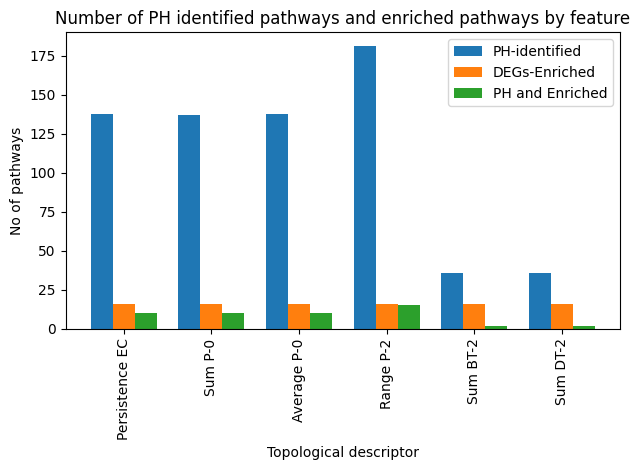

In [294]:
# Calculate the width for each set of bars
bar_width = 0.25
index = np.arange(len(significant_topo_descriptors))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the bars for ph-pathways, DEGs-Enriched, and PH and Enriched
bar1 = ax.bar(index, ph_identified, bar_width, label='PH-identified')
bar2 = ax.bar(index + bar_width, enrich_pathways, bar_width, label='DEGs-Enriched')
bar3 = ax.bar(index + 2 * bar_width, ph_enriched, bar_width, label='PH and Enriched')

# Set labels, title, and legend
ax.set_xlabel('Topological descriptor')
ax.set_ylabel('No of pathways')

# Set labels, title, and legend
ax.set_xlabel('Topological descriptor')
ax.set_ylabel('No of pathways')
ax.set_title('Number of PH identified pathways and enriched pathways by feature')

# Set the x-axis ticks and labels with rotation
ax.set_xticks(index + bar_width)
ax.set_xticklabels(significant_topo_descriptors, rotation=90)

ax.legend()
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

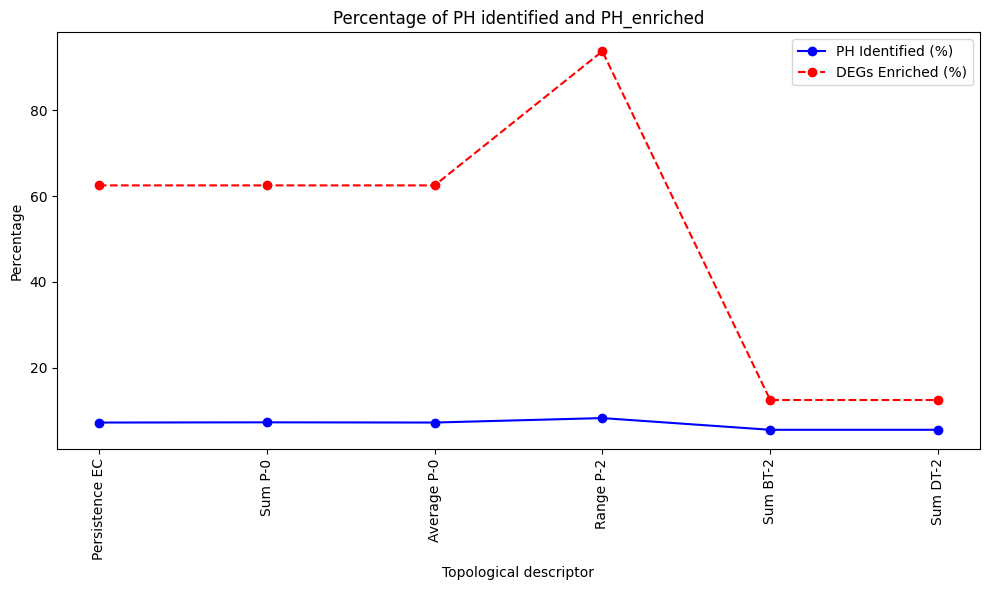

In [295]:
# Plot the curve for Percentage_ph_identified
plt.figure(figsize=(10, 6))

plt.plot(pathways_table['Topological Invariants'], pathways_table['PH Identified (%)'], marker='o', label='PH Identified (%)', linestyle='-', color='b')
plt.plot(pathways_table['Topological Invariants'], pathways_table['DEGs Enriched (%)'], marker='o', label='DEGs Enriched (%)', linestyle='--', color='r')

plt.xlabel('Topological descriptor')
plt.ylabel('Percentage')
plt.title('Percentage of PH identified and PH_enriched')
plt.xticks(rotation=90)
plt.legend()
plt.grid(False)  #

# Show the plot
plt.tight_layout()
plt.show()

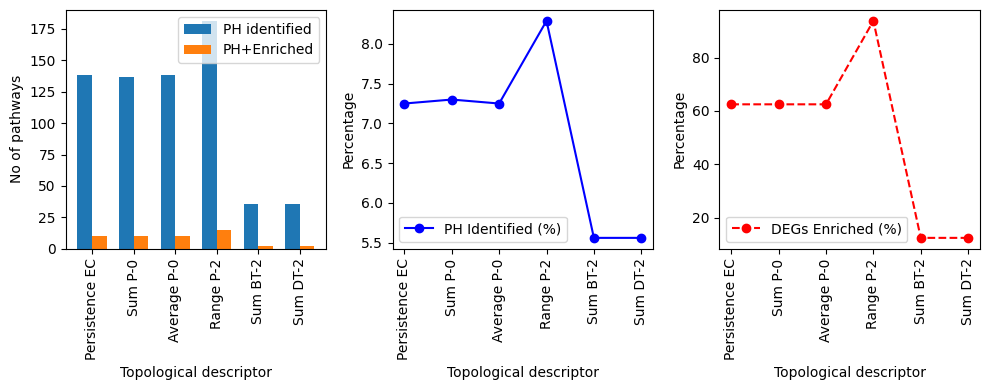

In [300]:
# Create a figure with two subplots side by side
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4))

# Plot the first subplot
bar_width = 0.35
index = np.arange(len(significant_topo_descriptors))

# Create the bars for ph-pathways and enrich_pathways
bar1 = ax.bar(index, ph_identified, bar_width, label='PH identified')
bar3 = ax.bar(index + bar_width, ph_enriched, bar_width, label='PH+Enriched')

# Set labels, title, and legend
ax.set_xlabel('Topological descriptor')
ax.set_ylabel('No of pathways')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(significant_topo_descriptors, rotation=90)
ax.legend()
ax.grid(False)  #

# Plot the second subplot
ax1.plot(pathways_table['Topological Invariants'], pathways_table['PH Identified (%)'], marker='o', label='PH Identified (%)', linestyle='-', color='b')
ax1.set_xlabel('Topological descriptor')
ax1.set_ylabel('Percentage')
ax1.set_xticks(range(len(pathways_table['Topological Invariants'])))  # Set tick positions
ax1.set_xticklabels(pathways_table['Topological Invariants'], rotation=90)  # Assign labels to positions
ax1.legend()
ax1.grid(False)

# Plot the third subplot
ax2.plot(pathways_table['Topological Invariants'], pathways_table['DEGs Enriched (%)'], marker='o', label='DEGs Enriched (%)', linestyle='--', color='r')
ax2.set_xlabel('Topological descriptor')
ax2.set_ylabel('Percentage')
ax2.set_xticks(range(len(pathways_table['Topological Invariants'])))  # Set tick positions
ax2.set_xticklabels(pathways_table['Topological Invariants'], rotation=90)  # Assign labels to positions
ax2.legend()
ax2.grid(False)

# Adjust spacing between subplots
plt.tight_layout()

#plt.savefig("my_plot.png")

# Show the plot (optional, it's not necessary at this point)
plt.show()

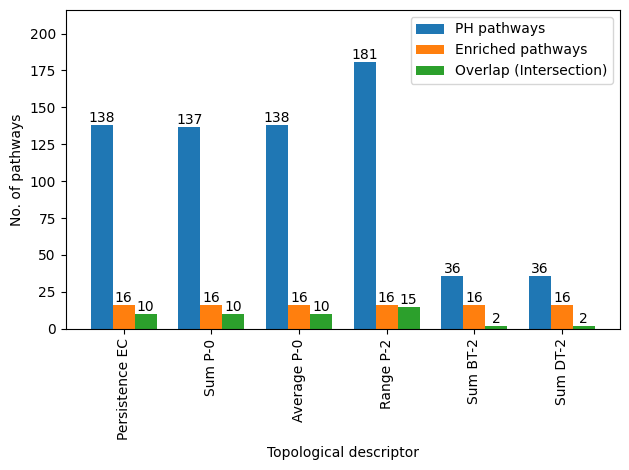

In [305]:
bar_width = 0.25
index = np.arange(len(significant_topo_descriptors))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the bars for ph-pathways, DEGs-Enriched, and PH and Enriched
bar1 = ax.bar(index, ph_identified, bar_width, label='PH pathways')
bar2 = ax.bar(index + bar_width, enrich_pathways, bar_width, label='Enriched pathways')
bar3 = ax.bar(index + 2 * bar_width, ph_enriched, bar_width, label='Overlap (Intersection)')

# Set labels, title, and legend
ax.set_xlabel('Topological descriptor')
ax.set_ylabel('No. of pathways')

# Set the x-axis ticks and labels with rotation
ax.set_xticks(index + bar_width)
ax.set_xticklabels(significant_topo_descriptors, rotation=90)

# Add the value at the top of each bar
def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)
add_value_labels(bar3)

# Set y-axis limits with some space at the top
max_value = max(max(ph_identified), max(enrich_pathways), max(ph_enriched))
ax.set_ylim(0, max_value + 35)  # You can adjust the space by changing the value added

ax.legend()
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

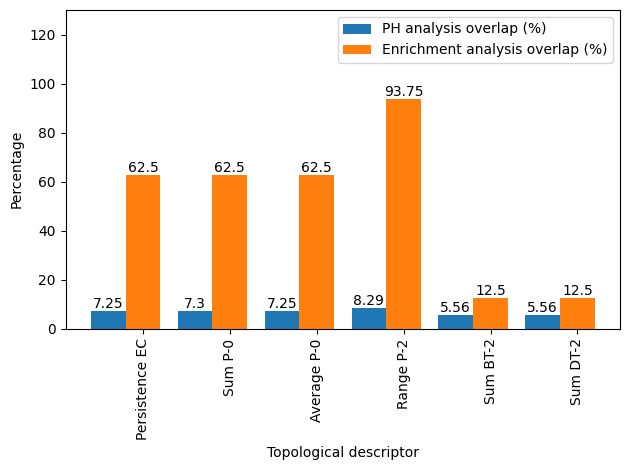

In [304]:
bar_width = 0.4
index = np.arange(len(significant_topo_descriptors))

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the bars for ph-pathways, DEGs-Enriched, and PH and Enriched
bar1 = ax.bar(index, pathways_table['PH Identified (%)'], bar_width, label='PH analysis overlap (%)')
bar2 = ax.bar(index + bar_width, pathways_table['DEGs Enriched (%)'], bar_width, label='Enrichment analysis overlap (%)')

# Set labels, title, and legend
ax.set_xlabel('Topological descriptor')
ax.set_ylabel('Percentage')

# Set the x-axis ticks and labels with rotation
ax.set_xticks(index + bar_width)
ax.set_xticklabels(significant_topo_descriptors, rotation=90)

# Add the value at the top of each bar
def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)

# Set y-axis limits with some space at the top
max_value = 95
ax.set_ylim(0, max_value + 35)  # You can adjust the space by changing the value added

ax.legend()
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

#### Venn diagrams

In [341]:
list_filt_path_pec_adjp = get_identified_pathways(filt_path_pec_adjp)
list_filt_path_s0p_adjp = get_identified_pathways(filt_path_s0p_adjp)
list_filt_path_a0p_adjp = get_identified_pathways(filt_path_a0p_adjp)
list_filt_path_r2p_adjp = get_identified_pathways(filt_path_r2p_adjp)
list_filt_path_s2b_adjp = get_identified_pathways(filt_path_s2b_adjp)
list_filt_path_s2d_adjp = get_identified_pathways(filt_path_s2d_adjp)

unique_features = ['Persistence EC (Sum P-0, Average P-0)', 'Range P-2', 'Sum BT-2 (Sum DT-2)']

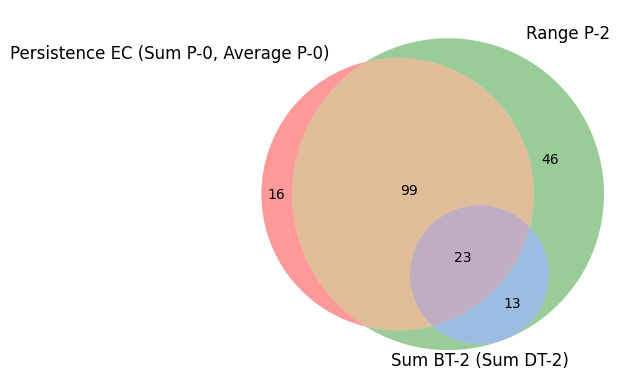

In [343]:
list_A = set(list_filt_path_pec_adjp)
list_B = set(list_filt_path_r2p_adjp)
list_C = set(list_filt_path_s2b_adjp)

# Create a Venn diagram
venn3([list_A, list_B, list_C], unique_features)
plt.show()

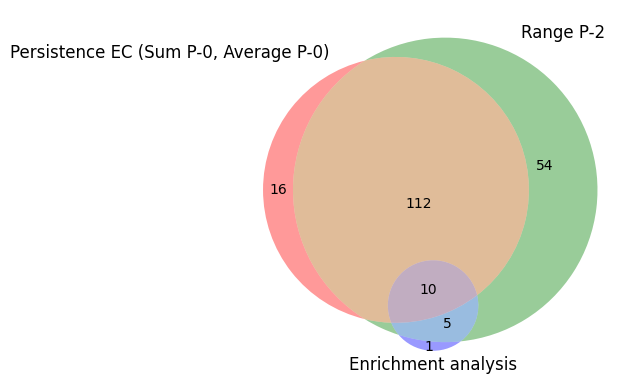

In [340]:
list_A = set(list_filt_path_pec_adjp)
list_B = set(list_filt_path_r2p_adjp)
list_C = set(enrich_degs_pathways)

# Create a Venn diagram
venn3([list_A, list_B, list_C], ('Persistence EC (Sum P-0, Average P-0)', 'Range P-2', 'Enrichment analysis'))
plt.show()

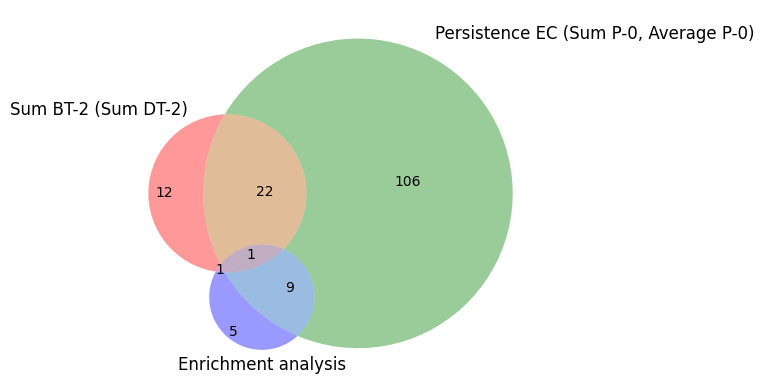

In [339]:
list_A = set(list_filt_path_s2b_adjp)
list_B = set(list_filt_path_pec_adjp)
list_C = set(enrich_degs_paths)

# Create a Venn diagram
venn3([list_A, list_B, list_C], ('Sum BT-2 (Sum DT-2)', 'Persistence EC (Sum P-0, Average P-0)', 'Enrichment analysis'))
plt.show()

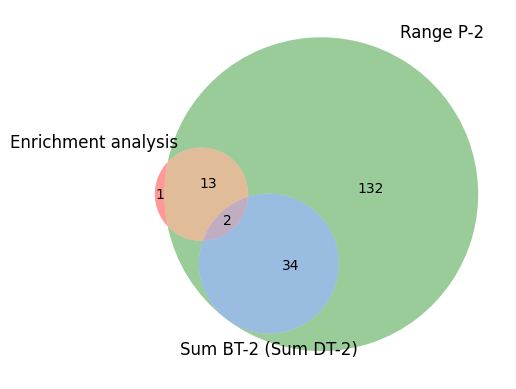

In [334]:
list_A = set(enrich_degs_paths)
list_B = set(list_filt_path_r2p_adjp)
list_C = set(list_filt_path_s2b_adjp)

# Create a Venn diagram
venn3([list_A, list_B, list_C], ('Enrichment analysis', 'Range P-2', 'Sum BT-2 (Sum DT-2)'))
plt.show()

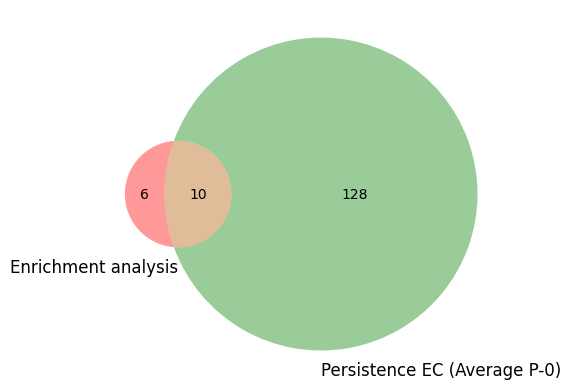

In [335]:
# Persistence EC + Average P-0 + Enriched
list_A = set(enrich_degs_paths)
list_B = set(list_filt_path_pec_adjp)

# Create a Venn diagram
venn2([list_A, list_B], ('Enrichment analysis', 'Persistence EC (Average P-0)'))
plt.show()

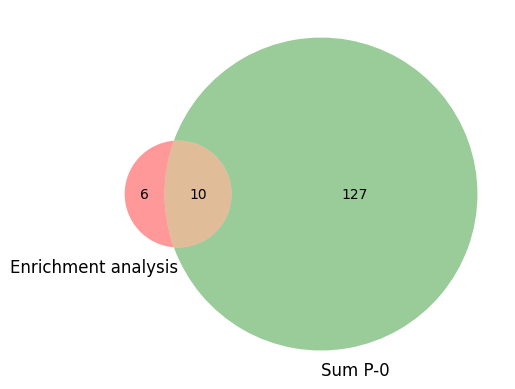

In [336]:
# Sum P-0 + Enriched
list_A = set(enrich_degs_paths)
list_B = set(list_filt_path_s0p_adjp)

# Create a Venn diagram
venn2([list_A, list_B], ('Enrichment analysis', 'Sum P-0'))
plt.show()

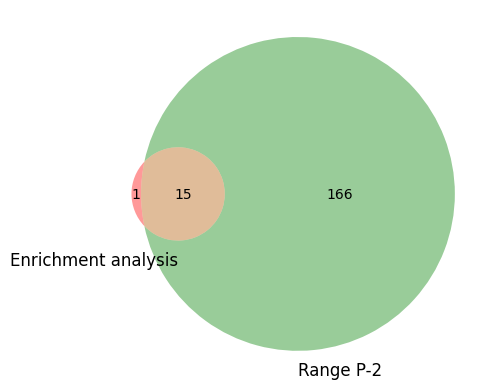

In [337]:
# Range P-2 + Enriched
list_A = set(enrich_degs_paths)
list_B = set(list_filt_path_r2p_adjp)

# Create a Venn diagram
venn2([list_A, list_B], ('Enrichment analysis', 'Range P-2'))
plt.show()

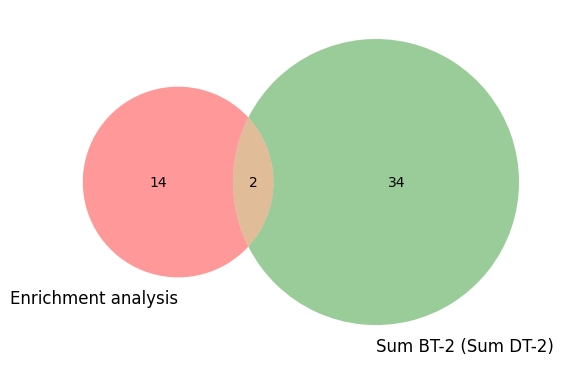

In [338]:
# Sum BT-2 + Sum DT-2 + Enriched
list_A = set(enrich_degs_paths)
list_B = set(list_filt_path_s2b_adjp)

# Create a Venn diagram
venn2([list_A, list_B], ('Enrichment analysis', 'Sum BT-2 (Sum DT-2)'))
plt.show()

In [319]:
intersect_all_adjp005 = [item for item in set(list_filt_path_pec_adjp) & set(list_filt_path_r2p_adjp) & set(list_filt_path_s2b_adjp)]
print(len(intersect_all_adjp005))
print(intersect_all_adjp005)

23
['p53 signaling pathway', 'Drug metabolism - cytochrome P450', 'ABC transporters', 'Tryptophan metabolism', 'Pantothenate and CoA biosynthesis', 'Phosphonate and phosphinate metabolism', 'RNA polymerase', 'Glycine, serine and threonine metabolism', 'Sulfur metabolism', 'Protein processing in endoplasmic reticulum', 'Citrate cycle (TCA cycle)', 'Synaptic vesicle cycle', 'Virion - Herpesvirus', 'Apelin signaling pathway', 'Primary bile acid biosynthesis', 'beta-Alanine metabolism', 'Base excision repair', 'Histidine metabolism', 'IL-17 signaling pathway', 'Collecting duct acid secretion', 'Porphyrin metabolism', 'Riboflavin metabolism', 'Ascorbate and aldarate metabolism']


In [320]:
intersect_adjp005_enrich = [item for item in set(list_filt_path_pec_adjp) & set(list_filt_path_r2p_adjp) & set(list_filt_path_s2b_adjp) & set(enrich_degs_paths)]
print(len(intersect_adjp005_enrich))
print(intersect_adjp005_enrich)

1
['IL-17 signaling pathway']


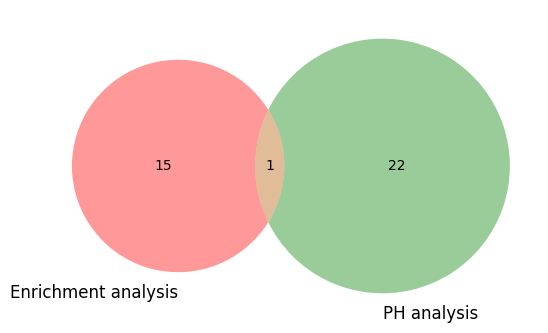

In [322]:
# PH analysis + Enrichment analysis
list_A = set(enrich_degs_paths)
list_B = set(intersect_all_adjp005)

# Create a Venn diagram
venn2([list_A, list_B], ('Enrichment analysis', 'PH analysis'))
#plt.title('Interactions of Significant Pathways for both Methods')
plt.show()

#### UpSet plots

C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetplot\plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' 'black' 'black' 'black' 'black' '#0000002e' 'black' 'black'
 '#0000002e' 'black' '#0000002e' '#0000002e' 'black' 'black' 'black'
 '#0000002e' '#0000002e']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetplot\plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


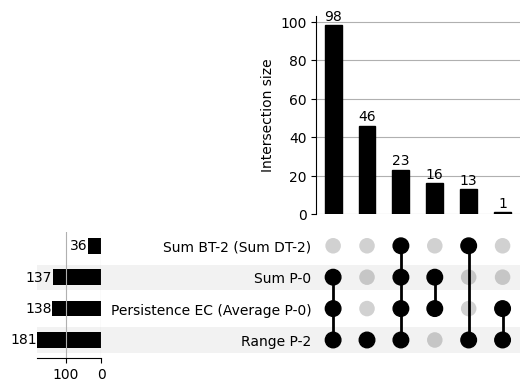

In [324]:
# Overlap between PH identified pathways by all significant descriptors
contents = {'Persistence EC (Average P-0)': list_filt_path_pec_adjp,
            'Sum P-0': list_filt_path_s0p_adjp,
            'Range P-2': list_filt_path_r2p_adjp,
            'Sum BT-2 (Sum DT-2)': list_filt_path_s2b_adjp,
           }

data = from_contents(contents)

upset = UpSet(data, sort_by='cardinality', sort_categories_by='cardinality', show_counts=True)#, query = [('PEC', 'R2P'), ('R2P', 'S2B')])
upset.plot()
plt.show()

C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetplot\plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' 'black'
 '#0000002e' '#0000002e' 'black' 'black' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' 'black' '#0000002e' 'black' 'black' 'black'
 '#0000002e' 'black' 'black' '#0000002e' '#0000002e' '#0000002e' 'black'
 'black' 'black' '#0000002e' '#0000002e' '#0000002e' 'black' 'black'
 'black' 'black' 'black' 'black' '#0000002e' '#0000002e' 'black' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetp

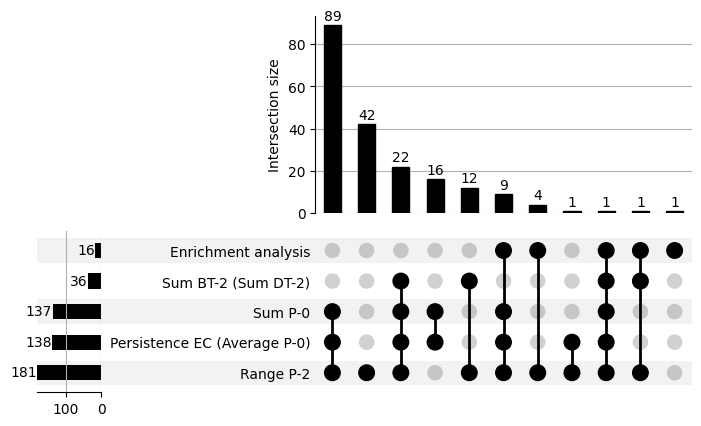

In [325]:
# Overlap between PH identified pathways by all significant descriptors along with enriched pathways
contents = {'Persistence EC (Average P-0)': list_filt_path_pec_adjp,
            'Sum P-0': list_filt_path_s0p_adjp,
            'Range P-2': list_filt_path_r2p_adjp,
            'Sum BT-2 (Sum DT-2)': list_filt_path_s2b_adjp,
            'Enrichment analysis': enrich_degs_paths
           }

data = from_contents(contents)

upset = UpSet(data, sort_by='cardinality', sort_categories_by='cardinality', show_counts=True)
upset.plot()
plt.show()

C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetplot\plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
C:\Users\Muhammad Siraj\AppData\Roaming\Python\Python310\site-packages\upsetplot\plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


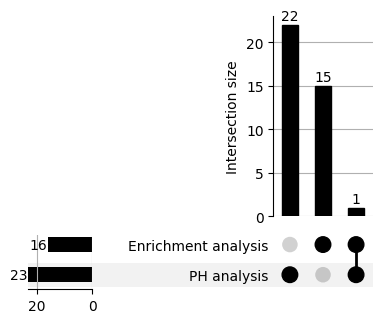

In [327]:
# PH analysis + Enrichment analysis
contents = {'Enrichment analysis': enrich_degs_paths,
            'PH analysis': intersect_all_adjp005
           }

data = from_contents(contents)

upset = UpSet(data, sort_by='cardinality', sort_categories_by='cardinality', show_counts=True)
upset.plot()
#plt.title('Overlap Interactions: Significant Pathways for Both Methods')
plt.show()